## Projet CCF Forward Looking

### 🎯 Objectif

Construire un modèle de **CCF Forward Looking (FL)** pour enrichir le calcul de l’**EAD** dans le cadre IFRS 9, à partir de variables **macroéconomiques**.
👉 Le but est de projeter un **CCF prévisionnel à 3 ans** à partir de scénarii sur les données macro.


#### 📁 **Données\_CFF\_SERIE\_GLOBALE\_VF.csv**

| Variable               | Description                                                                                              | Remarque                                                                                                           |
| ---------------------- | -------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------ |
| `date`                 | Date d’arrêté. Correspond à la génération 12 mois avant le défaut                                        | Les données sont trimestrielles. Tester aussi une modélisation annuelle, comme c’est le cas en production bancaire |
| `Indicateur_Moyen_1_5` | CCF brut moyen trimestriel pour la population des segments 1 à 5 (où le CCF est variable)                | Variable cible à projeter                                                                                          |
| `Effectif_Pourc_1_5`   | % d’effectifs pour une date donnée (segments 1 à 5)                                                      | Sert à pondérer les périodes, utile pour améliorer la corrélation avec les variables macro                         |
| `Indicateur_Moyen_1_6` | CCF brut moyen trimestriel pour l’ensemble de la population (incluant le segment 6 avec CCF fixé à 100%) | Variable cible à projeter                                                                                          |
| `Effectif_Pourc_1_6`   | % d’effectifs pour une date donnée (segments 1 à 6)                                                      | Sert à pondérer les périodes et tester l’apport du segment 6 malgré son CCF fixe                                   |

---

#### 📁 **Données\_CFF\_PAR\_SEGMENT.csv**

| Variable                | Description                                                                       | Remarque                                                                                                                       |
| ----------------------- | --------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------ |
| `Date`                  | Date d’arrêté (de 200903 à 202212)                                                | Tester modélisation trimestrielle **et** annuelle                                                                              |
| `Note_ref`              | Segment du CCF                                                                    | —                                                                                                                              |
| `Indicateur_moyen_Brut` | CCF moyen brut par segment                                                        | Variable cible                                                                                                                 |
| `PourcNote`             | % de la population d’un segment par rapport à l’ensemble des trimestres existants | Peu utile au début, mais à tester pour analyse de stationnarité                                                                |
| `PourcNoteCohorte`      | % dans un segment par rapport à toute la cohorte (6 segments)                     | Séries souvent instables, peut fausser les analyses. À tester avec pondération par les effectifs (ex : Weighted Least Squares) |
| `PourcNoteCohorte5`     | % dans un segment par rapport à la cohorte 1 à 5 (exclut segment 6 à CCF fixe)    | À privilégier pour éviter la distorsion induite par le segment 6                                                               |



# CHARGER LES DONNES

In [126]:
# === Manipulation de données ===
import pandas as pd
import numpy as np

# === Visualisation ===
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# === Analyse statistique / séries temporelles ===
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.filters.hp_filter import hpfilter

# === Modélisation linéaire ===
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cross_decomposition import PLSRegression

# === Réduction de dimension ===
from sklearn.decomposition import PCA

# === Divers ===
from itertools import combinations

# === Classe custom (si présente dans ton projet) ===
from EvaluatorClass import WLSModelEvaluator


In [127]:
# Chargement des données
segment_path = '/Users/toninrvr/Documents/MOSEF venv/Credit-Risk-Project/data/Données_CCF_PAR_SEGMENT.csv'
global_path = '/Users/toninrvr/Documents/MOSEF venv/Credit-Risk-Project/data/Données_CCF_SERIE_GLOBALE_VF.csv'

df_global = pd.read_csv(global_path, sep=";")
df_segment = pd.read_csv(segment_path, sep=";")

# Statistiques descriptives
desc_global = df_global.info()
desc_segment = df_segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date                  60 non-null     object
 1   Indicateur_Moyen_1_5  60 non-null     object
 2   Effectif_Pourc_1_5    60 non-null     object
 3   Indicateur_Moyen_1_6  56 non-null     object
 4   Effectif_Pourc_1_6    56 non-null     object
dtypes: object(5)
memory usage: 2.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   cod_prd_ref            360 non-null    object
 1   note_ref               360 non-null    int64 
 2   Indicateur_moyen_Brut  360 non-null    object
 3   PourcNote              360 non-null    object
 4   PourcNoteCohorte       360 non-null    object
 5   PourcNoteCohorte5      360 non-null    obj

In [ ]:
# Chargement des données macroéconomiques
macro_path = '/Users/toninrvr/Documents/MOSEF venv/Credit-Risk-Project/data/macrovariables/historique_macro_variables_projet_CCF_FowardLooking_IFRS9.xlsx'
df_macro = pd.read_excel(macro_path)

display(df_macro.head())

date_dernier_mois  PIB  IPL  TCH  Inflation  PIB_diff1  IPL_diff1  \
0           1980-03  0.0  0.0  5.3        0.0        NaN        NaN   
1           1980-06  0.0  0.0  5.3        0.0        0.0        0.0   
2           1980-09  0.0  0.0  5.4        0.0        0.0        0.0   
3           1980-12  0.0  0.0  5.6        0.0        0.0        0.0   
4           1981-03  0.0  0.0  6.0        0.0        0.0        0.0   

   TCH_diff1  Inflation_diff1  
0        NaN              NaN  
1        0.0              0.0  
2        0.1              0.0  
3        0.2              0.0  
4        0.4              0.0

# EXPLO DES DONNEES

#### Transformation des dates

In [ ]:
# Nettoyage et conversion des colonnes numériques avec virgules
for col in ['Indicateur_Moyen_1_5', 'Effectif_Pourc_1_5', 'Indicateur_Moyen_1_6', 'Effectif_Pourc_1_6']:
    df_global[col] = df_global[col].str.replace(',', '.').astype(float)

for col in ['Indicateur_moyen_Brut', 'PourcNote', 'PourcNoteCohorte', 'PourcNoteCohorte5']:
    df_segment[col] = df_segment[col].str.replace(',', '.').astype(float)

# Conversion des dates
df_global['date'] = pd.to_datetime(df_global['date'])

# Nettoyage des espaces et conversion en date trimestrielle
df_segment['date'] = pd.to_datetime(df_segment['cod_prd_ref'].astype(str).str.strip().str.replace('T', 'Q'))

/var/folders/f0/q3pz9yqx3x7gnp3hqnj1hqvm0000gn/T/ipykernel_5248/1355441854.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_segment['date'] = pd.to_datetime(df_segment['cod_prd_ref'].astype(str).str.strip().str.replace('T', 'Q'))


<DatetimeArray>
['2009-01-01 00:00:00', '2009-04-01 00:00:00', '2009-07-01 00:00:00',
 '2009-10-01 00:00:00', '2010-01-01 00:00:00', '2010-04-01 00:00:00',
 '2010-07-01 00:00:00', '2010-10-01 00:00:00', '2011-01-01 00:00:00',
 '2011-04-01 00:00:00', '2011-07-01 00:00:00', '2011-10-01 00:00:00',
 '2012-01-01 00:00:00', '2012-04-01 00:00:00', '2012-07-01 00:00:00',
 '2012-10-01 00:00:00', '2013-01-01 00:00:00', '2013-04-01 00:00:00',
 '2013-07-01 00:00:00', '2013-10-01 00:00:00', '2014-01-01 00:00:00',
 '2014-04-01 00:00:00', '2014-07-01 00:00:00', '2014-10-01 00:00:00',
 '2015-01-01 00:00:00', '2015-04-01 00:00:00', '2015-07-01 00:00:00',
 '2015-10-01 00:00:00', '2016-01-01 00:00:00', '2016-04-01 00:00:00',
 '2016-07-01 00:00:00', '2016-10-01 00:00:00', '2017-01-01 00:00:00',
 '2017-04-01 00:00:00', '2017-07-01 00:00:00', '2017-10-01 00:00:00',
 '2018-01-01 00:00:00', '2018-04-01 00:00:00', '2018-07-01 00:00:00',
 '2018-10-01 00:00:00', '2019-01-01 00:00:00', '2019-04-01 00:00:00',
 '20

#### Visualisations des séries

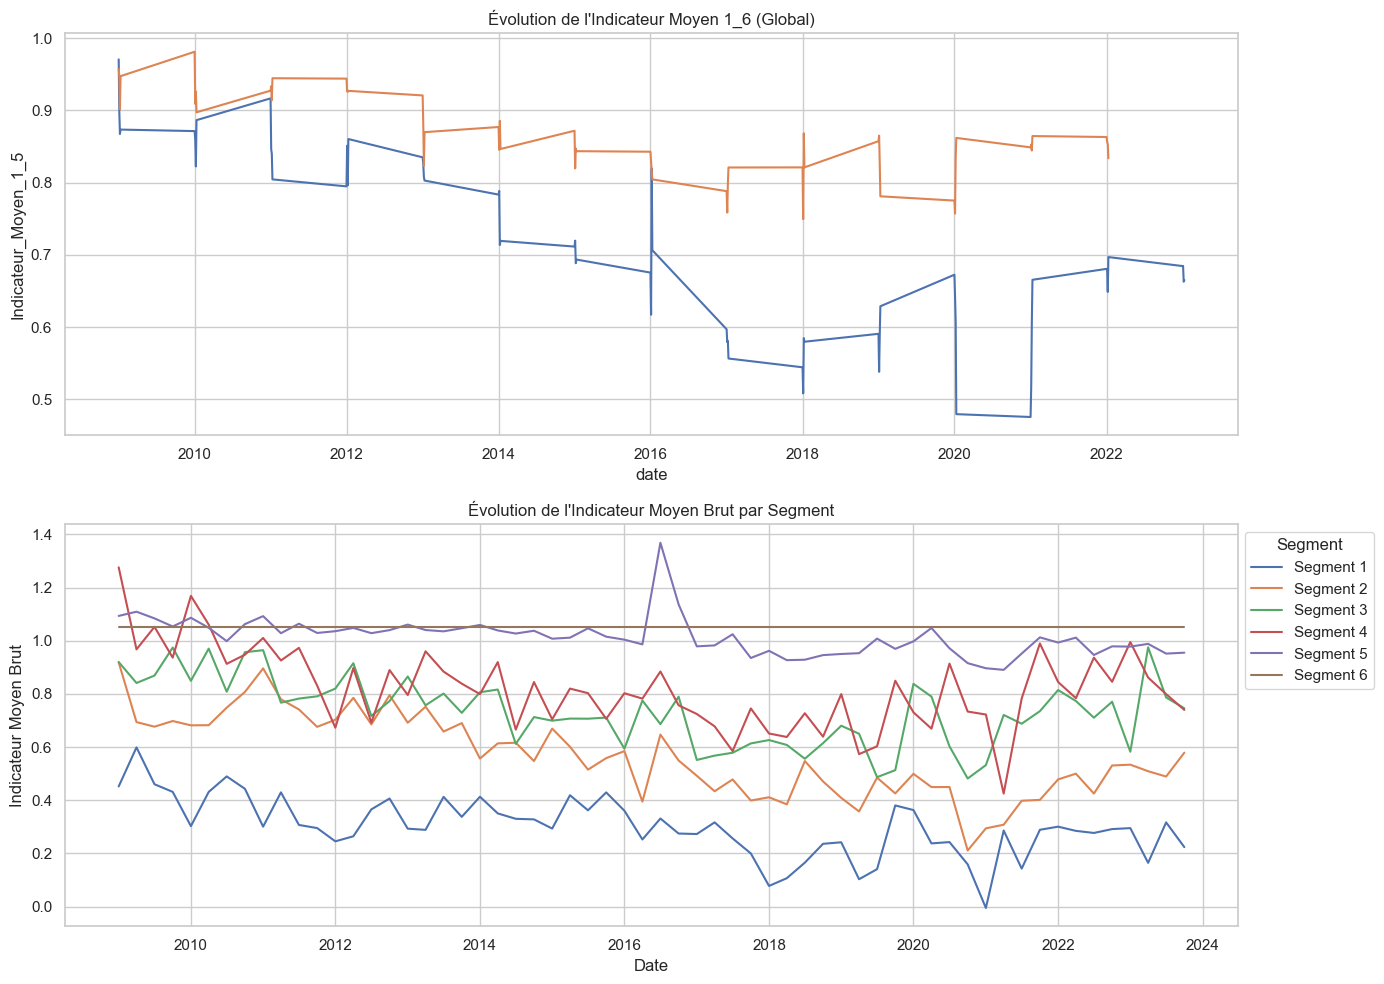

In [130]:
# Visualisations
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=False)

# Global CCF 1_5
sns.lineplot(data=df_global, x='date', y='Indicateur_Moyen_1_5', ax=axs[0])
axs[0].set_title("Évolution de l'Indicateur Moyen 1_5 (Global)")

sns.lineplot(data=df_global, x='date', y='Indicateur_Moyen_1_6', ax=axs[0])
axs[0].set_title("Évolution de l'Indicateur Moyen 1_6 (Global)")


# Plusieurs segments superposés avec légende
for i in range(0, 6):
    segment = df_segment['note_ref'].unique()[i]
    df_plot_seg = df_segment[df_segment['note_ref'] == segment]
    sns.lineplot(
        data=df_plot_seg,
        x='date',
        y='Indicateur_moyen_Brut',
        ax=axs[1],
        label=f"Segment {segment}"
    )

axs[1].set_title("Évolution de l'Indicateur Moyen Brut par Segment")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Indicateur Moyen Brut")
axs[1].legend(title="Segment", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()



#### Visualisations des données macroéconomiques

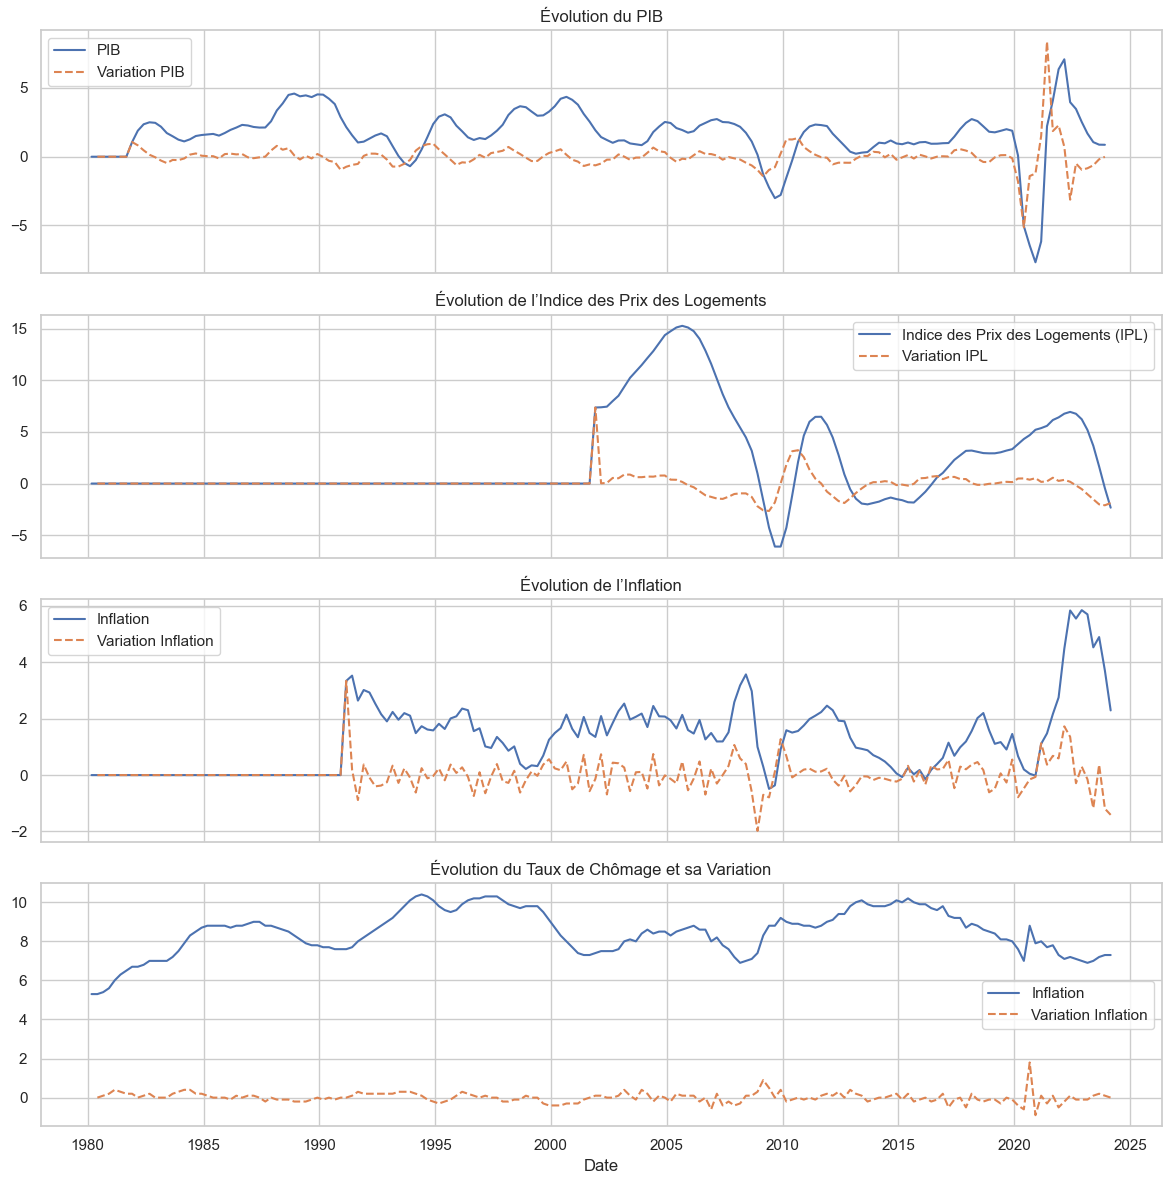

In [131]:
# Tracer PIB, IPL et Inflation avec leurs variations
fig, ax = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

df_macro["date_dernier_mois"] = pd.to_datetime(df_macro["date_dernier_mois"])

# PIB
ax[0].plot(df_macro["date_dernier_mois"], df_macro["PIB"], label="PIB")
ax[0].plot(df_macro["date_dernier_mois"], df_macro["PIB_diff1"], label="Variation PIB", linestyle='--')
ax[0].set_title("Évolution du PIB")
ax[0].legend()
ax[0].grid(True)

# IPL
ax[1].plot(df_macro["date_dernier_mois"], df_macro["IPL"], label="Indice des Prix des Logements (IPL)" )
ax[1].plot(df_macro["date_dernier_mois"], df_macro["IPL_diff1"], label="Variation IPL", linestyle='--')
ax[1].set_title("Évolution de l’Indice des Prix des Logements")
ax[1].legend()
ax[1].grid(True)

# Inflation
ax[2].plot(df_macro["date_dernier_mois"], df_macro["Inflation"], label="Inflation")
ax[2].plot(df_macro["date_dernier_mois"], df_macro["Inflation_diff1"], label="Variation Inflation", linestyle='--')
ax[2].set_title("Évolution de l’Inflation")
ax[2].legend()
ax[2].grid(True)

# Inflation
ax[3].plot(df_macro["date_dernier_mois"], df_macro["TCH"], label="Inflation")
ax[3].plot(df_macro["date_dernier_mois"], df_macro["TCH_diff1"], label="Variation Inflation", linestyle='--')
ax[3].set_title("Évolution du Taux de Chômage et sa Variation")
ax[3].legend()
ax[3].grid(True)

plt.xlabel("Date")
plt.tight_layout()
plt.show()


#### Corrélation des données macroéconomiques

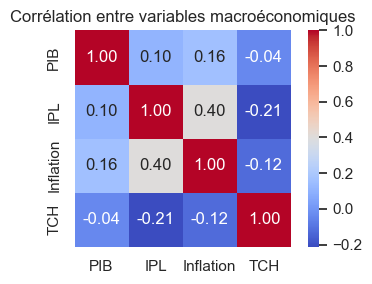

In [ ]:
simple_corr = df_macro[["PIB", "IPL", "Inflation", "TCH"]].corr()

# Tracer la heatmap de corrélation
plt.figure(figsize=(4, 3))
sns.heatmap(simple_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Corrélation entre variables macroéconomiques")
plt.tight_layout()
plt.show()


In [133]:
display(df_macro.head())

date_dernier_mois  PIB  IPL  TCH  Inflation  PIB_diff1  IPL_diff1  \
0        1980-03-01  0.0  0.0  5.3        0.0        NaN        NaN   
1        1980-06-01  0.0  0.0  5.3        0.0        0.0        0.0   
2        1980-09-01  0.0  0.0  5.4        0.0        0.0        0.0   
3        1980-12-01  0.0  0.0  5.6        0.0        0.0        0.0   
4        1981-03-01  0.0  0.0  6.0        0.0        0.0        0.0   

   TCH_diff1  Inflation_diff1  
0        NaN              NaN  
1        0.0              0.0  
2        0.1              0.0  
3        0.2              0.0  
4        0.4              0.0

## FORMATAGE

##### Mise à jour des dates pour fusion des dataframes

In [ ]:
# Créer une fonction de conversion de fin à début de trimestre
def start_of_quarter(date):
    if date.month == 3:
        return pd.Timestamp(year=date.year, month=1, day=1)
    elif date.month == 6:
        return pd.Timestamp(year=date.year, month=4, day=1)
    elif date.month == 9:
        return pd.Timestamp(year=date.year, month=7, day=1)
    elif date.month == 12:
        return pd.Timestamp(year=date.year, month=10, day=1)
    else:
        return pd.NaT

# S'assurer que la colonne est au format datetime
df_macro["date_dernier_mois"] = pd.to_datetime(df_macro["date_dernier_mois"], errors='coerce')

# Appliquer la transformation sur df_macro
df_macro["date_dernier_mois"] = df_macro["date_dernier_mois"].apply(start_of_quarter)


In [ ]:
# Reformatage de la date pour df_macro
df_macro["date_dernier_mois"] = df_macro["date_dernier_mois"].dt.strftime("%d-%m-%Y")
df_macro["date_dernier_mois"] = pd.to_datetime(df_macro["date_dernier_mois"], format="%d-%m-%Y")

# Filtrer les dates de l'année 2009 pour les deux DataFrames
dates_segment_2009 = df_segment[df_segment["date"].dt.year == 2009]["date"].unique()
dates_global_2009 = df_global[df_global["date"].dt.year == 2009]["date"].unique()
dates_macro_2009 = df_macro[df_macro["date_dernier_mois"].dt.year == 2009]["date_dernier_mois"].unique()

# Créer un tableau comparatif
df_dates_2009 = pd.DataFrame({
    "Dates df_global (2009)": dates_global_2009,
    "Dates df_segment (2009)": dates_segment_2009,
    "Dates df_macro (2009)": dates_macro_2009
})

print(df_dates_2009)

  Dates df_global (2009) Dates df_segment (2009) Dates df_macro (2009)
0             2009-01-01              2009-01-01            2009-01-01
1             2009-01-04              2009-04-01            2009-04-01
2             2009-01-07              2009-07-01            2009-07-01
3             2009-01-10              2009-10-01            2009-10-01


##### Fusion des données CCF et macro

Et création des variables 'lag' pour la suite

In [ ]:
df_macro_lag = df_macro.copy()

# Création des lag pour les variables macroéconomiques
df_macro_lag['PIB_lag1'] = df_macro['PIB'].shift(1)
df_macro_lag['IPL_lag1'] = df_macro['IPL_diff1'].shift(1)
df_macro_lag['Inflation_lag1'] = df_macro['Inflation_diff1'].shift(1)
df_macro_lag['TCH_lag1'] = df_macro['TCH_diff1'].shift(1)

# Pivot pour transformer les colonnes par segment (note_ref)
pivot_df = df_segment.pivot(index="date", columns="note_ref", values=["Indicateur_moyen_Brut", "PourcNoteCohorte5"])

# Aplatir les colonnes multi-index
pivot_df.columns = [f"{var}_{int(note)}" for var, note in pivot_df.columns]

# Fusionner avec les données macroéconomiques
df_macro_lag = df_macro_lag.rename(columns={"date_dernier_mois": "date"})
df_merged = pivot_df.merge(df_macro_lag, on="date", how="left")

# Créer une copie sans la colonne Indicateur_moyen_Brut_6
df_merged_6 = df_merged.drop(columns=["Indicateur_moyen_Brut_6"], inplace=False)

df_merged.set_index("date", inplace=True)

display(df_merged.head())


Indicateur_moyen_Brut_1  Indicateur_moyen_Brut_2  \
date                                                           
2009-01-01                 0.451963                 0.918515   
2009-04-01                 0.598795                 0.693970   
2009-07-01                 0.460212                 0.676645   
2009-10-01                 0.431518                 0.697949   
2010-01-01                 0.302710                 0.681718   

            Indicateur_moyen_Brut_3  Indicateur_moyen_Brut_4  \
date                                                           
2009-01-01                 0.919843                 1.275864   
2009-04-01                 0.840965                 0.967390   
2009-07-01                 0.868909                 1.052081   
2009-10-01                 0.974173                 0.936315   
2010-01-01                 0.849149                 1.168515   

            Indicateur_moyen_Brut_5  Indicateur_moyen_Brut_6  \
date                                                           
2009-01-01                 1.093203                     1.05   
2009-04-01                 1.109015                     1.05   
2009-07-01                 1.083922                     1.05   
2009-10-01                 1.053459                     1.05   
2010-01-01                 1.086222                     1.05   

            PourcNoteCohorte5_1  PourcNoteCohorte5_2  PourcNoteCohorte5_3  \
date                                                                        
2009-01-01             0.115244             0.237795             0.130521   
2009-04-01             0.109356             0.254647             0.131660   
2009-07-01             0.100492             0.295740             0.142272   
2009-10-01             0.102461             0.265383             0.130819   
2010-01-01             0.109683             0.255927             0.143388   

            PourcNoteCohorte5_4  PourcNoteCohorte5_5  PourcNoteCohorte5_6  \
date                                                                        
2009-01-01             0.084689             0.431750                  0.0   
2009-04-01             0.101921             0.402416                  0.0   
2009-07-01             0.091207             0.370289                  0.0   
2009-10-01             0.098983             0.402354                  0.0   
2010-01-01             0.103970             0.387032                  0.0   

                 PIB       IPL  TCH  Inflation  PIB_diff1  IPL_diff1  \
date                                                                   
2009-01-01 -1.286788 -1.624415  8.3   0.301692  -1.430885  -2.593841   
2009-04-01 -2.243102 -4.278729  8.8  -0.489570  -0.956314  -2.654313   
2009-07-01 -3.012266 -6.103516  8.8  -0.362976  -0.769164  -1.824787   
2009-10-01 -2.782833 -6.105367  9.2   0.914470   0.229433  -0.001851   
2010-01-01 -1.517665 -4.278209  9.0   1.589859   1.265167   1.827158   

            TCH_diff1  Inflation_diff1  PIB_lag1  IPL_lag1  Inflation_lag1  \
date                                                                         
2009-01-01        0.9        -0.697982  0.144097 -2.204378       -1.979658   
2009-04-01        0.5        -0.791262 -1.286788 -2.593841       -0.697982   
2009-07-01        0.0         0.126594 -2.243102 -2.654313       -0.791262   
2009-10-01        0.4         1.277447 -3.012266 -1.824787        0.126594   
2010-01-01       -0.2         0.675389 -2.782833 -0.001851        1.277447   

            TCH_lag1  
date                  
2009-01-01       0.3  
2009-04-01       0.9  
2009-07-01       0.5  
2009-10-01       0.0  
2010-01-01       0.4

#### Visualisation des toutes les séries à même échelle

Pour capter des tendances 

Index(['Indicateur_moyen_Brut_1', 'Indicateur_moyen_Brut_2',
       'Indicateur_moyen_Brut_3', 'Indicateur_moyen_Brut_4',
       'Indicateur_moyen_Brut_5', 'Indicateur_moyen_Brut_6',
       'PourcNoteCohorte5_1', 'PourcNoteCohorte5_2', 'PourcNoteCohorte5_3',
       'PourcNoteCohorte5_4', 'PourcNoteCohorte5_5', 'PourcNoteCohorte5_6',
       'PIB', 'IPL', 'TCH', 'Inflation'],
      dtype='object')


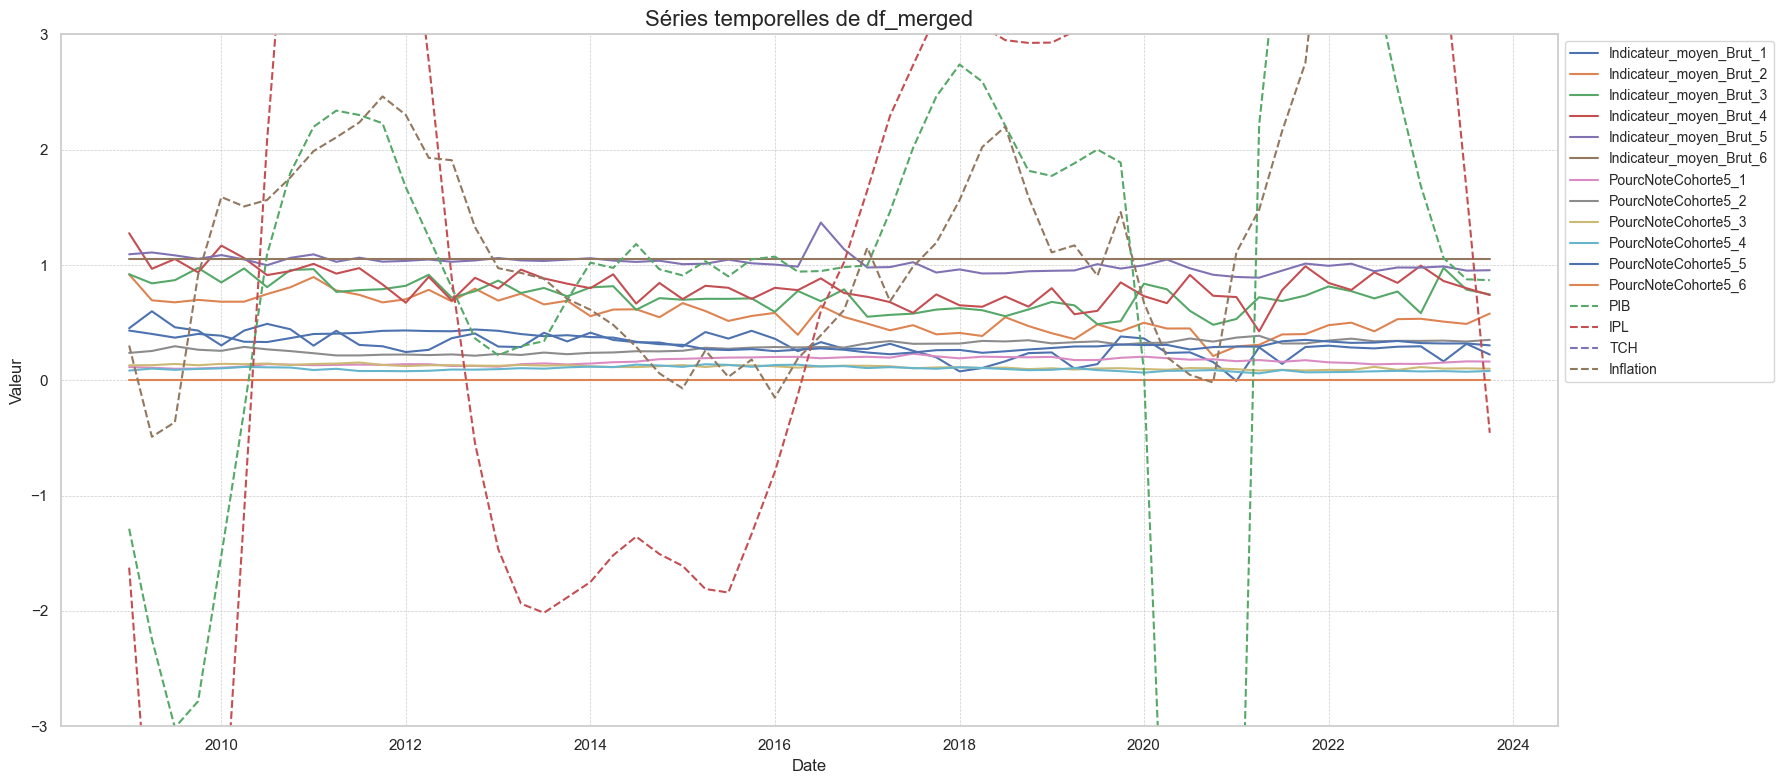

In [ ]:
plt.figure(figsize=(18, 8))

# Supprimer les colonnes qui se terminent par _diff1 ou _lag1
df_merged_base = df_merged.loc[:, ~df_merged.columns.str.endswith(('_diff1', '_lag1'))]

# Afficher les colonnes restantes pour vérification
print(df_merged_base.columns)

# Identifier les quatre dernières colonnes
last_four_columns = df_merged_base.columns[-4:]

for column in df_merged_base.columns:
    if column in last_four_columns:
        plt.plot(df_merged_base.index, df_merged_base[column], label=column, linestyle='--')  # Pointillés
    else:
        plt.plot(df_merged_base.index, df_merged_base[column], label=column)  # Ligne continue

# Ajouter des légendes et des titres
plt.title("Séries temporelles de df_merged", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Valeur", fontsize=12)
plt.ylim([-3, 3])
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

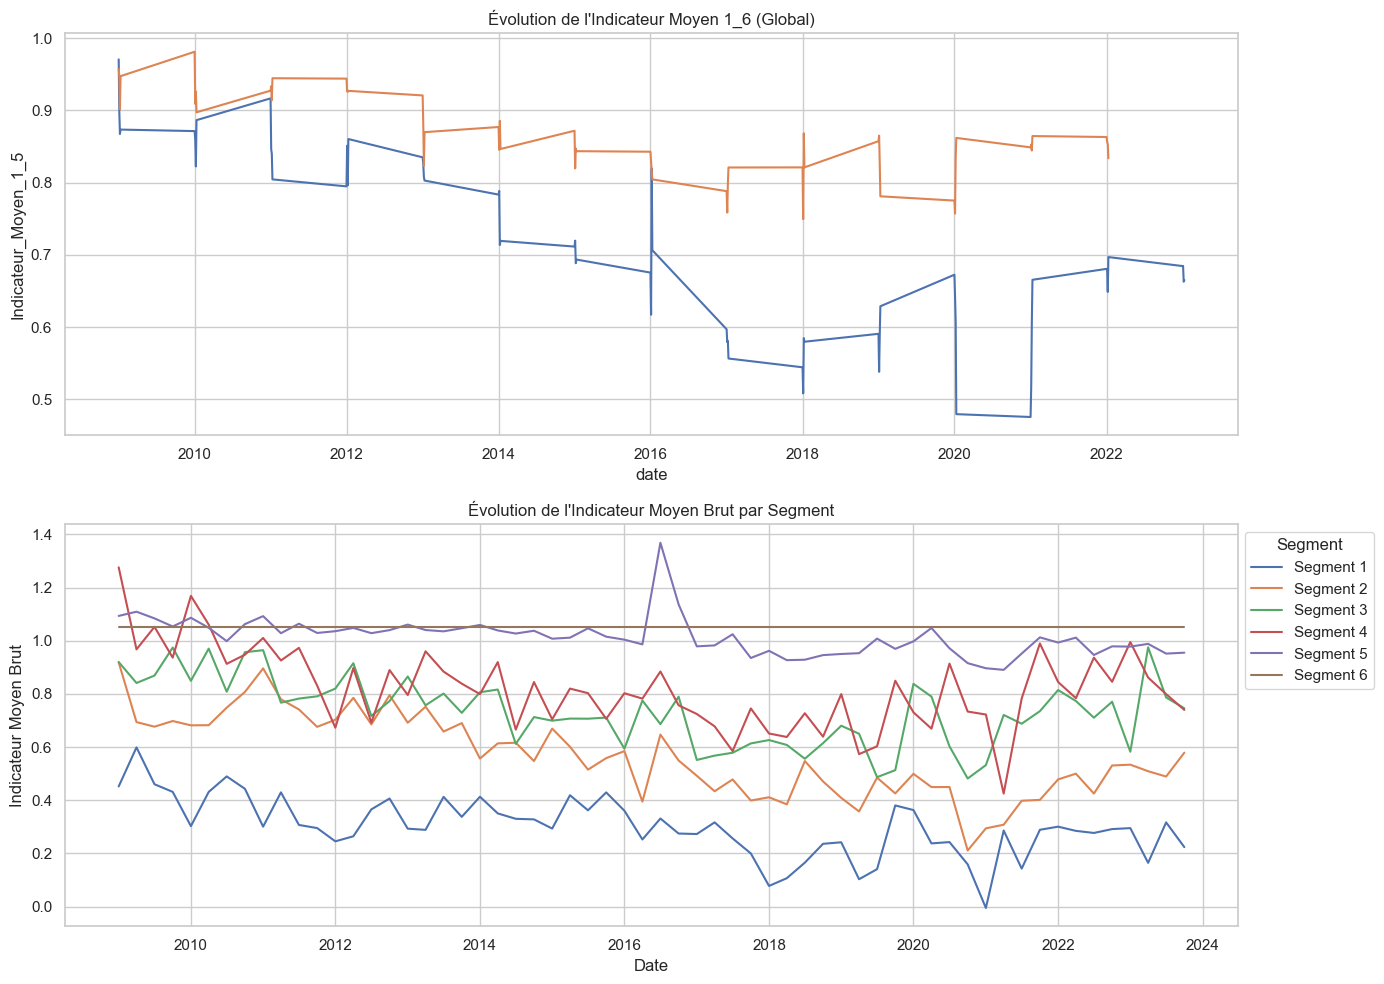

In [ ]:
# Visualisations
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=False)

# Global CCF 1_5
sns.lineplot(data=df_global, x='date', y='Indicateur_Moyen_1_5', ax=axs[0])
axs[0].set_title("Évolution de l'Indicateur Moyen 1_5 (Global)")

sns.lineplot(data=df_global, x='date', y='Indicateur_Moyen_1_6', ax=axs[0])
axs[0].set_title("Évolution de l'Indicateur Moyen 1_6 (Global)")

# Plusieurs segments superposés avec légende
for i in range(0, 6):
    segment = df_segment['note_ref'].unique()[i]
    df_plot_seg = df_segment[df_segment['note_ref'] == segment]
    sns.lineplot(
        data=df_plot_seg,
        x='date',
        y='Indicateur_moyen_Brut',
        ax=axs[1],
        label=f"Segment {segment}"
    )

axs[1].set_title("Évolution de l'Indicateur Moyen Brut par Segment")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Indicateur Moyen Brut")
axs[1].legend(title="Segment", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()



### Visualisation des séries avec le pourcentage d'effectif du segment (PourcNote_)

pour vérifier une relation potentielle

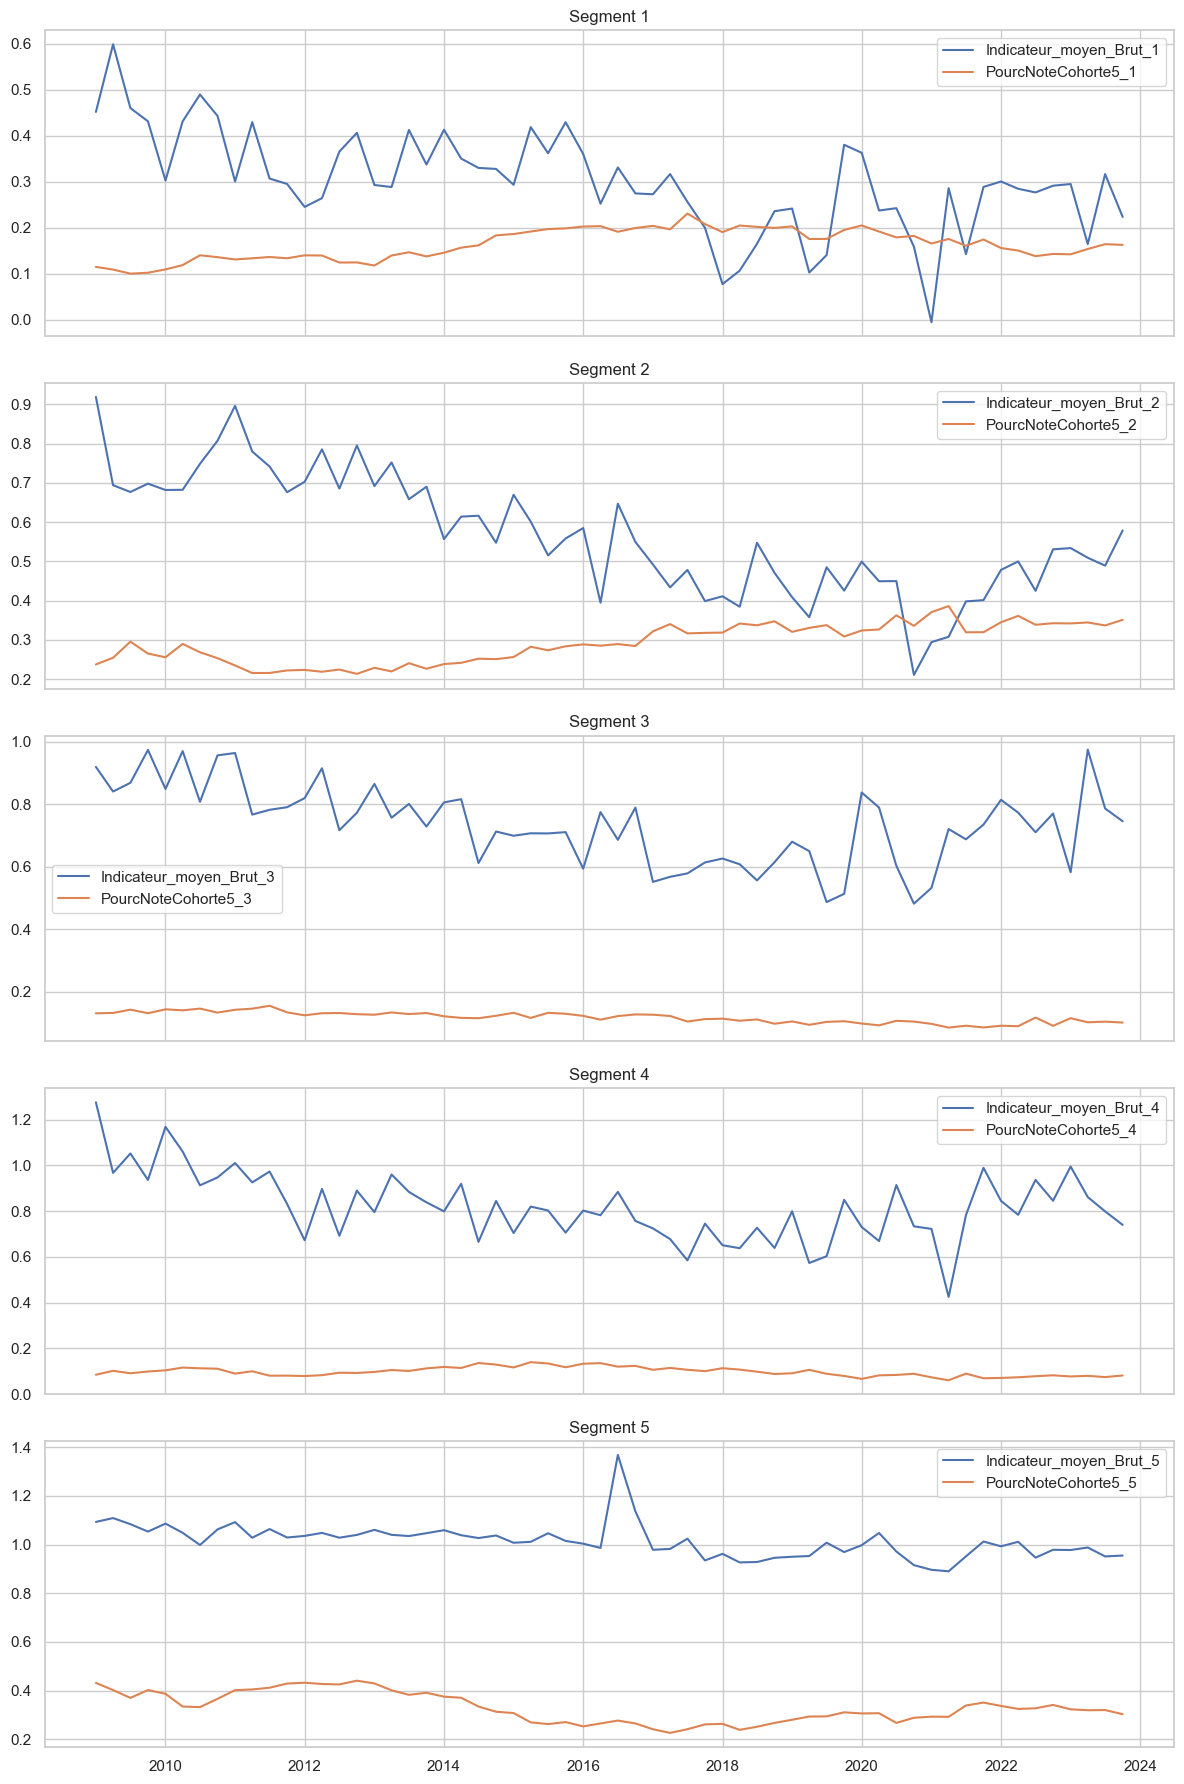

In [139]:
# Création des subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 18), sharex=True)

for i in range(1, 6):
    ax = axes[i-1]
    ax.plot(df_merged.index, df_merged[f'Indicateur_moyen_Brut_{i}'], label=f'Indicateur_moyen_Brut_{i}')
    ax.plot(df_merged.index, df_merged[f'PourcNoteCohorte5_{i}'], label=f'PourcNoteCohorte5_{i}')
    ax.set_title(f'Segment {i}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


## ANALYSE EXPLORATOIRE

### CCF GLOBAL

#### Autocorrelation

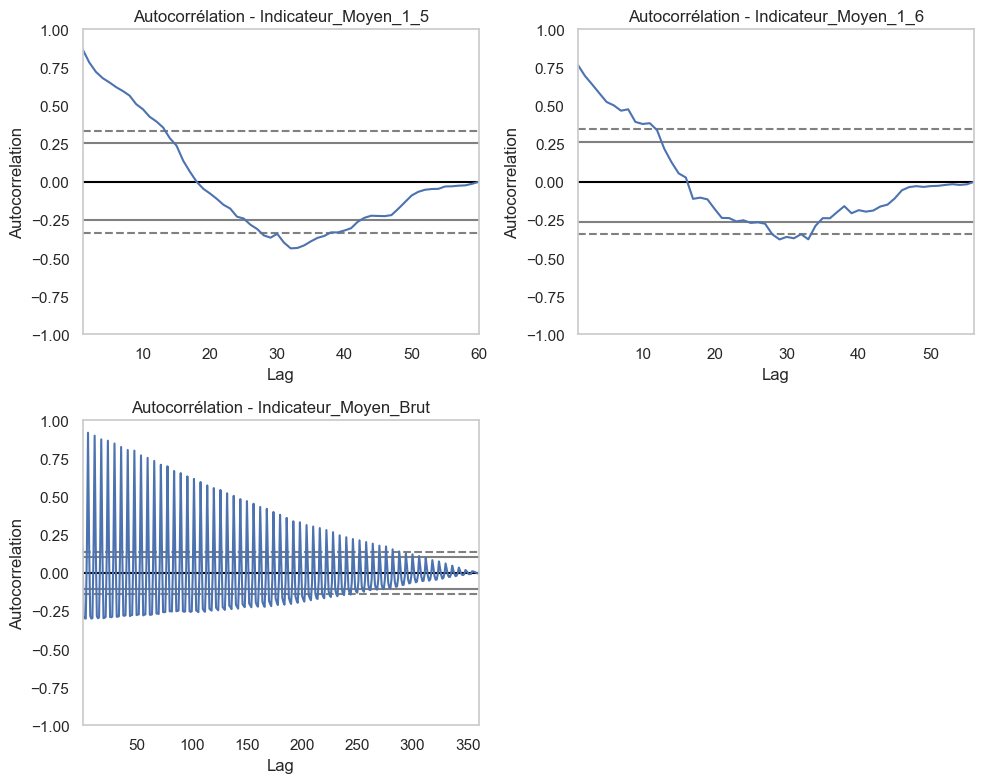

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
autocorrelation_plot(df_global["Indicateur_Moyen_1_5"].dropna())
plt.title("Autocorrélation - Indicateur_Moyen_1_5")

plt.subplot(2, 2, 2)
autocorrelation_plot(df_global["Indicateur_Moyen_1_6"].dropna())
plt.title("Autocorrélation - Indicateur_Moyen_1_6")

plt.subplot(2, 2, 3)
autocorrelation_plot(df_segment["Indicateur_moyen_Brut"].dropna())
plt.title("Autocorrélation - Indicateur_Moyen_Brut")

plt.tight_layout()
plt.show()

#### Stationnarité

In [ ]:
# Création de dictionnaires d'entrée
series_sources = {
    "Indicateur_Moyen_1_5": df_global["Indicateur_Moyen_1_5"].dropna(),  # df_global
    "Indicateur_Moyen_1_6": df_global["Indicateur_Moyen_1_6"].dropna(),  # df_global
    "Indicateur_Moyen_Brut": df_segment["Indicateur_moyen_Brut"].dropna()  # df_segmentdf_segment["Indicateur_moyen_Brut"].dropna() df_segment["Indicateur_moyen_Brut"].dropna()  #  # df_segment
}
# Lancer le test ADF
adf_results_corrected = []

for name, series in series_sources.items():
    adf = adfuller(series)
    adf_results_corrected.append({
        "Série": name,
        "ADF Statistic": adf[0],
        "p-value": adf[1],
        "Critique 1%": adf[4]['1%'],
        "Critique 5%": adf[4]['5%'],
        "Critique 10%": adf[4]['10%']
    })

adf_df_corrected = pd.DataFrame(adf_results_corrected)
adf_df_corrected

Série  ADF Statistic   p-value  Critique 1%  Critique 5%  \
0   Indicateur_Moyen_1_5      -2.371826  0.149847    -3.546395    -2.911939   
1   Indicateur_Moyen_1_6      -2.128698  0.233133    -3.557709    -2.916770   
2  Indicateur_Moyen_Brut      -2.053515  0.263612    -3.449616    -2.870028   

   Critique 10%  
0     -2.593652  
1     -2.596222  
2     -2.571292

##### Règles de stationnarité

p-value > 0.05, donc on ne rejette pas l’hypothèse nulle :


👉 pas stationnaire au seuil de 5%.


Statistique ADF > valeur critique à 5%,

👉 pas stationnaire au seuil de 5%.

### Par segment

In [142]:
df_segment.head()

cod_prd_ref  note_ref  Indicateur_moyen_Brut  PourcNote  \
0          2009T1         1               0.451963   0.012816   
1          2009T1         2               0.918515   0.015002   
2          2009T1         3               0.919843   0.018888   
3          2009T1         4               1.275864   0.014854   
4          2009T1         5               1.093203   0.022140   

   PourcNoteCohorte  PourcNoteCohorte5       date  
0          0.067787           0.115244 2009-01-01  
1          0.139871           0.237795 2009-01-01  
2          0.076773           0.130521 2009-01-01  
3          0.049814           0.084689 2009-01-01  
4          0.253956           0.431750 2009-01-01

#### Autocorrelation & Partial Autocorrelation

In [143]:
# Re-imports after code execution environment reset
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Test ADF pour chaque série par note_ref
results = []
for note, group in df_segment.groupby('note_ref'):
    series = group.sort_values('date')['Indicateur_moyen_Brut']
    
    # Skip constant series
    if series.nunique() == 1:
        results.append({
            'Série': f'Indicateur_Moyen_Brut_{note}',
            'ADF Statistic': None,
            'p-value': None,
            'Critique 1%': None,
            'Critique 5%': None,
            'Critique 10%': None,
            'Note': 'Constant series - skipped'
        })
        continue
    
    result = adfuller(series)
    results.append({
        'Série': f'Indicateur_Moyen_Brut_{note}',
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critique 1%': result[4]['1%'],
        'Critique 5%': result[4]['5%'],
        'Critique 10%': result[4]['10%']
    })

adf_results_df = pd.DataFrame(results)

display(adf_results_df)


Série  ADF Statistic   p-value  Critique 1%  Critique 5%  \
0  Indicateur_Moyen_Brut_1      -3.983272  0.001501    -3.546395    -2.911939   
1  Indicateur_Moyen_Brut_2      -1.833660  0.363883    -3.548494    -2.912837   
2  Indicateur_Moyen_Brut_3      -2.228654  0.196010    -3.565624    -2.920142   
3  Indicateur_Moyen_Brut_4      -5.324879  0.000005    -3.546395    -2.911939   
4  Indicateur_Moyen_Brut_5      -4.430622  0.000262    -3.546395    -2.911939   
5  Indicateur_Moyen_Brut_6            NaN       NaN          NaN          NaN   

   Critique 10%                       Note  
0     -2.593652                        NaN  
1     -2.594129                        NaN  
2     -2.598015                        NaN  
3     -2.593652                        NaN  
4     -2.593652                        NaN  
5           NaN  Constant series - skipped

| Segment   | ACF persistante | ADF p-value | Stationnaire ? | Action recommandée  |
| --------- | --------------- | ----------- | -------------- | ------------------- |
| Segment 1 | Moyenne         | 0.0015      | ✅ Oui          | OK                  |
| Segment 2 | Forte           | 0.36        | ❌ Non          | Différencier        |
| Segment 3 | Moyenne à forte | 0.196       | ❌ Non          | Différencier        |
| Segment 4 | Moyenne         | 0.000005    | ✅ Oui          | OK                  |
| Segment 5 | Faible          | 0.00026     | ✅ Oui          | OK                  |
| Segment 6 |      | NaN         | ❌ Constante     |  |


## Pour les MACRO

In [ ]:
# Filtrer les données de df_macro de 2009 à aujourd'hui
df_macro = df_macro[df_macro['date_dernier_mois'] >= '2009-01-01']

display(df_macro.head())

date_dernier_mois       PIB       IPL   TCH  Inflation  PIB_diff1  \
116        2009-01-01 -1.286788 -1.624415   8.3   0.301692  -1.430885   
117        2009-04-01 -2.243102 -4.278729   8.8  -0.489570  -0.956314   
118        2009-07-01 -3.012266 -6.103516   8.8  -0.362976  -0.769164   
119        2009-10-01 -2.782833 -6.105367   9.2   0.914470   0.229433   
120        2010-01-01 -1.517665 -4.278209   9.0   1.589859   1.265167   
121        2010-04-01 -0.263588 -1.149425   8.9   1.508021   1.254077   
122        2010-07-01  1.092998  2.080083   8.9   1.564342   1.356586   
123        2010-10-01  1.799343  4.640797   8.8   1.759062   0.706346   
124        2011-01-01  2.198821  5.985363   8.8   1.987945   0.399477   
125        2011-04-01  2.339377  6.459948   8.7   2.107260   0.140557   
126        2011-07-01  2.301174  6.469689   8.8   2.236523  -0.038203   
127        2011-10-01  2.229597  5.687798   9.0   2.462022  -0.071577   
128        2012-01-01  1.674949  4.463625   9.1   2.301711  -0.554648   
129        2012-04-01  1.242017  2.766990   9.4   1.929625  -0.432932   
130        2012-07-01  0.804715  0.885167   9.4   1.908988  -0.437303   
131        2012-10-01  0.363708 -0.545282   9.8   1.329243  -0.441006   
132        2013-01-01  0.217978 -1.463645  10.0   0.972940  -0.145730   
133        2013-04-01  0.296295 -1.936703  10.1   0.931363   0.078317   
134        2013-07-01  0.339871 -2.015651   9.9   0.880923   0.043576   
135        2013-10-01  0.697479 -1.883194   9.8   0.706357   0.357608   
136        2014-01-01  1.020546 -1.748922   9.8   0.612265   0.323067   
137        2014-04-01  0.975386 -1.517341   9.8   0.481444  -0.045159   
138        2014-07-01  1.181895 -1.355276   9.9   0.291077   0.206509   
139        2014-10-01  0.963355 -1.506317  10.1   0.060120  -0.218540   
140        2015-01-01  0.909806 -1.609364  10.0  -0.069832  -0.053549   
141        2015-04-01  1.033505 -1.809733  10.2   0.259533   0.123699   
142        2015-07-01  0.901572 -1.840039  10.0   0.030024  -0.131933   
143        2015-10-01  1.049129 -1.332018   9.9   0.180252   0.147557   
144        2016-01-01  1.072991 -0.793061   9.9  -0.149745   0.023862   
145        2016-04-01  0.942824 -0.124533   9.7   0.189168  -0.130167   
146        2016-07-01  0.947690  0.599850   9.6   0.390195   0.004866   
147        2016-10-01  0.981821  1.025000   9.8   0.609756   0.034131   
148        2017-01-01  0.996275  1.648763   9.3   1.149770   0.014454   
149        2017-04-01  1.463407  2.294264   9.2   0.685680   0.467132   
150        2017-07-01  2.014283  2.732919   9.2   0.986645   0.550875   
151        2017-10-01  2.460784  3.167533   8.7   1.192250   0.446501   
152        2018-01-01  2.739159  3.194888   8.9   1.561728   0.278375   
153        2018-04-01  2.590638  3.071672   8.8   2.023293  -0.148521   
154        2018-07-01  2.207764  2.950423   8.6   2.200730  -0.382874   
155        2018-10-01  1.817771  2.926361   8.5   1.590574  -0.389993   
156        2019-01-01  1.772737  2.929269   8.4   1.109489  -0.045035   
157        2019-04-01  1.882538  3.027436   8.1   1.170552   0.109801   
158        2019-07-01  2.002164  3.194738   8.1   0.907686   0.119626   
159        2019-10-01  1.888406  3.332557   8.0   1.459360  -0.113757   
160        2020-01-01  0.081567  3.817677   7.6   0.673790  -1.806840   
161        2020-04-01 -5.049860  4.315886   7.0   0.200803  -5.131427   
162        2020-07-01 -6.455276  4.689278   8.8   0.047847  -1.405416   
163        2020-10-01 -7.678693  5.209743   7.9  -0.019051  -1.223417   
164        2021-01-01 -6.166529  5.371072   8.0   1.109093   1.512164   
165        2021-04-01  2.213321  5.589789   7.7   1.479149   8.379850   
166        2021-07-01  4.079661  6.153512   7.8   2.161645   1.866341   
167        2021-10-01  6.364221  6.409432   7.3   2.753430   2.284560   
168        2022-01-01  7.086354  6.768190   7.1   4.482270   0.722133   
169        2022-04-01  3.964249  6.940392   7.2   5.839759  -3

#### Stationnarité

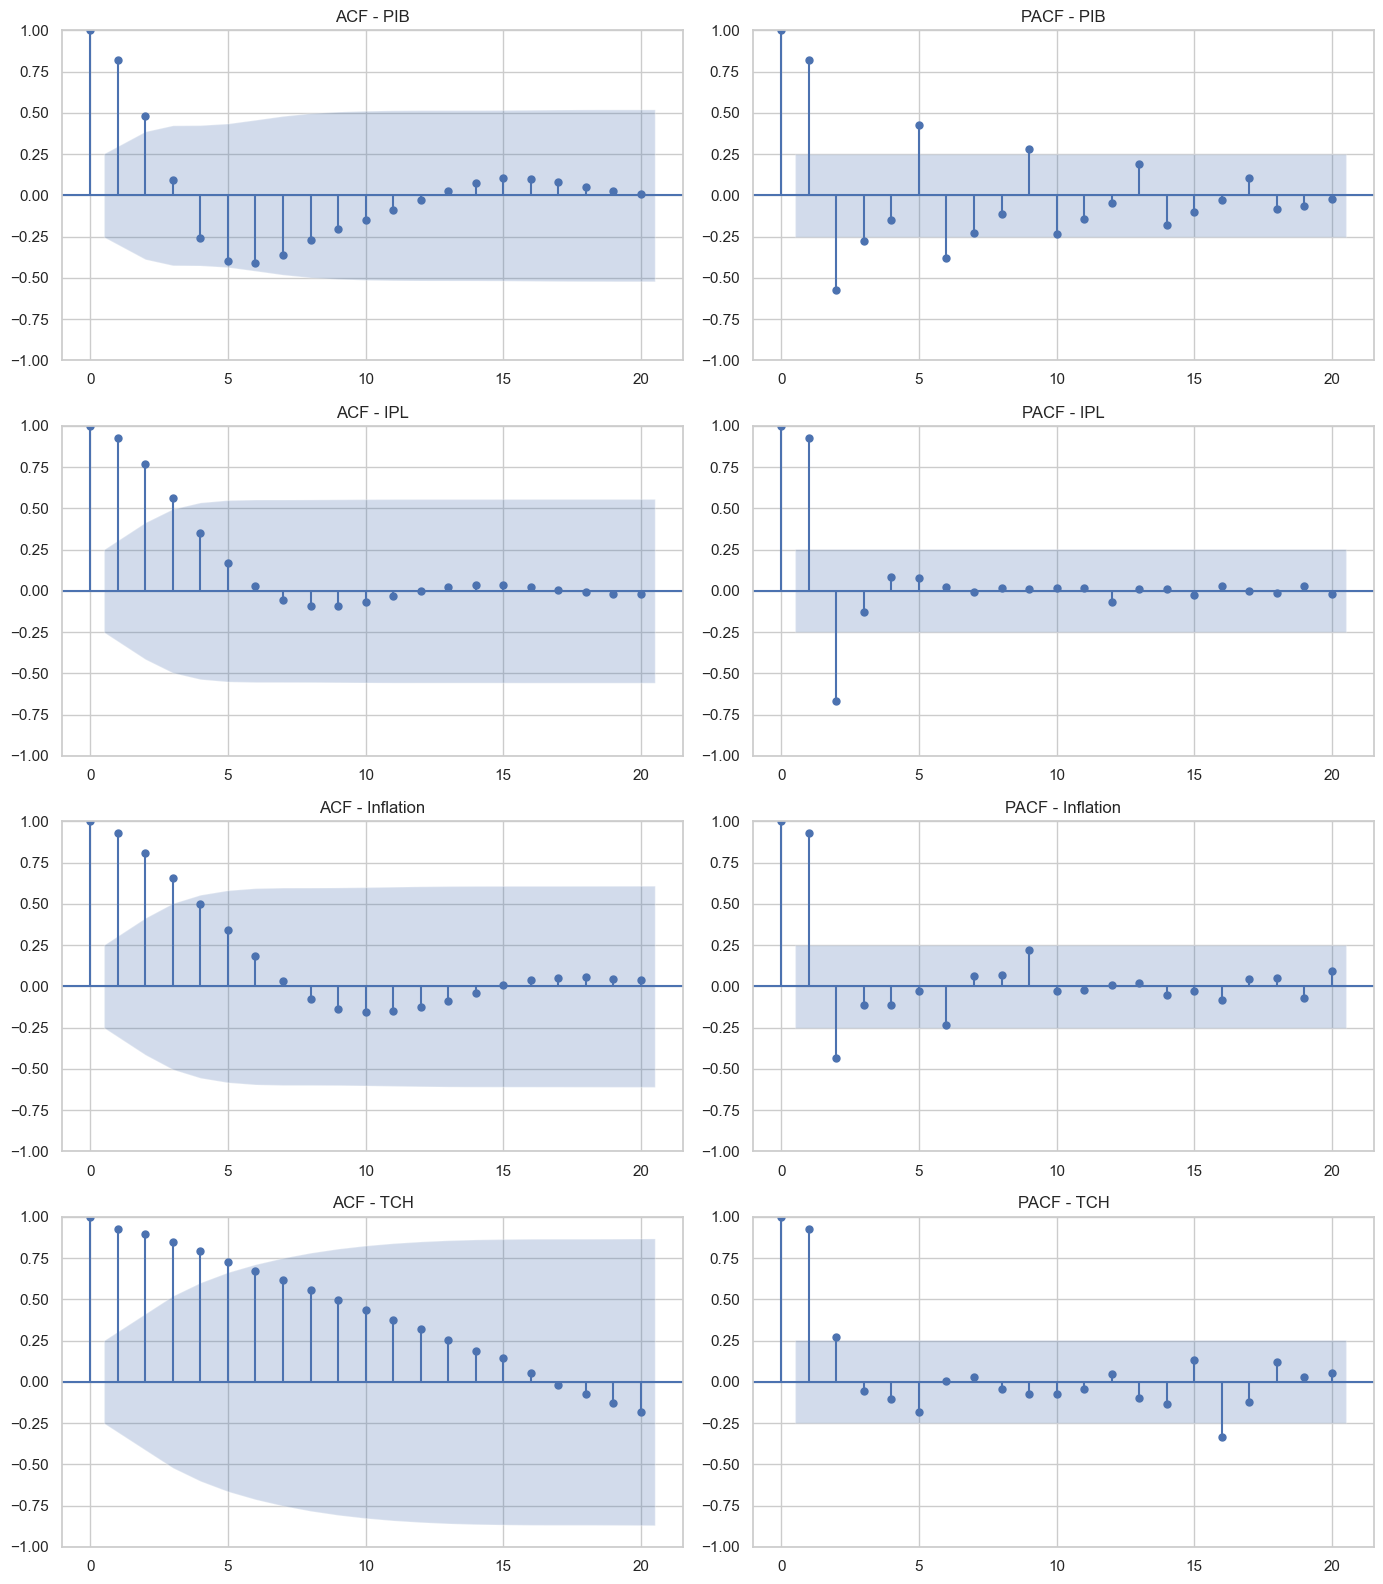

Variable  ADF Statistic   p-value  Critique 1%  Critique 5%  Critique 10%
0        PIB      -3.327967  0.013674    -3.571472    -2.922629     -2.599336
1        IPL      -1.542183  0.512550    -3.568486    -2.921360     -2.598662
2  Inflation      -1.320889  0.619562    -3.562879    -2.918973     -2.597393
3        TCH      -0.270556  0.929572    -3.546395    -2.911939     -2.593652

In [ ]:
# Variables macro à tester
macro_vars = ["PIB", "IPL", "Inflation", "TCH"]

# Initialiser les résultats ADF
adf_results_macro = []

# Grille 4 lignes × 2 colonnes
fig, axes = plt.subplots(nrows=len(macro_vars), ncols=2, figsize=(14, 4 * len(macro_vars)))

for i, var in enumerate(macro_vars):
    series = df_macro[var].dropna()

    # ACF (colonne 0)
    plot_acf(series, ax=axes[i][0], lags=20, alpha=0.05)
    axes[i][0].set_title(f"ACF - {var}")

    # PACF (colonne 1)
    plot_pacf(series, ax=axes[i][1], lags=20, alpha=0.05, method="ywmle")
    axes[i][1].set_title(f"PACF - {var}")

    # Test ADF
    try:
        adf = adfuller(series)
        adf_results_macro.append({
            "Variable": var,
            "ADF Statistic": adf[0],
            "p-value": adf[1],
            "Critique 1%": adf[4]["1%"],
            "Critique 5%": adf[4]["5%"],
            "Critique 10%": adf[4]["10%"]
        })
    except:
        adf_results_macro.append({
            "Variable": var,
            "ADF Statistic": None,
            "p-value": None,
            "Critique 1%": None,
            "Critique 5%": None,
            "Critique 10%": None
        })

plt.tight_layout()
plt.show()

adf_df_macro = pd.DataFrame(adf_results_macro)
adf_df_macro


| Variable      | ADF Stat. | p-value | Stationnaire ? | Action à prévoir         |
| ------------- | --------- | ------- | -------------- | ------------------------ |
| **PIB**       | -3.33     | 0.0137  | ✅ Oui (5%)     | Utilisable en l'état     |
| **IPL**       | -1.54     | 0.5126  | ❌ Non          | Appliquer une différence |
| **Inflation** | -1.32     | 0.6196  | ❌ Non          | Appliquer une différence |
| **TCH**       | -0.27     | 0.9296  | ❌ Non          | Appliquer une différence |


## Différenciation

Nous allons continuer uniquement avec la partie segmenté ensuite

In [147]:
# Créer un DataFrame par segment (valeur unique de note_ref)
segments_dfs = {
    f"segment_{segment}": df_segment[df_segment["note_ref"] == segment].reset_index(drop=True)
    for segment in sorted(df_segment["note_ref"].unique())
}

# Afficher les noms des segments et un aperçu d’un segment
segment_names = list(segments_dfs.keys())

segment_1 = segments_dfs[segment_names[0]]
segment_2 = segments_dfs[segment_names[1]]
segment_3 = segments_dfs[segment_names[2]]
segment_4 = segments_dfs[segment_names[3]]
segment_5 = segments_dfs[segment_names[4]]
segment_6 = segments_dfs[segment_names[5]]

### Méthode 1 : Taux de variation

$$
\text{TV}_t = \frac{X_t - X_{t-1}}{X_{t-1}} = \left( \frac{X_t}{X_{t-1}} \right) - 1
$$

In [148]:
# Segments à transformer
segments_to_transform = ["segment_2", "segment_3"]
tv_results = []

for name in segments_to_transform:
    series = segments_dfs[name]["Indicateur_moyen_Brut"]
    
    # Taux de variation classique
    series_tv = series.pct_change().dropna()
    
    try:
        adf = adfuller(series_tv)
        tv_results.append({
            "Segment (TV %)": name,
            "ADF Statistic": adf[0],
            "p-value": adf[1],
            "Critique 1%": adf[4]['1%'],
            "Critique 5%": adf[4]['5%'],
            "Critique 10%": adf[4]['10%']
        })
    except:
        tv_results.append({
            "Segment (TV %)": name,
            "ADF Statistic": None,
            "p-value": None,
            "Critique 1%": None,
            "Critique 5%": None,
            "Critique 10%": None
        })

df_tv_adf = pd.DataFrame(tv_results)
print(df_tv_adf)


  Segment (TV %)  ADF Statistic   p-value  Critique 1%  Critique 5%  \
0      segment_2      -5.156570  0.000011    -3.557709    -2.916770   
1      segment_3      -1.275033  0.640516    -3.577848    -2.925338   

   Critique 10%  
0     -2.596222  
1     -2.600774  


### Méthode 2 : log-différenciation)

In [ ]:
# Appliquer log.diff() et tester la stationnarité
segments_to_transform = ["segment_2", "segment_3"]
tv_results = []

for name in segments_to_transform:
    series = segments_dfs[name]["Indicateur_moyen_Brut"]
    series_log_diff = np.log(series).diff().dropna()
    
    try:
        adf = adfuller(series_log_diff)
        tv_results.append({
            "Segment (log diff)": name,
            "ADF Statistic": adf[0],
            "p-value": adf[1],
            "Critique 1%": adf[4]['1%'],
            "Critique 5%": adf[4]['5%'],
            "Critique 10%": adf[4]['10%']
        })
    except:
        tv_results.append({
            "Segment (log diff)": name,
            "ADF Statistic": None,
            "p-value": None,
            "Critique 1%": None,
            "Critique 5%": None,
            "Critique 10%": None
        })

df_tv_adf = pd.DataFrame(tv_results)
display(df_tv_adf)

  Segment (log diff)  ADF Statistic   p-value  Critique 1%  Critique 5%  \
0          segment_2      -5.251563  0.000007    -3.557709    -2.916770   
1          segment_3      -2.863254  0.049791    -3.565624    -2.920142   

   Critique 10%  
0     -2.596222  
1     -2.598015  


### Méthode 3 : Hodrick-Prescott

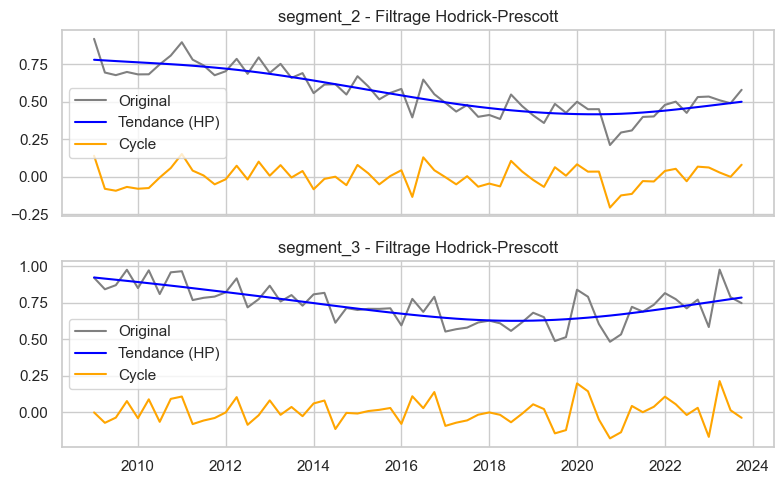

In [ ]:
# Appliquer le filtre HP à chaque série non stationnaire
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

for i, name in enumerate(["segment_2", "segment_3"]):
    df = segments_dfs[name]
    cycle, trend = hpfilter(df["Indicateur_moyen_Brut"], lamb=1600)
    df["trend"] = trend
    df["cycle"] = cycle

    # Tracer
    axes[i].plot(df["date"], df["Indicateur_moyen_Brut"], label="Original", color='gray')
    axes[i].plot(df["date"], df["trend"], label="Tendance (HP)", color='blue')
    axes[i].plot(df["date"], df["cycle"], label="Cycle", color='orange')
    axes[i].set_title(f"{name} - Filtrage Hodrick-Prescott")
    axes[i].legend()

plt.tight_layout()
plt.show()


#### Visualisations des 3 méthodes

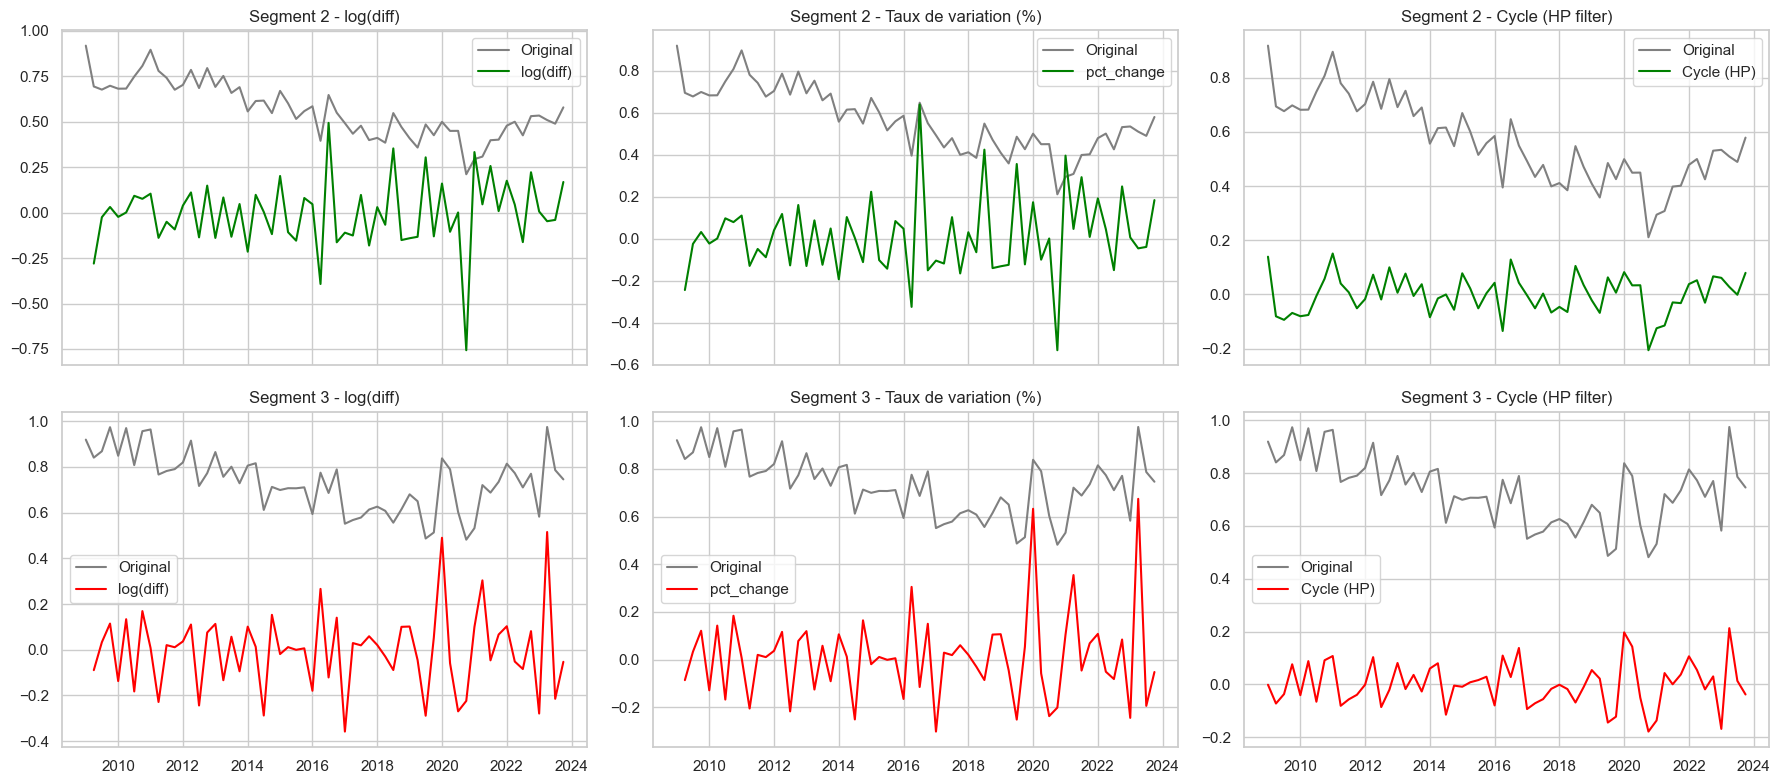

In [ ]:
logdiff_dfs = {}
hp_cycle_dfs = {}
pctchange_dfs = {}

for name in ["segment_2", "segment_3"]:
    df = segments_dfs[name].copy()

    # Méthode log.diff()
    df_logdiff = df[["date", "Indicateur_moyen_Brut"]].copy()
    df_logdiff["log_diff"] = np.log(df_logdiff["Indicateur_moyen_Brut"]).diff()
    logdiff_dfs[name] = df_logdiff.dropna().reset_index(drop=True)

    # Méthode taux de variation classique
    df_pct = df[["date", "Indicateur_moyen_Brut"]].copy()
    df_pct["pct_change"] = df_pct["Indicateur_moyen_Brut"].pct_change()
    pctchange_dfs[name] = df_pct.dropna().reset_index(drop=True)

    # Méthode HP filter
    cycle, trend = hpfilter(df["Indicateur_moyen_Brut"], lamb=1600)
    df_hp = df[["date"]].copy()
    df_hp["cycle"] = cycle
    hp_cycle_dfs[name] = df_hp.reset_index(drop=True)

# Affichage comparatif
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True)

# Segment 2
axes[0, 0].plot(segments_dfs["segment_2"]["date"], segments_dfs["segment_2"]["Indicateur_moyen_Brut"], color="gray", label="Original")
axes[0, 0].plot(logdiff_dfs["segment_2"]["date"], logdiff_dfs["segment_2"]["log_diff"], color="green", label="log(diff)")
axes[0, 0].set_title("Segment 2 - log(diff)")
axes[0, 0].legend()

axes[0, 1].plot(segments_dfs["segment_2"]["date"], segments_dfs["segment_2"]["Indicateur_moyen_Brut"], color="gray", label="Original")
axes[0, 1].plot(pctchange_dfs["segment_2"]["date"], pctchange_dfs["segment_2"]["pct_change"], color="green", label="pct_change")
axes[0, 1].set_title("Segment 2 - Taux de variation (%)")
axes[0, 1].legend()

axes[0, 2].plot(segments_dfs["segment_2"]["date"], segments_dfs["segment_2"]["Indicateur_moyen_Brut"], color="gray", label="Original")
axes[0, 2].plot(hp_cycle_dfs["segment_2"]["date"], hp_cycle_dfs["segment_2"]["cycle"], color="green", label="Cycle (HP)")
axes[0, 2].set_title("Segment 2 - Cycle (HP filter)")
axes[0, 2].legend()

# Segment 3
axes[1, 0].plot(segments_dfs["segment_3"]["date"], segments_dfs["segment_3"]["Indicateur_moyen_Brut"], color="gray", label="Original")
axes[1, 0].plot(logdiff_dfs["segment_3"]["date"], logdiff_dfs["segment_3"]["log_diff"], color="red", label="log(diff)")
axes[1, 0].set_title("Segment 3 - log(diff)")
axes[1, 0].legend()

axes[1, 1].plot(segments_dfs["segment_3"]["date"], segments_dfs["segment_3"]["Indicateur_moyen_Brut"], color="gray", label="Original")
axes[1, 1].plot(pctchange_dfs["segment_3"]["date"], pctchange_dfs["segment_3"]["pct_change"], color="red", label="pct_change")
axes[1, 1].set_title("Segment 3 - Taux de variation (%)")
axes[1, 1].legend()

axes[1, 2].plot(segments_dfs["segment_3"]["date"], segments_dfs["segment_3"]["Indicateur_moyen_Brut"], color="gray", label="Original")
axes[1, 2].plot(hp_cycle_dfs["segment_3"]["date"], hp_cycle_dfs["segment_3"]["cycle"], color="red", label="Cycle (HP)")
axes[1, 2].set_title("Segment 3 - Cycle (HP filter)")
axes[1, 2].legend()

plt.tight_layout()
plt.show()


| Segment   | Meilleure méthode                                           |
| --------- | ----------------------------------------------------------- |
| Segment 2 | **HP filter** ✅ (plus régulier, moins bruité)               |
| Segment 3 | **log(diff)** ✅ (meilleure réactivité, structure conservée) |


#### Après avoir stationnarisé :

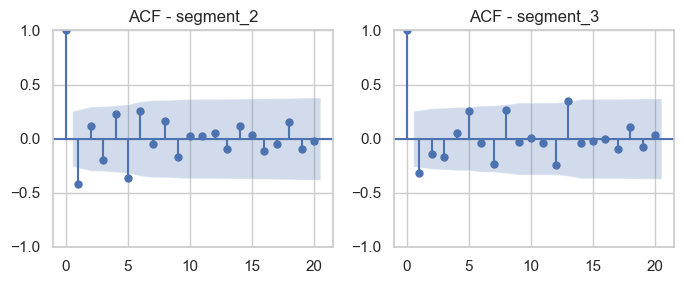

[{'Segment': 'segment_2',
  'ADF Statistic': np.float64(-5.156569647627522),
  'p-value': np.float64(1.0776315886050303e-05),
  'Critique 1%': np.float64(-3.55770911573439),
  'Critique 5%': np.float64(-2.9167703434435808),
  'Critique 10%': np.float64(-2.59622219478738)},
 {'Segment': 'segment_3',
  'ADF Statistic': np.float64(-1.2750328192951388),
  'p-value': np.float64(0.6405160301983306),
  'Critique 1%': np.float64(-3.5778480370438146),
  'Critique 5%': np.float64(-2.925338105429433),
  'Critique 10%': np.float64(-2.6007735310095064)}]

In [ ]:
series_finales = {}

# Segment 2 → log diff
#series_finales["segment_2"] = logdiff_dfs["segment_2"]["log_diff"].dropna()

# Segment 2 → log diff
series_finales["segment_2"] = pctchange_dfs["segment_2"]["pct_change"].dropna()

# Segment 3 → HP cycle
#series_finales["segment_3"] = hp_cycle_dfs["segment_3"]["cycle"].dropna()

# Segment 3 → log diff
#series_finales["segment_3"] = logdiff_dfs["segment_3"]["log_diff"].dropna()

# Segment 3 → log diff
series_finales["segment_3"] = pctchange_dfs["segment_3"]["pct_change"].dropna()

# Calculer ADF et tracer ACF
adf_results = []
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
axes = axes.flatten()

for i, (name, serie) in enumerate(series_finales.items()):
    # ADF test
    try:
        adf = adfuller(serie)
        adf_results.append({
            "Segment": name,
            "ADF Statistic": adf[0],
            "p-value": adf[1],
            "Critique 1%": adf[4]["1%"],
            "Critique 5%": adf[4]["5%"],
            "Critique 10%": adf[4]["10%"]
        })
    except:
        adf_results.append({
            "Segment": name,
            "ADF Statistic": None,
            "p-value": None,
            "Critique 1%": None,
            "Critique 5%": None,
            "Critique 10%": None
        })

    # Plot ACF
    plot_acf(serie, ax=axes[i], lags=20, alpha=0.05)
    axes[i].set_title(f"ACF - {name}")

plt.tight_layout()
plt.show()

display(adf_results) # type: ignore

##### Choisir la méthode de différenciation retenue : 

In [153]:
df_merged = df_merged.iloc[1:].reset_index(drop=True)

#df_merged["Indicateur_moyen_Brut_2"] = logdiff_dfs["segment_2"]["log_diff"].reset_index(drop=True)
#df_merged["Indicateur_moyen_Brut_3"] = pctchange_dfs["segment_3"]["pct_change"].reset_index(drop=True)
#df_merged["Indicateur_moyen_Brut_3"] = hp_cycle_dfs["segment_3"]["cycle"].dropna()

df_merged["Indicateur_moyen_Brut_2_diff"] = hp_cycle_dfs["segment_2"]["cycle"].reset_index(drop=True)
df_merged["Indicateur_moyen_Brut_3_diff"] = logdiff_dfs["segment_3"]["log_diff"].reset_index(drop=True)

# Réattribuer les dates comme index
df_merged["date"] = segments_dfs["segment_1"]["date"].iloc[1:].reset_index(drop=True)
df_merged.set_index("date", inplace=True)

df_merged.head()


Indicateur_moyen_Brut_1  Indicateur_moyen_Brut_2  \
date                                                           
2009-04-01                 0.598795                 0.693970   
2009-07-01                 0.460212                 0.676645   
2009-10-01                 0.431518                 0.697949   
2010-01-01                 0.302710                 0.681718   
2010-04-01                 0.431341                 0.682243   

            Indicateur_moyen_Brut_3  Indicateur_moyen_Brut_4  \
date                                                           
2009-04-01                 0.840965                 0.967390   
2009-07-01                 0.868909                 1.052081   
2009-10-01                 0.974173                 0.936315   
2010-01-01                 0.849149                 1.168515   
2010-04-01                 0.970323                 1.060566   

            Indicateur_moyen_Brut_5  Indicateur_moyen_Brut_6  \
date                                                           
2009-04-01                 1.109015                     1.05   
2009-07-01                 1.083922                     1.05   
2009-10-01                 1.053459                     1.05   
2010-01-01                 1.086222                     1.05   
2010-04-01                 1.048449                     1.05   

            PourcNoteCohorte5_1  PourcNoteCohorte5_2  PourcNoteCohorte5_3  \
date                                                                        
2009-04-01             0.109356             0.254647             0.131660   
2009-07-01             0.100492             0.295740             0.142272   
2009-10-01             0.102461             0.265383             0.130819   
2010-01-01             0.109683             0.255927             0.143388   
2010-04-01             0.119090             0.289894             0.140071   

            PourcNoteCohorte5_4  PourcNoteCohorte5_5  PourcNoteCohorte5_6  \
date                                                                        
2009-04-01             0.101921             0.402416                  0.0   
2009-07-01             0.091207             0.370289                  0.0   
2009-10-01             0.098983             0.402354                  0.0   
2010-01-01             0.103970             0.387032                  0.0   
2010-04-01             0.116135             0.334811                  0.0   

                 PIB       IPL  TCH  Inflation  PIB_diff1  IPL_diff1  \
date                                                                   
2009-04-01 -2.243102 -4.278729  8.8  -0.489570  -0.956314  -2.654313   
2009-07-01 -3.012266 -6.103516  8.8  -0.362976  -0.769164  -1.824787   
2009-10-01 -2.782833 -6.105367  9.2   0.914470   0.229433  -0.001851   
2010-01-01 -1.517665 -4.278209  9.0   1.589859   1.265167   1.827158   
2010-04-01 -0.263588 -1.149425  8.9   1.508021   1.254077   3.128783   

            TCH_diff1  Inflation_diff1  PIB_lag1  IPL_lag1  Inflation_lag1  \
date                                                                         
2009-04-01        0.5        -0.791262 -1.286788 -2.593841       -0.697982   
2009-07-01        0.0         0.126594 -2.243102 -2.654313       -0.791262   
2009-10-01        0.4         1.277447 -3.012266 -1.824787        0.126594   
2010-01-01       -0.2         0.675389 -2.782833 -0.001851        1.277447   
2010-04-01       -0.1        -0.081838 -1.517665  1.827158        0.675389   

            TCH_lag1  Indicateur_moyen_Brut_2_diff  \
date                                                 
2009-04-01       0.9                      0.139372   
2009-07-01       0.5                     -0.080759   
2009-10-01       0.0                     -0.093756   
2010-01-01       0.4                     -0.068248   
2010-04-01      -0.2                     -0.080378   

            Indicateur_moyen_Brut_3_diff  
date                                      
2009-04-01                     -0.089653  
2009-07-01               

## Visualisation série après formatage : 

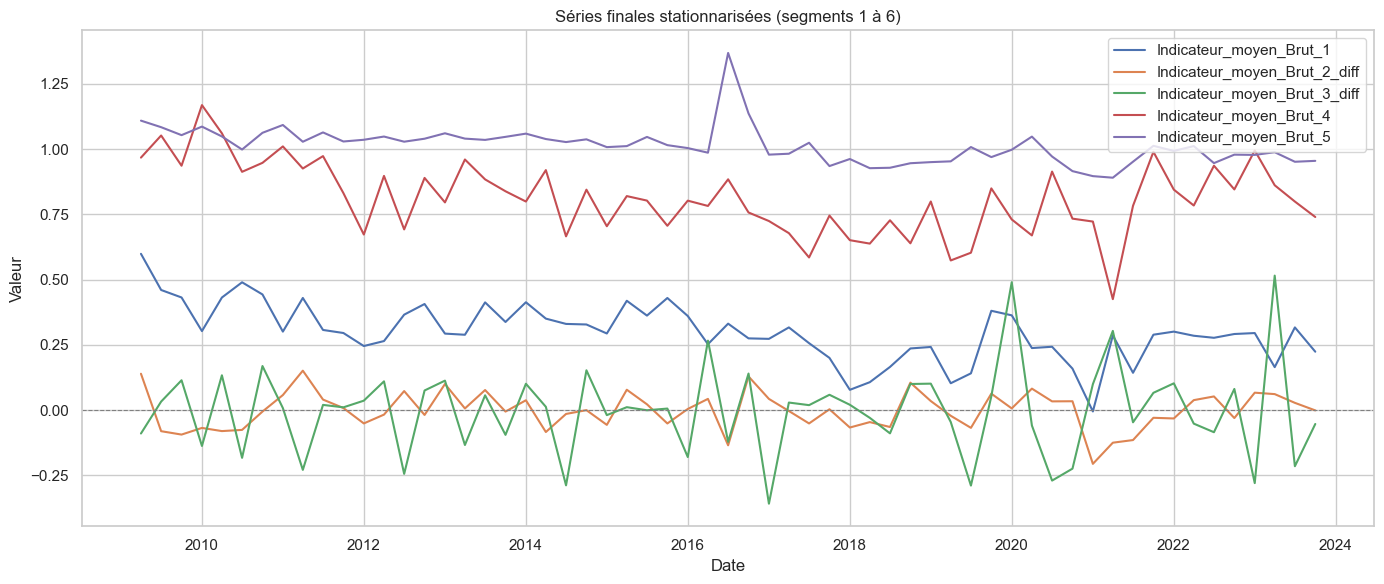

In [154]:
# Recréer les transformations nécessaires pour segment_2 (log diff) et segment_3 (HP cycle)
from statsmodels.tsa.filters.hp_filter import hpfilter

segments = [
    'Indicateur_moyen_Brut_1',
    'Indicateur_moyen_Brut_2_diff',
    'Indicateur_moyen_Brut_3_diff',
    'Indicateur_moyen_Brut_4',
    'Indicateur_moyen_Brut_5'
]

# Tracer toutes les séries sur une même grille
plt.figure(figsize=(14, 6))
for name in segments:
    if name in df_merged.columns:  # Ensure the column exists in df_merged
        plt.plot(df_merged.index, df_merged[name], label=name)

plt.title("Séries finales stationnarisées (segments 1 à 6)")
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.show()


## Corrélation des séries : 

In [155]:
df_merged.drop(columns=["Indicateur_moyen_Brut_6", "PourcNoteCohorte5_6"], inplace=True)

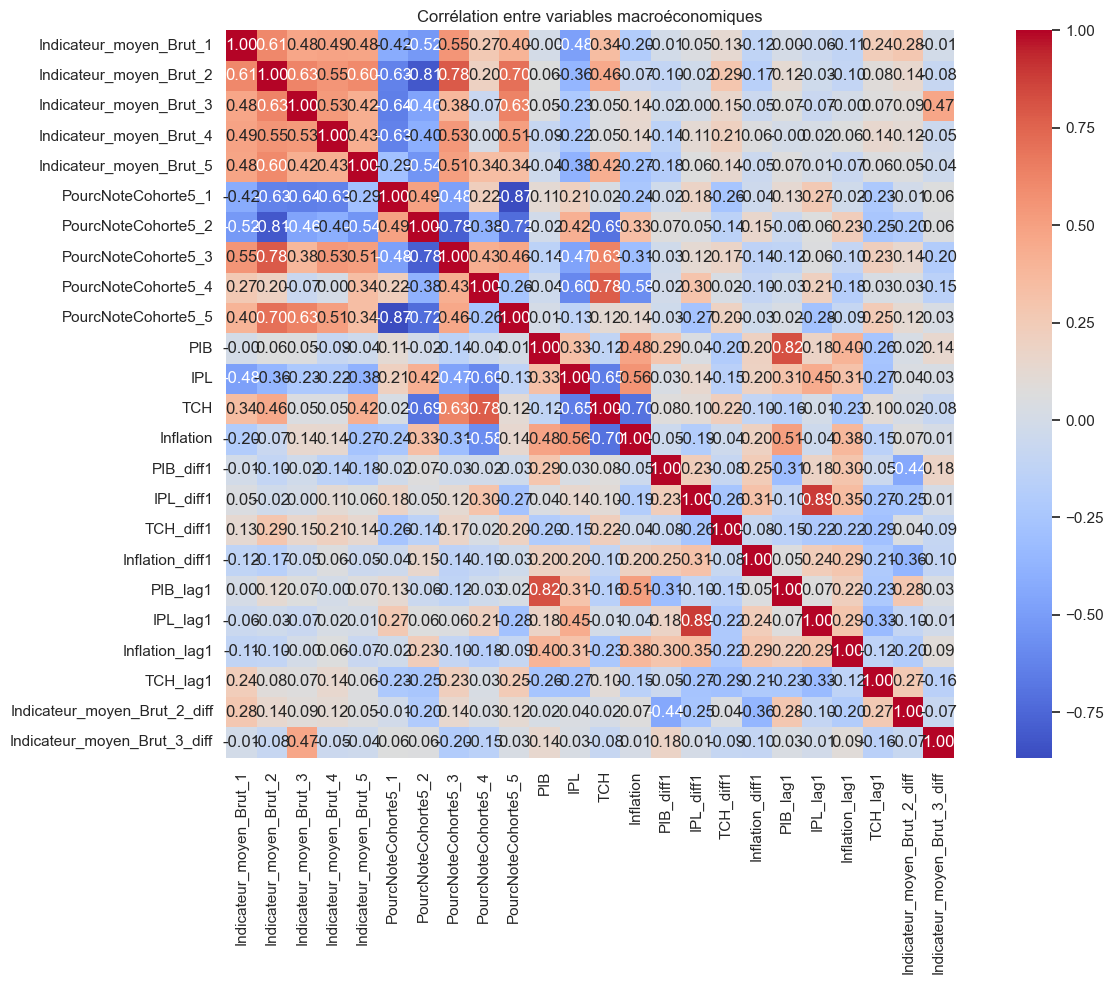

In [156]:
# Calcul de la matrice de corrélation complète
correlation_matrix = df_merged.corr()

# Tracer la heatmap de corrélation
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Corrélation entre variables macroéconomiques")
plt.tight_layout()
plt.show()

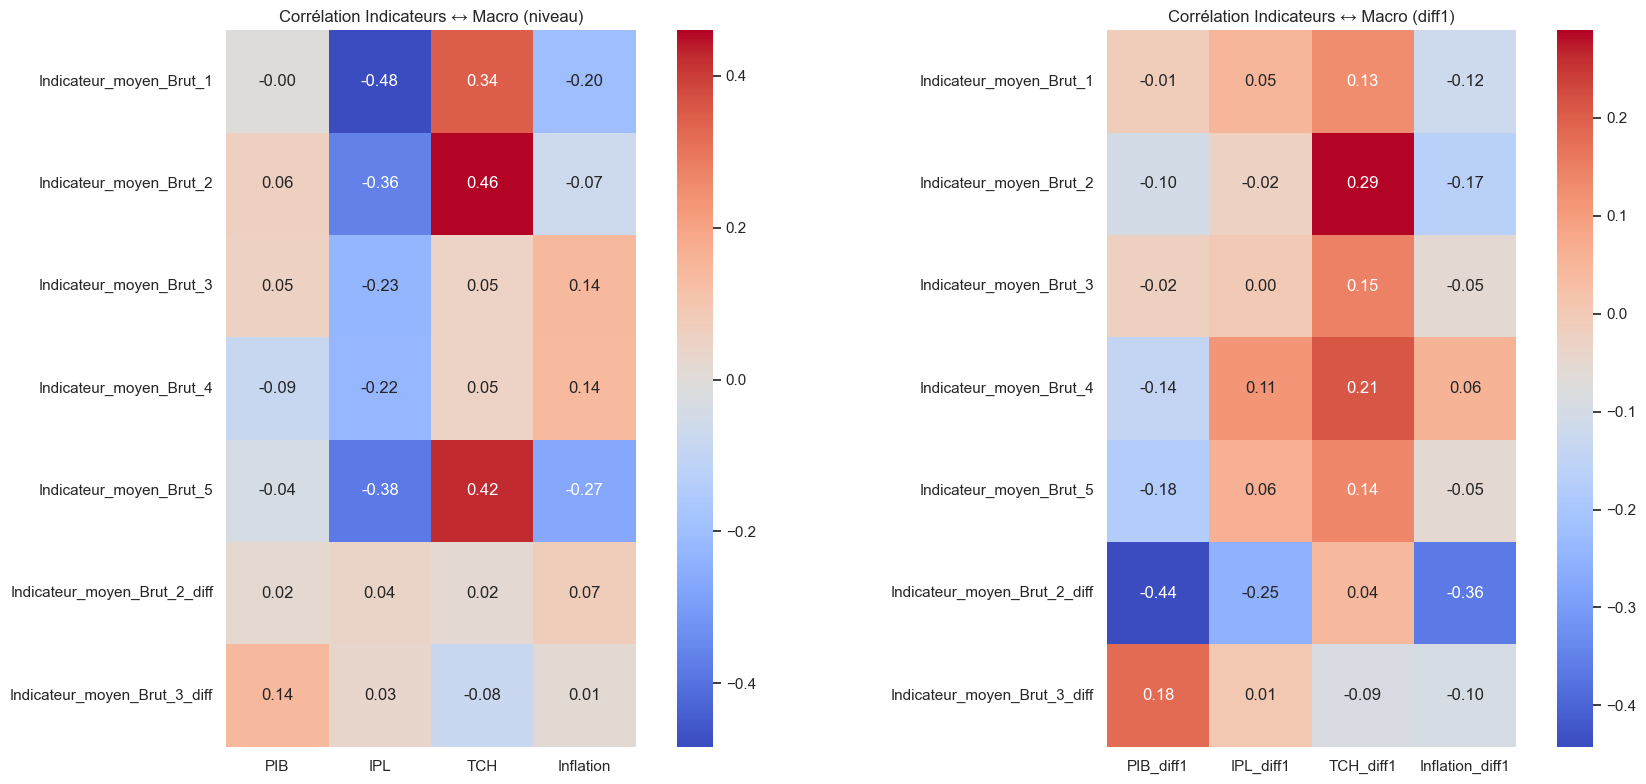

In [157]:
# Sélectionner uniquement les colonnes "Indicateur" et variables macro (niveau + diff1)
cols_indicateur = [col for col in df_merged.columns if col.startswith("Indicateur")]
cols_macro = ["PIB", "IPL", "TCH", "Inflation"]
cols_macro_diff = ["PIB_diff1", "IPL_diff1", "TCH_diff1", "Inflation_diff1"]

# Corrélation entre Indicateurs et valeurs macro
correlation_macro = df_merged[cols_indicateur + cols_macro].corr().loc[cols_indicateur, cols_macro]

# Corrélation entre Indicateurs et variations macro (diff1)
correlation_macro_diff = df_merged[cols_indicateur + cols_macro_diff].corr().loc[cols_indicateur, cols_macro_diff]

# Tracer les deux heatmaps sur des subplots côte à côte
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Corrélation macro niveau
sns.heatmap(correlation_macro, annot=True, fmt=".2f", cmap="coolwarm", square=True, ax=axes[0])
axes[0].set_title("Corrélation Indicateurs ↔ Macro (niveau)")

# Corrélation macro variations (diff1)
sns.heatmap(correlation_macro_diff, annot=True, fmt=".2f", cmap="coolwarm", square=True, ax=axes[1])
axes[1].set_title("Corrélation Indicateurs ↔ Macro (diff1)")

plt.tight_layout()
plt.show()


# Modélisation


In [158]:
df = df_merged.copy()

display(df.head(3))

print(df.info())

Indicateur_moyen_Brut_1  Indicateur_moyen_Brut_2  \
date                                                           
2009-04-01                 0.598795                 0.693970   
2009-07-01                 0.460212                 0.676645   
2009-10-01                 0.431518                 0.697949   

            Indicateur_moyen_Brut_3  Indicateur_moyen_Brut_4  \
date                                                           
2009-04-01                 0.840965                 0.967390   
2009-07-01                 0.868909                 1.052081   
2009-10-01                 0.974173                 0.936315   

            Indicateur_moyen_Brut_5  PourcNoteCohorte5_1  PourcNoteCohorte5_2  \
date                                                                            
2009-04-01                 1.109015             0.109356             0.254647   
2009-07-01                 1.083922             0.100492             0.295740   
2009-10-01                 1.053459             0.102461             0.265383   

            PourcNoteCohorte5_3  PourcNoteCohorte5_4  PourcNoteCohorte5_5  \
date                                                                        
2009-04-01             0.131660             0.101921             0.402416   
2009-07-01             0.142272             0.091207             0.370289   
2009-10-01             0.130819             0.098983             0.402354   

                 PIB       IPL  TCH  Inflation  PIB_diff1  IPL_diff1  \
date                                                                   
2009-04-01 -2.243102 -4.278729  8.8  -0.489570  -0.956314  -2.654313   
2009-07-01 -3.012266 -6.103516  8.8  -0.362976  -0.769164  -1.824787   
2009-10-01 -2.782833 -6.105367  9.2   0.914470   0.229433  -0.001851   

            TCH_diff1  Inflation_diff1  PIB_lag1  IPL_lag1  Inflation_lag1  \
date                                                                         
2009-04-01        0.5        -0.791262 -1.286788 -2.593841       -0.697982   
2009-07-01        0.0         0.126594 -2.243102 -2.654313       -0.791262   
2009-10-01        0.4         1.277447 -3.012266 -1.824787        0.126594   

            TCH_lag1  Indicateur_moyen_Brut_2_diff  \
date                                                 
2009-04-01       0.9                      0.139372   
2009-07-01       0.5                     -0.080759   
2009-10-01       0.0                     -0.093756   

            Indicateur_moyen_Brut_3_diff  
date                                      
2009-04-01                     -0.089653  
2009-07-01                      0.032688  
2009-10-01                      0.114351

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59 entries, 2009-04-01 to 2023-10-01
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Indicateur_moyen_Brut_1       59 non-null     float64
 1   Indicateur_moyen_Brut_2       59 non-null     float64
 2   Indicateur_moyen_Brut_3       59 non-null     float64
 3   Indicateur_moyen_Brut_4       59 non-null     float64
 4   Indicateur_moyen_Brut_5       59 non-null     float64
 5   PourcNoteCohorte5_1           59 non-null     float64
 6   PourcNoteCohorte5_2           59 non-null     float64
 7   PourcNoteCohorte5_3           59 non-null     float64
 8   PourcNoteCohorte5_4           59 non-null     float64
 9   PourcNoteCohorte5_5           59 non-null     float64
 10  PIB                           59 non-null     float64
 11  IPL                           59 non-null     float64
 12  TCH                           59 non-null     

### Test des Cointégration 

In [199]:
vars_i1 = ["TCH", "Inflation", "IPL", "Indicateur_moyen_Brut_2", "Indicateur_moyen_Brut_3"]

results_eg = []

for var1, var2 in combinations(vars_i1, 2):
    series1 = df[var1].dropna()
    series2 = df[var2].dropna()
    common_index = series1.index.intersection(series2.index)
    
    stat, pval, _ = coint(series1.loc[common_index], series2.loc[common_index])
    
    results_eg.append({
        "Série 1": var1,
        "Série 2": var2,
        "Stat cointégration": stat,
        "p-value": pval,
        "Cointégré": pval < 0.05
    })

df_results_eg = pd.DataFrame(results_eg).sort_values("p-value")
df_results_eg


Série 1                  Série 2  Stat cointégration  \
7                      IPL  Indicateur_moyen_Brut_2           -2.921419   
8                      IPL  Indicateur_moyen_Brut_3           -2.423168   
9  Indicateur_moyen_Brut_2  Indicateur_moyen_Brut_3           -1.693440   
4                Inflation                      IPL           -1.460539   
6                Inflation  Indicateur_moyen_Brut_3           -1.405125   
2                      TCH  Indicateur_moyen_Brut_2           -1.309447   
0                      TCH                Inflation           -1.308063   
5                Inflation  Indicateur_moyen_Brut_2           -0.850829   
3                      TCH  Indicateur_moyen_Brut_3           -0.338581   
1                      TCH                      IPL           -0.253517   

    p-value  Cointégré  
7  0.130085      False  
8  0.313962      False  
9  0.679894      False  
4  0.776011      False  
6  0.795751      False  
2  0.826867      False  
0  0.827289      False  
5  0.927688      False  
3  0.974030      False  
1  0.977912      False

In [160]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

results_johansen = []

for group in combinations(vars_i1, 3):  # ou 4 si tu veux
    data = df[list(group)].dropna()
    if len(data) < 30:
        continue

    joh = coint_johansen(data, det_order=0, k_ar_diff=1)
    trace_stats = joh.lr1
    cvt_95 = joh.cvt[:, 1]  # seuils à 5%

    r = sum(trace_stats > cvt_95)

    results_johansen.append({
        "Variables": group,
        "Nombre relations cointégrées (5%)": r
    })

df_results_joh = pd.DataFrame(results_johansen)
df_results_joh


Variables  \
0                                          (TCH, Inflation, IPL)   
1                      (TCH, Inflation, Indicateur_moyen_Brut_2)   
2                      (TCH, Inflation, Indicateur_moyen_Brut_3)   
3                            (TCH, IPL, Indicateur_moyen_Brut_2)   
4                            (TCH, IPL, Indicateur_moyen_Brut_3)   
5        (TCH, Indicateur_moyen_Brut_2, Indicateur_moyen_Brut_3)   
6                      (Inflation, IPL, Indicateur_moyen_Brut_2)   
7                      (Inflation, IPL, Indicateur_moyen_Brut_3)   
8  (Inflation, Indicateur_moyen_Brut_2, Indicateur_moyen_Brut_3)   
9        (IPL, Indicateur_moyen_Brut_2, Indicateur_moyen_Brut_3)   

   Nombre relations cointégrées (5%)  
0                                  1  
1                                  0  
2                                  0  
3                                  1  
4                                  2  
5                                  1  
6                                  1  
7                                  3  
8                                  1  
9                                  2

In [ ]:
variables = ["TCH", "Inflation", "IPL"]
data = df[variables].dropna()

joh = coint_johansen(data, det_order=0, k_ar_diff=1)

# Coefficients de la première (unique) relation cointégrée
beta = joh.evec[:, 0]
print("Coefficients de la combinaison stationnaire :", beta)


Coefficients de la combinaison stationnaire : [0.81854528 0.31618227 0.34479611]


In [162]:
# Créer la combinaison linéaire : Z_t = beta1*TCH + beta2*Inflation + beta3*IPL
df_coint = data.copy()
df["z_coint"] = data.values @ beta  # produit matriciel

# Vérifier stationnarité
from statsmodels.tsa.stattools import adfuller
print("ADF p-value sur la combinaison :", adfuller(df["z_coint"])[1])


ADF p-value sur la combinaison : 0.00019330842336592763


### TEST DES HYPOTHESES DU MCO :

#### Sur les séries CCF :

| Hypothèse                                                | Objectif                                                                            | Comment tester ?                                           | Graphique utile ?                     | Test statistique                  |
| -------------------------------------------------------- | ----------------------------------------------------------------------------------- | ---------------------------------------------------------- | ------------------------------------- | --------------------------------- |
| **1. Linéarité**                                         | La relation entre Y et X est linéaire                                               | - Résidus vs prédictions : doit être aléatoire, sans motif | ✅ OUI (essentiel)                     | Pas nécessaire                    |
| **2. Indépendance des erreurs**                          | Les erreurs ne doivent pas être autocorrélées                                       | - ACF des résidus<br>- Test de Durbin-Watson ≈ 2           | ✅ OUI (utile)                         | ✅ Durbin-Watson                   |
| **3. Homoscédasticité** (variance constante des erreurs) | Pas de structure dans la variance des erreurs                                       | - Résidus vs prédictions : doit être horizontal            | ✅ OUI (essentiel)                     | ✅ Breusch-Pagan                   |
| **4. Normalité des résidus**                             | Les résidus doivent être normalement distribués pour valider les tests statistiques | - Histogramme avec KDE<br>- QQ-plot                        | ✅ OUI (utile)                         | ✅ Shapiro-Wilk<br>✅ Jarque-Bera   |
| **5. Non-colinéarité entre les X**                       | Les variables explicatives ne doivent pas être trop corrélées entre elles           | - Matrice de corrélation<br>- Calcul des VIF               | 🚫 (pas un graphique sur les résidus) | ✅ VIF (Variance Inflation Factor) |


Premier test des hypothèses :

Segment      R²  Adj. R²       AIC       BIC  \
0       Indicateur_moyen_Brut_1  0.2391   0.1174  -95.0617  -76.3639   
1  Indicateur_moyen_Brut_2_diff  0.4601   0.3737 -161.5123 -142.8145   
2  Indicateur_moyen_Brut_3_diff  0.1083  -0.0343  -33.1398  -14.4420   
3       Indicateur_moyen_Brut_4  0.2571   0.1382  -68.5289  -49.8310   
4       Indicateur_moyen_Brut_5  0.1393   0.0016 -142.3560 -123.6581   

   F-statistic  F p-val  Durbin-Watson  const p-val  PIB p-val IPL p-val  \
0       1.9645   0.0707         1.1299       0.0000     0.2708      None   
1       5.3253   0.0001         2.1833       0.5825     0.0264      None   
2       0.7594   0.6395         2.7118       0.7229     0.1993      None   
3       2.1626   0.0467         1.5679       0.0000     0.3713      None   
4       1.0117   0.4395         1.2968       0.0000     0.4416      None   

  Inflation p-val  TCH_diff1 p-val  
0            None           0.0228  
1            None           0.2072  
2            None           0.3725  
3            None           0.0036  
4            None           0.0667

Segment  Durbin-Watson DW Interprétation  \
0       Indicateur_moyen_Brut_1          1.130   Autocorrélation   
1  Indicateur_moyen_Brut_2_diff          2.183                OK   
2  Indicateur_moyen_Brut_3_diff          2.712   Autocorrélation   
3       Indicateur_moyen_Brut_4          1.568                OK   
4       Indicateur_moyen_Brut_5          1.297   Autocorrélation   

   Shapiro p-val Shapiro Interprétation  Jarque-Bera p-val JB Interprétation  
0          0.301                Normaux              0.619           Normaux  
1          0.737                Normaux              0.666           Normaux  
2          0.104                Normaux              0.395           Normaux  
3          0.577                Normaux              0.549           Normaux  
4          0.000            Non normaux              0.000       Non normaux

Segment         Variable   VIF Colinéarité
0        Indicateur_moyen_Brut_1            const  1.16          OK
1        Indicateur_moyen_Brut_1              PIB  3.95          OK
2        Indicateur_moyen_Brut_1        IPL_diff1  6.39      Élevée
3        Indicateur_moyen_Brut_1  Inflation_diff1  1.23          OK
4        Indicateur_moyen_Brut_1        TCH_diff1  1.42          OK
5        Indicateur_moyen_Brut_1         PIB_lag1  3.51          OK
6        Indicateur_moyen_Brut_1         IPL_lag1  5.69      Élevée
7        Indicateur_moyen_Brut_1   Inflation_lag1  1.46          OK
8        Indicateur_moyen_Brut_1         TCH_lag1  1.51          OK
9   Indicateur_moyen_Brut_2_diff            const  1.16          OK
10  Indicateur_moyen_Brut_2_diff              PIB  3.95          OK
11  Indicateur_moyen_Brut_2_diff        IPL_diff1  6.39      Élevée
12  Indicateur_moyen_Brut_2_diff  Inflation_diff1  1.23          OK
13  Indicateur_moyen_Brut_2_diff        TCH_diff1  1.42          OK
14  Indicateur_moyen_Brut_2_diff         PIB_lag1  3.51          OK
15  Indicateur_moyen_Brut_2_diff         IPL_lag1  5.69      Élevée
16  Indicateur_moyen_Brut_2_diff   Inflation_lag1  1.46          OK
17  Indicateur_moyen_Brut_2_diff         TCH_lag1  1.51          OK
18  Indicateur_moyen_Brut_3_diff            const  1.16          OK
19  Indicateur_moyen_Brut_3_diff              PIB  3.95          OK
20  Indicateur_moyen_Brut_3_diff        IPL_diff1  6.39      Élevée
21  Indicateur_moyen_Brut_3_diff  Inflation_diff1  1.23          OK
22  Indicateur_moyen_Brut_3_diff        TCH_diff1  1.42          OK
23  Indicateur_moyen_Brut_3_diff         PIB_lag1  3.51          OK
24  Indicateur_moyen_Brut_3_diff         IPL_lag1  5.69      Élevée
25  Indicateur_moyen_Brut_3_diff   Inflation_lag1  1.46          OK
26  Indicateur_moyen_Brut_3_diff         TCH_lag1  1.51          OK
27       Indicateur_moyen_Brut_4            const  1.16          OK
28       Indicateur_moyen_Brut_4              PIB  3.95          OK
29       Indicateur_moyen_Brut_4        IPL_diff1  6.39      Élevée
30       Indicateur_moyen_Brut_4  Inflation_diff1  1.23          OK
31       Indicateur_moyen_Brut_4        TCH_diff1  1.42          OK
32       Indicateur_moyen_Brut_4         PIB_lag1  3.51          OK
33       Indicateur_moyen_Brut_4         IPL_lag1  5.69      Élevée
34       Indicateur_moyen_Brut_4   Inflation_lag1  1.46          OK
35       Indicateur_moyen_Brut_4         TCH_lag1  1.51          OK
36       Indicateur_moyen_Brut_5            const  1.16          OK
37       Indicateur_moyen_Brut_5              PIB  3.95          OK
38       Indicateur_moyen_Brut_5        IPL_diff1  6.39      Élevée
39       Indicateur_moyen_Brut_5  Inflation_diff1  1.23          OK
40       Indicateur_moyen_Brut_5        TCH_diff1  1.42          OK
41       Indicateur_moyen_Brut_5         PIB_lag1  3.51          OK
42       Indicateur_moyen_Brut_5         IPL_lag1  5.69      Élevée
43       Indicateur_moyen_Brut_5   Inflation_lag1  1.46          OK
44       Indicateur_moyen_Brut_5         TCH_lag1  1.51          OK

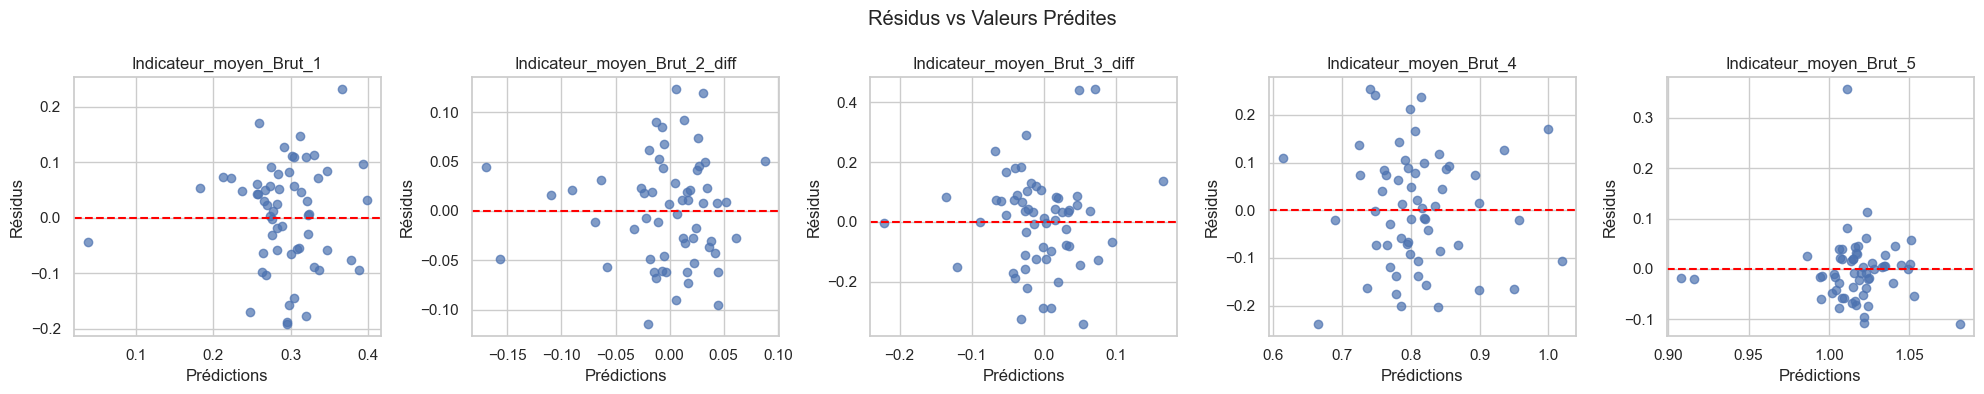

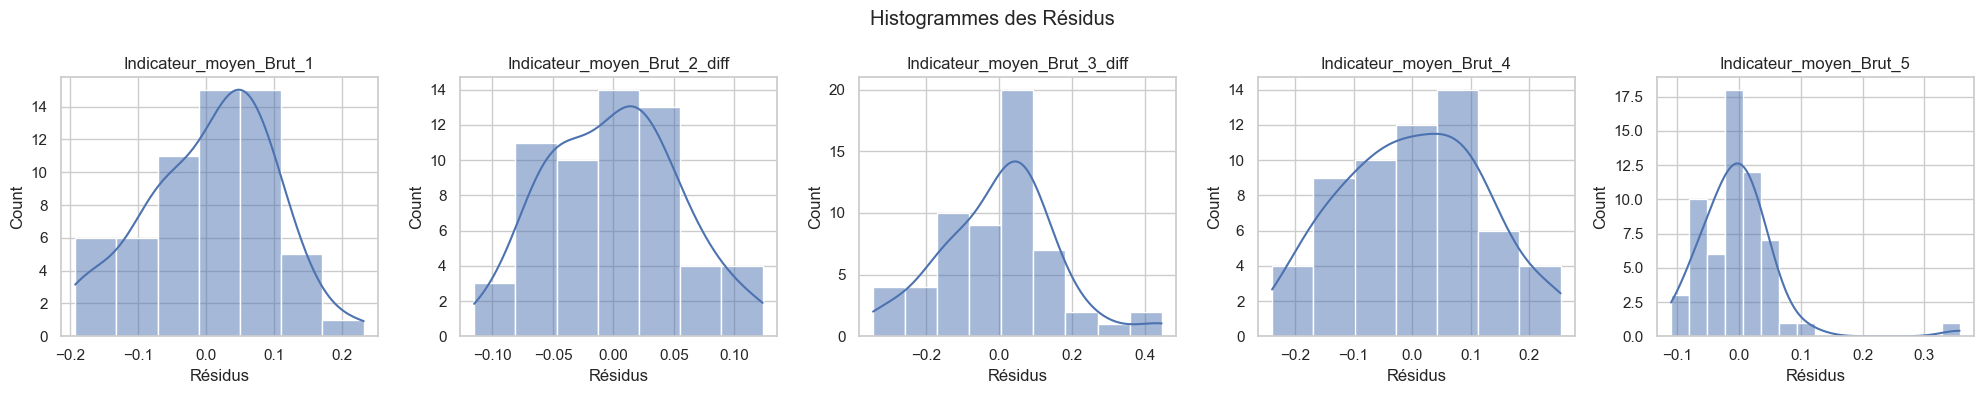

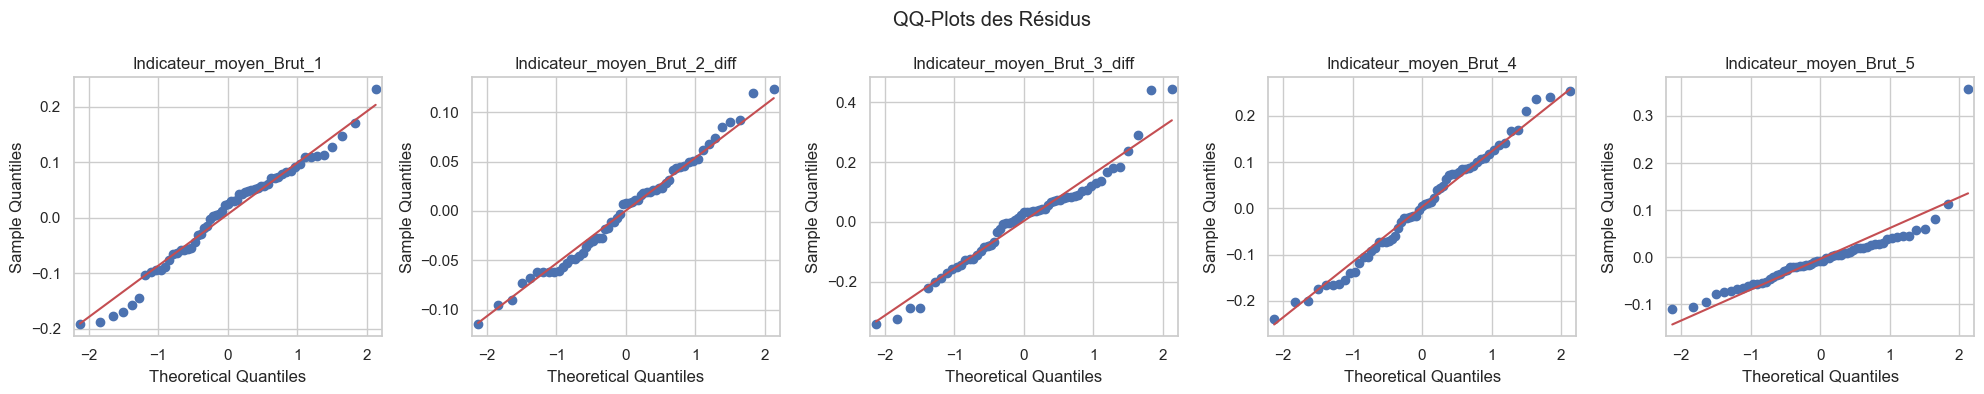

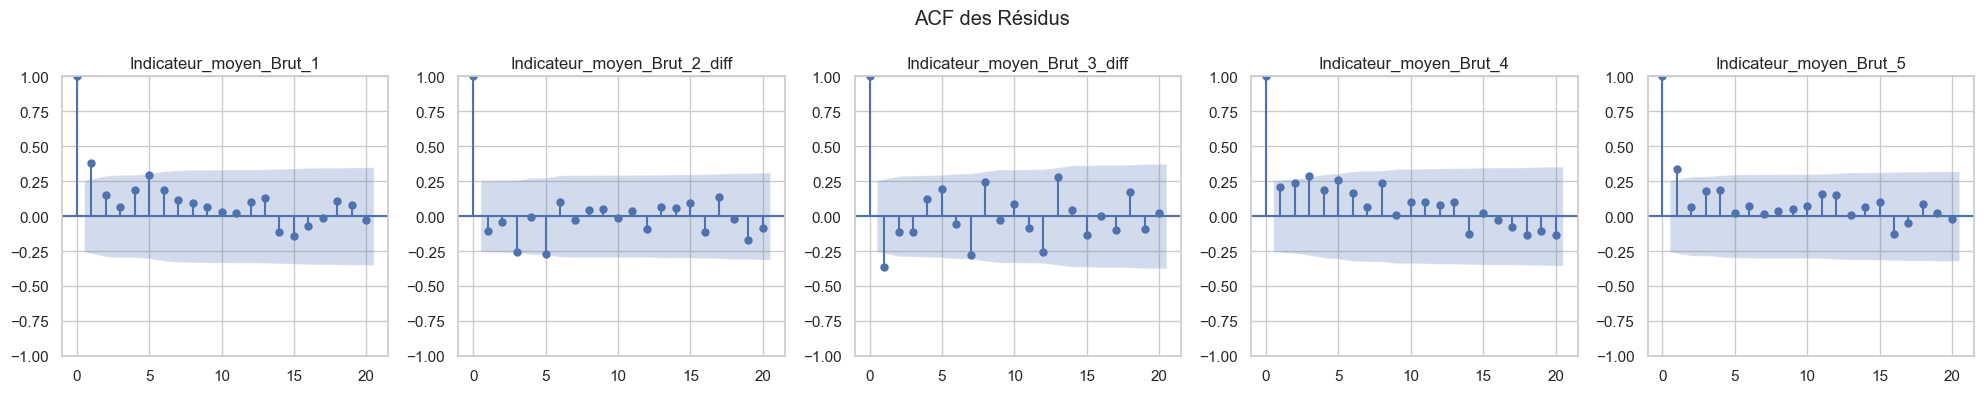

In [163]:
#Variables
macro_vars = ['PIB', 'IPL_diff1', 'Inflation_diff1', 'TCH_diff1', 'PIB_lag1', 'IPL_lag1', 'Inflation_lag1', 'TCH_lag1']

segments = [
    'Indicateur_moyen_Brut_1',
    'Indicateur_moyen_Brut_2_diff',
    'Indicateur_moyen_Brut_3_diff',
    'Indicateur_moyen_Brut_4',
    'Indicateur_moyen_Brut_5'
]

evaluator = WLSModelEvaluator(df, macro_vars, segments)
evaluator.fit_models()
evaluator.display_results()
evaluator.plot_diagnostics()


## Création de variables

In [ ]:
# Dates en datetime
df.index = pd.to_datetime(df.index)
df['year'] = df.index.year
df['quarter'] = df.index.quarter

# === Transformations de base ===
df['PIB_squared'] = df['PIB'] ** 2
df['log_TCH_diff1'] = np.log1p(df['TCH_diff1'].abs())
df['zscore_PIB'] = (df['PIB'] - df['PIB'].mean()) / df['PIB'].std()

# Interactions classiques
df['PIBxIPL'] = df['PIB'] * df['IPL_diff1']
df['PIBxInflation'] = df['PIB'] * df['Inflation_diff1']
df['PIBxTCH'] = df['PIB'] * df['TCH_diff1']
df['IPLxInflation'] = df['IPL_diff1'] * df['Inflation_diff1']
df['IPLxTCH'] = df['IPL_diff1'] * df['TCH_diff1']
df['InflationxTCH'] = df['Inflation_diff1'] * df['TCH_diff1']

# Décalages
df['PIB_lag2'] = df['PIB_lag1'].shift(1)

# Moyennes glissantes
df['TCH_ma3'] = df['TCH_diff1'].rolling(3).mean()
df['Inflation_ma3'] = df['Inflation_diff1'].rolling(3).mean()
df['PIB_ma6'] = df['PIB'].rolling(6).mean()

# Volatilité
df['Inflation_std3'] = df['Inflation_diff1'].rolling(3).std()
df['TCH_volatility'] = df['TCH_diff1'].rolling(5).std()

# Accélérations (variation de la variation)
df['PIB_acc'] = df['PIB'].diff().diff()
df['Inflation_acc'] = df['Inflation_diff1'].diff()
df['TCH_acc'] = df['TCH_diff1'].diff()

# Ratios
df['PIB_to_IPL'] = df['PIB'] / (df['IPL_diff1'].replace(0, np.nan) + 1e-6)
df['TCH_to_Inflation'] = df['TCH_diff1'] / (df['Inflation_diff1'].replace(0, np.nan) + 1e-6)
df['IPL_to_TCH'] = df['IPL_diff1'] / (df['TCH_diff1'].replace(0, np.nan) + 1e-6)

# Écarts à la moyenne
df['PIB_gap_ma3'] = df['PIB'] - df['PIB'].rolling(3).mean()

# Croissances glissantes
df['PIB_growth_3q'] = df['PIB'].pct_change(periods=3)
df['Inflation_growth_3q'] = df['Inflation_diff1'].pct_change(periods=3)

# Indicateurs binaires (contexte éco)
df['recession_flag'] = (df['PIB'] < 0).astype(int)
df['crisis_flag'] = ((df.index >= '2008-09') & (df.index <= '2009-12')).astype(int)
df['pre_covid'] = (df.index < '2020-03').astype(int)

from statsmodels.tsa.filters.hp_filter import hpfilter

df['PIB_cycle'], df['PIB_trend'] = hpfilter(df['PIB'], lamb=1600)

# Pour décomposer les séries en fréquences, isoler les composantes cycliques à haute ou basse fréquence.
freqs = np.fft.fft(df['PIB'].fillna(0))
df['PIB_freq1'] = np.real(freqs[1])  # exemple de signal filtré

df['Inflation_surge'] = (df['Inflation_diff1'] > df['Inflation_diff1'].rolling(4).mean() + 2 * df['Inflation_diff1'].rolling(4).std()).astype(int)

# Composante cyclique (sans carré ou z-score)
df['PIB_cycle'], df['PIB_trend'] = hpfilter(df['PIB'], lamb=1600)

# Moyennes glissantes utiles
df['TCH_ma3'] = df['TCH_diff1'].rolling(3).mean()
df['TCH_volatility'] = df['TCH_diff1'].rolling(5).std()

# La selection suivantes à été basé sur les VIF et la pertinence économique des variables
macro_vars= [
    'PIB_to_IPL',
    'TCH_ma3',
    'Inflation_acc',
    'TCH_volatility',
    'TCH_diff1',
    'PIBxInflation',
    'InflationxTCH',
    'TCH_to_Inflation',
    'IPL_to_TCH',
    'Inflation_growth_3q',
    'recession_flag',
    'pre_covid'
]


segments = [
    'Indicateur_moyen_Brut_1',
    'Indicateur_moyen_Brut_2_diff',
    'Indicateur_moyen_Brut_3_diff',
    'Indicateur_moyen_Brut_4',
    'Indicateur_moyen_Brut_5'
]

# Supprimer les lignes incomplètes
df = df.dropna(subset=segments + macro_vars).copy()

# Nettoyage final
df_filtered = df.dropna(subset=macro_vars).copy()

X = df_filtered[macro_vars]
X_const = add_constant(X)
vif_data = pd.DataFrame()
vif_data['variable'] = X_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

display(vif_data.sort_values(by='VIF', ascending=False))

variable        VIF
0                 const  10.909730
5             TCH_diff1   4.477904
2               TCH_ma3   3.994680
4        TCH_volatility   3.580318
8      TCH_to_Inflation   3.466315
7         InflationxTCH   2.830515
10  Inflation_growth_3q   2.299237
6         PIBxInflation   2.273451
11       recession_flag   2.265583
12            pre_covid   1.925258
3         Inflation_acc   1.393831
9            IPL_to_TCH   1.359147
1            PIB_to_IPL   1.133995

##### TEST HYPOTHESE AVEC TOUTES LES VARIABLES 

Segment      R²  Adj. R²       AIC      BIC  \
0       Indicateur_moyen_Brut_1  0.3648   0.1406  -79.8131 -55.7612   
1  Indicateur_moyen_Brut_2_diff  0.4215   0.2173 -114.8416 -90.7897   
2  Indicateur_moyen_Brut_3_diff  0.2789   0.0243  -21.6985   2.3534   
3       Indicateur_moyen_Brut_4  0.4044   0.1942  -65.0135 -40.9616   
4       Indicateur_moyen_Brut_5  0.3224   0.0832 -108.5543 -84.5023   

   F-statistic  F p-val  Durbin-Watson  const p-val PIB p-val IPL p-val  \
0       1.6273   0.1302         1.4778       0.0000      None      None   
1       2.0644   0.0484         1.9474       0.0385      None      None   
2       1.0956   0.3945         2.6330       0.9906      None      None   
3       1.9238   0.0667         1.6806       0.0000      None      None   
4       1.3479   0.2384         1.4204       0.0000      None      None   

  Inflation p-val  TCH_diff1 p-val  
0            None           0.2140  
1            None           0.0306  
2            None           0.6737  
3            None           0.7533  
4            None           0.3089

Segment  Durbin-Watson DW Interprétation  \
0       Indicateur_moyen_Brut_1          1.478   Autocorrélation   
1  Indicateur_moyen_Brut_2_diff          1.947                OK   
2  Indicateur_moyen_Brut_3_diff          2.633   Autocorrélation   
3       Indicateur_moyen_Brut_4          1.681                OK   
4       Indicateur_moyen_Brut_5          1.420   Autocorrélation   

   Shapiro p-val Shapiro Interprétation  Jarque-Bera p-val JB Interprétation  
0          0.257                Normaux              0.348           Normaux  
1          0.937                Normaux              0.849           Normaux  
2          0.844                Normaux              0.941           Normaux  
3          0.296                Normaux              0.637           Normaux  
4          0.000            Non normaux              0.000       Non normaux

Segment             Variable    VIF Colinéarité
0        Indicateur_moyen_Brut_1                const  10.91      Élevée
1        Indicateur_moyen_Brut_1           PIB_to_IPL   1.13          OK
2        Indicateur_moyen_Brut_1              TCH_ma3   3.99          OK
3        Indicateur_moyen_Brut_1        Inflation_acc   1.39          OK
4        Indicateur_moyen_Brut_1       TCH_volatility   3.58          OK
5        Indicateur_moyen_Brut_1            TCH_diff1   4.48          OK
6        Indicateur_moyen_Brut_1        PIBxInflation   2.27          OK
7        Indicateur_moyen_Brut_1        InflationxTCH   2.83          OK
8        Indicateur_moyen_Brut_1     TCH_to_Inflation   3.47          OK
9        Indicateur_moyen_Brut_1           IPL_to_TCH   1.36          OK
10       Indicateur_moyen_Brut_1  Inflation_growth_3q   2.30          OK
11       Indicateur_moyen_Brut_1       recession_flag   2.27          OK
12       Indicateur_moyen_Brut_1            pre_covid   1.93          OK
13  Indicateur_moyen_Brut_2_diff                const  10.91      Élevée
14  Indicateur_moyen_Brut_2_diff           PIB_to_IPL   1.13          OK
15  Indicateur_moyen_Brut_2_diff              TCH_ma3   3.99          OK
16  Indicateur_moyen_Brut_2_diff        Inflation_acc   1.39          OK
17  Indicateur_moyen_Brut_2_diff       TCH_volatility   3.58          OK
18  Indicateur_moyen_Brut_2_diff            TCH_diff1   4.48          OK
19  Indicateur_moyen_Brut_2_diff        PIBxInflation   2.27          OK
20  Indicateur_moyen_Brut_2_diff        InflationxTCH   2.83          OK
21  Indicateur_moyen_Brut_2_diff     TCH_to_Inflation   3.47          OK
22  Indicateur_moyen_Brut_2_diff           IPL_to_TCH   1.36          OK
23  Indicateur_moyen_Brut_2_diff  Inflation_growth_3q   2.30          OK
24  Indicateur_moyen_Brut_2_diff       recession_flag   2.27          OK
25  Indicateur_moyen_Brut_2_diff            pre_covid   1.93          OK
26  Indicateur_moyen_Brut_3_diff                const  10.91      Élevée
27  Indicateur_moyen_Brut_3_diff           PIB_to_IPL   1.13          OK
28  Indicateur_moyen_Brut_3_diff              TCH_ma3   3.99          OK
29  Indicateur_moyen_Brut_3_diff        Inflation_acc   1.39          OK
30  Indicateur_moyen_Brut_3_diff       TCH_volatility   3.58          OK
31  Indicateur_moyen_Brut_3_diff            TCH_diff1   4.48          OK
32  Indicateur_moyen_Brut_3_diff        PIBxInflation   2.27          OK
33  Indicateur_moyen_Brut_3_diff        InflationxTCH   2.83          OK
34  Indicateur_moyen_Brut_3_diff     TCH_to_Inflation   3.47          OK
35  Indicateur_moyen_Brut_3_diff           IPL_to_TCH   1.36          OK
36  Indicateur_moyen_Brut_3_diff  Inflation_growth_3q   2.30          OK
37  Indicateur_moyen_Brut_3_diff       recession_flag   2.27          OK
38  Indicateur_moyen_Brut_3_diff            pre_covid   1.93          OK
39       Indicateur_moyen_Brut_4                const  10.91      Élevée
40       Indicateur_moyen_Brut_4           PIB_to_IPL   1.13          OK
41       Indicateur_moyen_Brut_4              TCH_ma3   3.99          OK
42       Indicateur_moyen_Brut_4        Inflation_acc   1.39          OK
43       Indicateur_moyen_Brut_4       TCH_volatility   3.58          OK
44       Indicateur_moyen_Brut_4            TCH_diff1   4.48          OK
45       Indicateur_moyen_Brut_4        PIBxInflation   2.27          OK
46       Indicateur_moyen_Brut_4        InflationxTCH   2.83          OK
47       Indicateur_moyen_Brut_4     TCH_to_Inflation   3.47          OK
48       Indicateur_moyen_Brut_4           IPL_to_TCH   1.36          OK
49       Indicateur_moyen_Brut_4  Inflation_growth_3q   2.30          OK
50       Indicateur_moyen_Brut_4       recession_flag   2.27          OK
51       Indicateur_moyen_Brut_4            pre_covid   1.93          OK
52       Indicateur_moyen_Brut_5                const  10.91      Élevée
53       Indicateur_moyen_Brut_5           PIB_to_IPL   1.13          OK
54       I

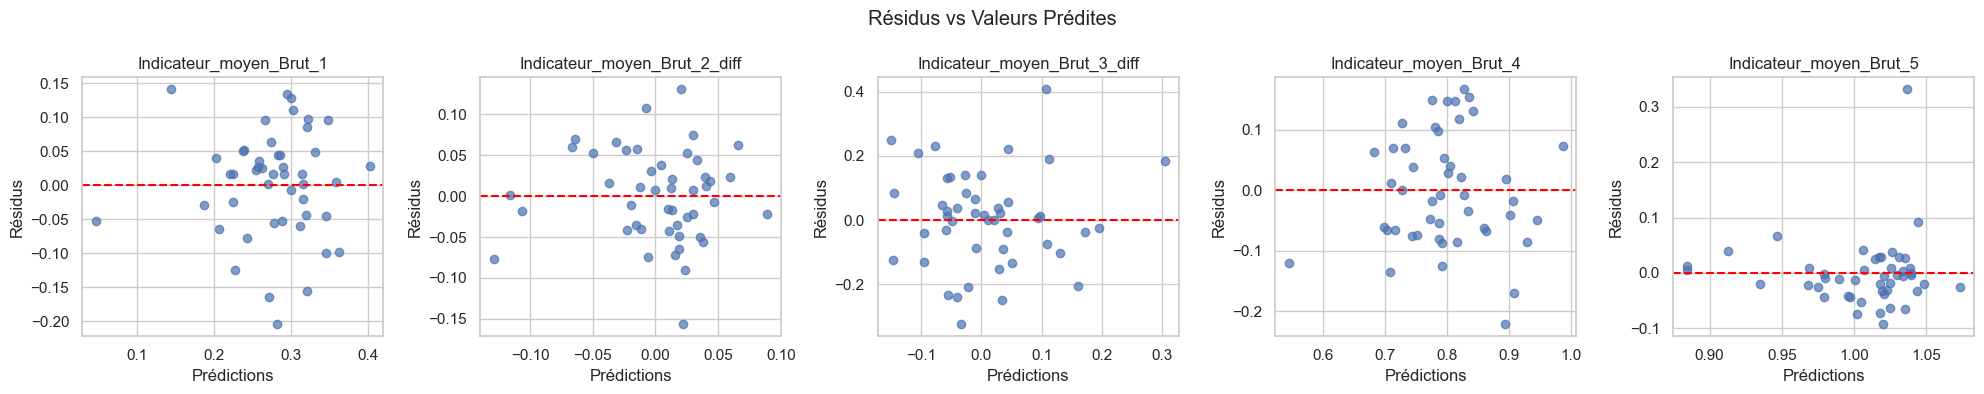

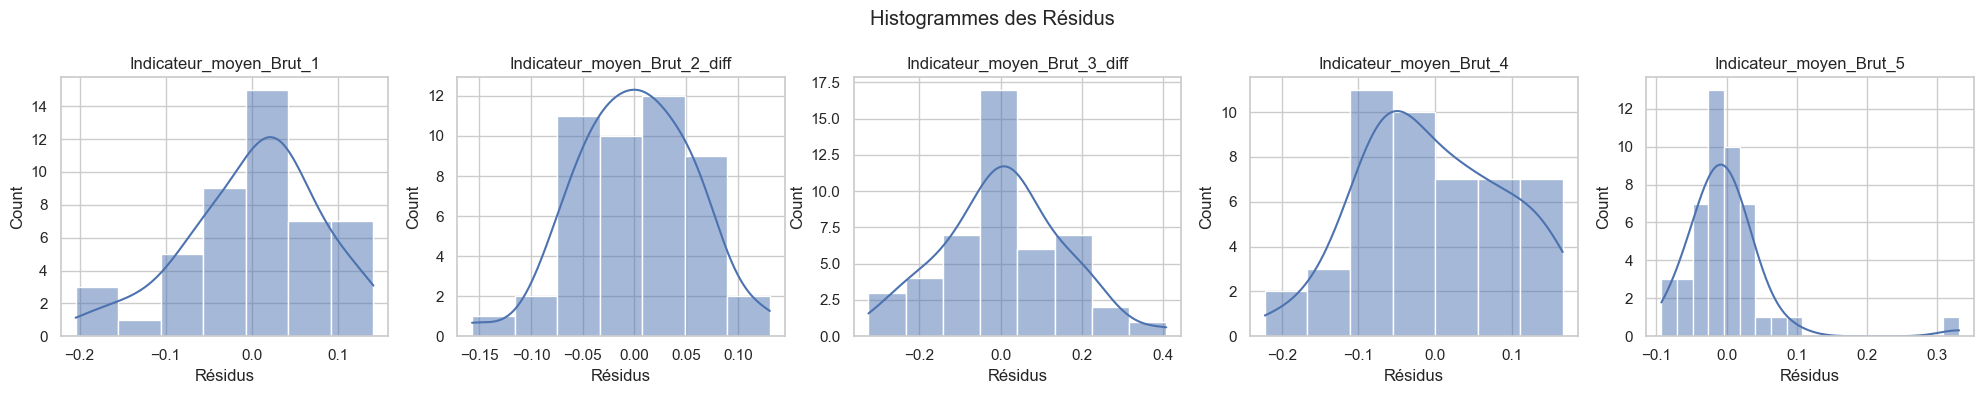

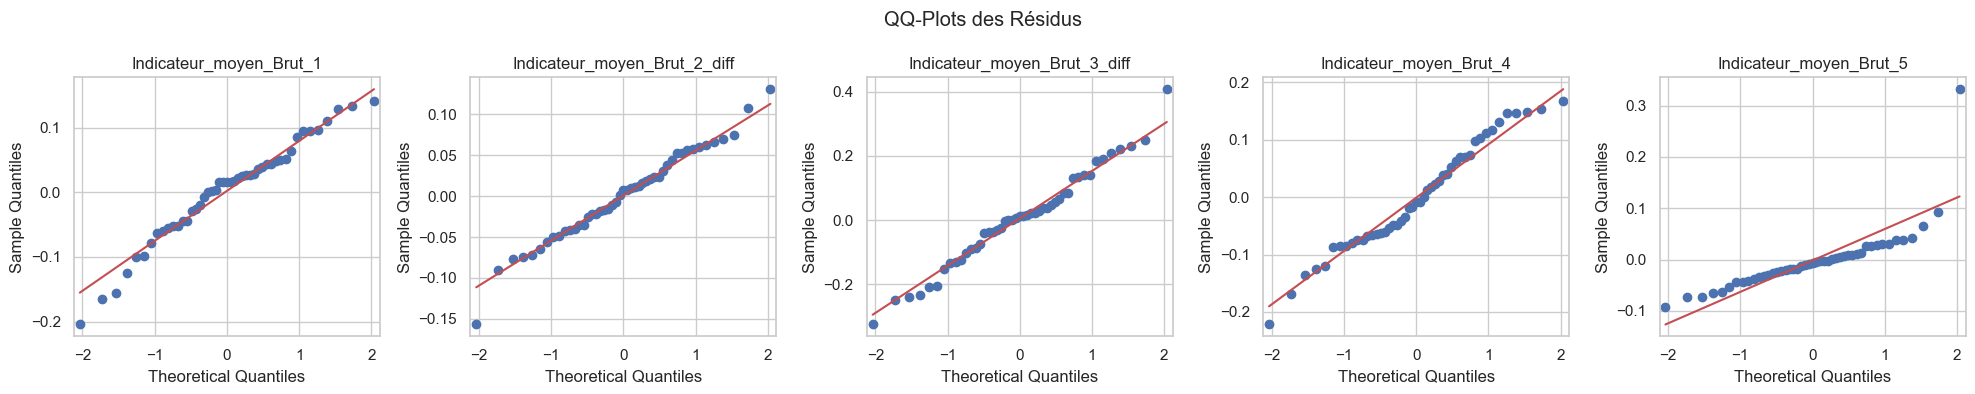

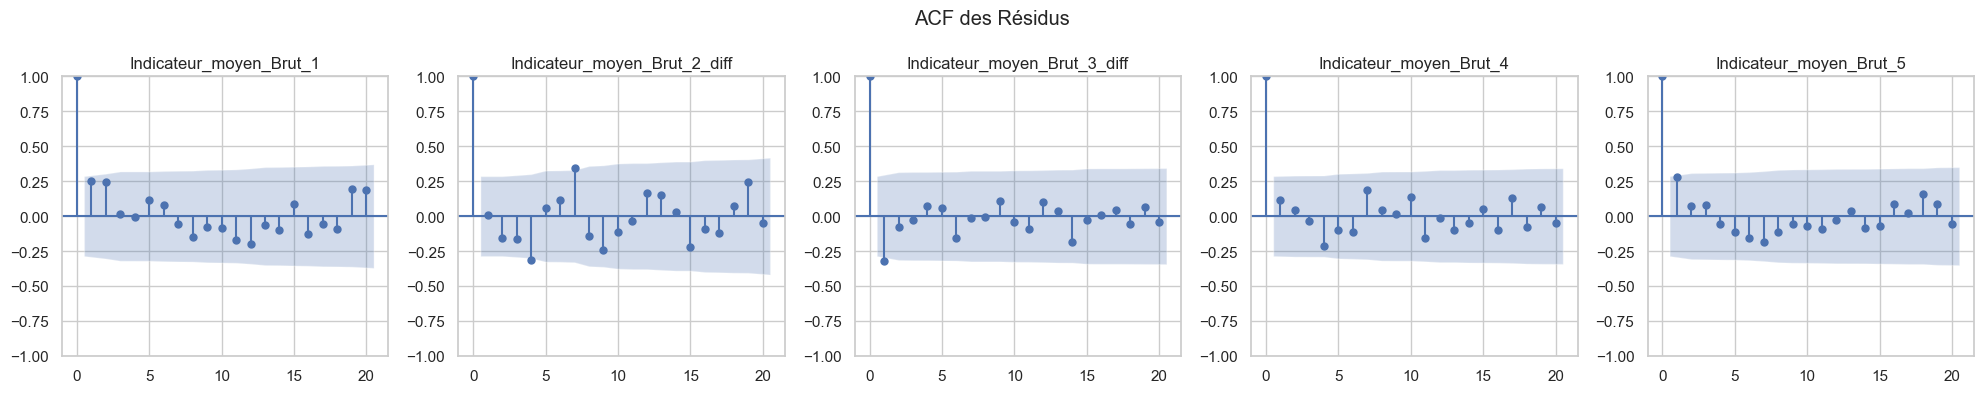

In [165]:
from EvaluatorClass import WLSModelEvaluator

evaluator = WLSModelEvaluator(df, macro_vars, segments)
evaluator.fit_models()
evaluator.display_results()
evaluator.plot_diagnostics()


### Sens Economique : Interprétation des variables retenues : 

 **1. `PIB_to_IPL`**

**Calcul** : `PIB / (IPL_diff1 + 1e-6)`
**Interprétation** : Niveau d'activité économique comparé à l'évolution des prix du logement.
→ Si ce ratio augmente, cela suggère une croissance plus rapide que l’inflation immobilière. Inversement, une baisse peut indiquer une perte de pouvoir d’achat immobilier.

---

 **2. `TCH_ma3`**

**Calcul** : `rolling mean sur 3 périodes de TCH_diff1`

```python
df['TCH_ma3'] = df['TCH_diff1'].rolling(3).mean()
```

**Interprétation** : Tendance de fond du chômage. Sert à lisser les chocs de court terme et capter la dynamique du marché de l’emploi.

---

 **3. `Inflation_acc`**

**Calcul** : `diff(Inflation_diff1)`

```python
df['Inflation_acc'] = df['Inflation_diff1'].diff()
```

**Interprétation** : Accélération ou ralentissement du rythme inflationniste. Un changement rapide signale un choc de prix.

---

 **4. `TCH_volatility`**

**Calcul** : `rolling std sur 5 périodes de TCH_diff1`

```python
df['TCH_volatility'] = df['TCH_diff1'].rolling(5).std()
```

**Interprétation** : Instabilité du chômage. Une volatilité élevée indique une incertitude économique défavorable au crédit.

---

 **5. `TCH_diff1`**

**Calcul** : `variation du taux de chômage` (supposée déjà dans les données)
**Interprétation** : Changement immédiat du chômage, utile pour capter les chocs économiques.

---

 **6. `PIBxInflation`**

**Calcul** : `PIB * Inflation_diff1`

```python
df['PIBxInflation'] = df['PIB'] * df['Inflation_diff1']
```

**Interprétation** : Croissance accompagnée d’inflation (surchauffe) ou non (croissance saine). Interaction non-linéaire.

---

 **7. `InflationxTCH`**

**Calcul** : `Inflation_diff1 * TCH_diff1`

```python
df['InflationxTCH'] = df['Inflation_diff1'] * df['TCH_diff1']
```

**Interprétation** : Permet de détecter des contextes de stagflation (inflation + chômage élevé).

---

 **8. `TCH_to_Inflation`**

**Calcul** : `TCH_diff1 / (Inflation_diff1 + 1e-6)`

```python
df['TCH_to_Inflation'] = df['TCH_diff1'] / (df['Inflation_diff1'].replace(0, np.nan) + 1e-6)
```

**Interprétation** : Ratio entre emploi et pression sur les prix. Donne une mesure du pouvoir d’achat réel.

---

 **9. `IPL_to_TCH`**

**Calcul** : `IPL_diff1 / (TCH_diff1 + 1e-6)`

```python
df['IPL_to_TCH'] = df['IPL_diff1'] / (df['TCH_diff1'].replace(0, np.nan) + 1e-6)
```

**Interprétation** : Si le logement reste cher malgré un chômage élevé, cela peut indiquer une bulle immobilière.

---

 **10. `Inflation_growth_3q`**

**Calcul** : `pct_change(periods=3) de Inflation_diff1`

```python
df['Inflation_growth_3q'] = df['Inflation_diff1'].pct_change(periods=3)
```

**Interprétation** : Croissance moyenne de l'inflation sur 3 trimestres. Permet de capter des régimes inflationnistes persistants.

---

 **11. `recession_flag`**

**Calcul** : `1 si PIB < 0, sinon 0`

```python
df['recession_flag'] = (df['PIB'] < 0).astype(int)
```

**Interprétation** : Périodes de contraction de l’activité économique, associées à une hausse du risque de défaut.

---

 **12. `pre_covid`**

**Calcul** : `1 si date < 2020-03, sinon 0`

```python
df['pre_covid'] = (df.index < '2020-03').astype(int)
```

**Interprétation** : Permet de distinguer l’avant COVID (comportements normaux) de l’après (stress économique et monétaire).


## Selection / Correction des variables pour chaque segment

Test d'un PLS (PCA + regression)

In [ ]:
for i in range(1, 6):

    # Initialisation et entraînement
    pls = PLSRegression(n_components=2)
    X = df[macro_vars]
    y = df[f'Indicateur_moyen_Brut_{i}']
    pls.fit(X, y)

    # Transformation et ajout des composantes
    df['PLS1'] = pls.transform(X)[:, 0]
    df['PLS2'] = pls.transform(X)[:, 1]

    # Prédictions
    y_pred_pls = pls.predict(X)

    # Calcul des sommes des carrés
    ss_residual = np.sum((y - y_pred_pls.ravel()) ** 2)
    ss_total = np.sum((y - np.mean(y)) ** 2)

    # R²
    r2 = 1 - (ss_residual / ss_total)

    print(f"R² du modèle PLS : {r2:.4f}")


R² du modèle PLS : 0.3347
R² du modèle PLS : 0.6278
R² du modèle PLS : 0.5323
R² du modèle PLS : 0.3283
R² du modèle PLS : 0.2862


Segment 5 : Normalité des résidus 

In [167]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor
import statsmodels.api as sm
from sklearn.metrics import r2_score
from scipy.stats import shapiro, jarque_bera

# === Données ===
X = df[macro_vars].copy()
y = df["Indicateur_moyen_Brut_5"]

results = []

# --- 1. Random Forest Regressor ---
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X, y)
y_pred_rf = rf.predict(X)
res_rf = y - y_pred_rf
r2_rf = r2_score(y, y_pred_rf)
shapiro_rf = shapiro(res_rf)
jb_rf = jarque_bera(res_rf)

results.append({
    "Modèle": "Random Forest",
    "R²": round(r2_rf, 4),
    "Shapiro p-val": round(shapiro_rf.pvalue, 4),
    "Shapiro": "Normaux" if shapiro_rf.pvalue > 0.05 else "Non normaux",
    "Jarque-Bera p-val": round(jb_rf.pvalue, 4),
    "Jarque-Bera": "Normaux" if jb_rf.pvalue > 0.05 else "Non normaux"
})

# --- 2. Huber Regressor ---
huber = HuberRegressor()
huber.fit(X, y)
y_pred_huber = huber.predict(X)
res_huber = y - y_pred_huber
r2_huber = r2_score(y, y_pred_huber)
shapiro_h = shapiro(res_huber)
jb_h = jarque_bera(res_huber)

results.append({
    "Modèle": "Huber Regressor",
    "R²": round(r2_huber, 4),
    "Shapiro p-val": round(shapiro_h.pvalue, 4),
    "Shapiro": "Normaux" if shapiro_h.pvalue > 0.05 else "Non normaux",
    "Jarque-Bera p-val": round(jb_h.pvalue, 4),
    "Jarque-Bera": "Normaux" if jb_h.pvalue > 0.05 else "Non normaux"
})

# --- 3. Quantile Regression (q=0.5) ---
mod = sm.QuantReg(y, sm.add_constant(X))
res = mod.fit(q=0.5)
y_pred_qr = res.predict(sm.add_constant(X))
res_qr = y - y_pred_qr
r2_qr = r2_score(y, y_pred_qr)
shapiro_qr = shapiro(res_qr)
jb_qr = jarque_bera(res_qr)

results.append({
    "Modèle": "Quantile Regression (q=0.5)",
    "R²": round(r2_qr, 4),
    "Shapiro p-val": round(shapiro_qr.pvalue, 4),
    "Shapiro": "Normaux" if shapiro_qr.pvalue > 0.05 else "Non normaux",
    "Jarque-Bera p-val": round(jb_qr.pvalue, 4),
    "Jarque-Bera": "Normaux" if jb_qr.pvalue > 0.05 else "Non normaux"
})

# --- Résumé sous forme de DataFrame ---
results_df = pd.DataFrame(results)

# Affichage
display(results_df)


/Users/toninrvr/Documents/MOSEF venv/venv/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Modèle      R²  Shapiro p-val      Shapiro  \
0                Random Forest  0.8519         0.0000  Non normaux   
1              Huber Regressor -0.6644         0.0003  Non normaux   
2  Quantile Regression (q=0.5)  0.2876         0.0000  Non normaux   

   Jarque-Bera p-val  Jarque-Bera  
0                0.0  Non normaux  
1                0.0  Non normaux  
2                0.0  Non normaux

## Modélisation avec selection dynamique des variables

In [168]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

results_model = []
results_modelW = []

for seg in segments:

    X = df[macro_vars].copy()
    X = sm.add_constant(X)
    try : 
        y = df[seg + '_diff']
    except : 
        y = df[seg]
    segment_num = seg.split('_')[3].split('_')[0]
    weights = df[f'PourcNoteCohorte5_{segment_num}']

    best_r2 = -np.inf
    best_model = None
    best_k = None

    best_r2w = -np.inf
    best_modelW = None
    best_kw = None

    for k in range(2, len(macro_vars)):
        corrs = X.drop(columns='const').apply(lambda col: np.corrcoef(col, y)[0, 1])
        X_top_cols = corrs.abs().sort_values(ascending=False).head(k).index.tolist()
        X_top_corr = sm.add_constant(X[X_top_cols], has_constant='add')

        try:
            model = sm.OLS(y, X_top_corr).fit()
            modelW = sm.WLS(y, X_top_corr, weights=weights).fit()
        except:
            continue

        if model.rsquared > best_r2:
            best_r2 = model.rsquared
            best_model = model
            best_k = k

        if modelW.rsquared > best_r2w:
            best_r2w = modelW.rsquared
            best_modelW = modelW
            best_kw = k

    # Stockage des meilleurs résultats OLS
    results_model.append({
        "Segment": seg,
        "Model": "OLS",
        "k": best_k,
        "R2_score": round(best_r2, 4),
        "Coefficients": best_model.params.to_dict()
    })

    # Stockage des meilleurs résultats WLS
    results_modelW.append({
        "Segment": seg,
        "Model": "WLS",
        "k": best_kw,
        "R2_score": round(best_r2w, 4),
        "Coefficients": best_modelW.params.to_dict()
    })

# Fusion des résultats
results_df = pd.DataFrame(results_model)
results_df_W = pd.DataFrame(results_modelW)


In [ ]:
display(results_df)
display(results_df_W)

Segment Model   k  R2_score  \
0       Indicateur_moyen_Brut_1   OLS  11    0.3661   
1  Indicateur_moyen_Brut_2_diff   OLS  11    0.2981   
2  Indicateur_moyen_Brut_3_diff   OLS  11    0.2829   
3       Indicateur_moyen_Brut_4   OLS  11    0.4251   
4       Indicateur_moyen_Brut_5   OLS  11    0.2924   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Coefficients  
0   {'const': 0.2876246716079514, 'TCH_volatility': -0.18183137895993928, 'pre_covid': 0.02774626768814944, 'IPL_to_TCH': -0.0027923151734600277, 'recession_flag': 0.02497709149429128, 'PIBxInflation': 0.009622060596229541, 'Inflation_acc': -0.011543155953896293, 'InflationxTCH': -0.15289874217139174, 'Inflation_growth_3q': -0.008998106008910389, 'PIB_to_IPL': -9.687777550270619e-05, 'TCH_to_Inflation': 0.009394880412685536, 'TCH_diff1': 0.059492500936010155}  
1  {'const': 0.057993906330865014, 'TCH_volatility': -0.17304784416641852, 'Inflation_growth_3q': 0.00031733820110679996, 'recession_flag': 0.0635305879307212, 'pre_covid': -0.011548278533062385, 'Inflation_acc': -0.014966251591426083, 'IPL_to_TCH': 0.002666200466243376, 'TCH_ma3': 0.0020843291558560323, 'TCH_to_Inflation': 0.0029942401962289138, 'PIBxInflation': 0.00174766434786386, 'InflationxTCH': -0.038102691013003696, 'PIB_to_IPL': 8.913184863773136e-06}  
2       {'const': 0.0026137853159244745, 'Inflation_growth_3q': -0.023392465138427826, 'IPL_to_TCH': -0.008876633966216702, 'Inflation_acc': -0.02452248005450706, 'TCH_ma3': -0.14490588464543075, 'recession_flag': -0.09901160643294526, 'TCH_diff1': -0.009452606960547824, 'InflationxTCH': -0.10570588044819634, 'pre_covid': -0.04023199066252705, 'PIB_to_IPL': 0.00012690114094125564, 'TCH_volatility': -0.03363977343097698, 'PIBxInflation': -0.004822168419615212}  
3                 {'const': 0.9226100083629363, 'TCH_ma3': 0.24008112678649707, 'IPL_to_TCH': -0.0014663548498609787, 'TCH_diff1': 0.04836942909329728, 'TCH_volatility': -0.3767623100776285, 'InflationxTCH': -0.4670829842606093, 'Inflation_growth_3q': -0.016632947990245, 'PIBxInflation': 0.004696702629508189, 'PIB_to_IPL': 0.00016059786157918555, 'recession_flag': 0.1545480300469813, 'TCH_to_Inflation': 0.010144022574854986, 'pre_covid': -0.09409680942150972}  
4             {'const': 0.9979186156359499, 'TCH_volatility': -0.09919073331603412, 'pre_covid': 0.0405532155771408, 'IPL_to_TCH': -0.0009495718640574373, 'Inflation_growth_3q': 0.00035135102992140885, 'recession_flag': 0.035497045174816, 'TCH_diff1': 0.027159264140870165, 'TCH_ma3': 0.020902469490787334, 'PIBxInflation': 0.006655270605306969, 'PIB_to_IPL': -6.891897184694369e-05, 'Inflation_acc': -0.0035852278830827006, 'InflationxTCH': 0.052452422750948524}

Segment Model   k  R2_score  \
0       Indicateur_moyen_Brut_1   WLS  11    0.3588   
1  Indicateur_moyen_Brut_2_diff   WLS  11    0.3348   
2  Indicateur_moyen_Brut_3_diff   WLS  11    0.2720   
3       Indicateur_moyen_Brut_4   WLS  11    0.4004   
4       Indicateur_moyen_Brut_5   WLS  11    0.3106   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Coefficients  
0         {'const': 0.29396954179636015, 'TCH_volatility': -0.1968977268121101, 'pre_covid': 0.01813431157006782, 'IPL_to_TCH': -0.002951417448478614, 'recession_flag': 0.02754963452095878, 'PIBxInflation': 0.009075286520401479, 'Inflation_acc': -0.01024493891798431, 'InflationxTCH': -0.17667337289487003, 'Inflation_growth_3q': -0.01053244093091419, 'PIB_to_IPL': -9.132848528223306e-05, 'TCH_to_Inflation': 0.00975378447589489, 'TCH_diff1': 0.06217440065117658}  
1  {'const': 0.05804698933843178, 'TCH_volatility': -0.1807932811685592, 'Inflation_growth_3q': -0.00025463597556545504, 'recession_flag': 0.07222866166057487, 'pre_covid': -0.012168675188114113, 'Inflation_acc': -0.019636607255330077, 'IPL_to_TCH': 0.0027845345708254936, 'TCH_ma3': 0.009927328247453317, 'TCH_to_Inflation': 0.002837035109089116, 'PIBxInflation': 0.0022848267773588012, 'InflationxTCH': -0.05552998056984767, 'PIB_to_IPL': 1.3748571478276403e-05}  
2      {'const': -0.006452442763047447, 'Inflation_growth_3q': -0.023052731008747822, 'IPL_to_TCH': -0.008631278050985333, 'Inflation_acc': -0.026392288072070884, 'TCH_ma3': -0.08557905144333922, 'recession_flag': -0.11045900900155854, 'TCH_diff1': -0.00212314206881159, 'InflationxTCH': -0.050311445529336196, 'pre_covid': -0.03345837230976401, 'PIB_to_IPL': 0.00014476930668712646, 'TCH_volatility': -0.021921593413460054, 'PIBxInflation': -0.002327406801785656}  
3                {'const': 0.9075780800867639, 'TCH_ma3': 0.2607198861844282, 'IPL_to_TCH': -0.002931588063365852, 'TCH_diff1': 0.038698677670004566, 'TCH_volatility': -0.3367056208315673, 'InflationxTCH': -0.4009692959285018, 'Inflation_growth_3q': -0.015313494707988701, 'PIBxInflation': 0.006759791829505103, 'PIB_to_IPL': 0.00015470922390615967, 'recession_flag': 0.13667372619520807, 'TCH_to_Inflation': 0.00871957826810972, 'pre_covid': -0.08813577082447646}  
4            {'const': 0.9960519820319893, 'TCH_volatility': -0.0928769030038134, 'pre_covid': 0.04383084974434931, 'IPL_to_TCH': -0.0008196071686360322, 'Inflation_growth_3q': 0.00038601479483139564, 'recession_flag': 0.033427700023851536, 'TCH_diff1': 0.025611414939042065, 'TCH_ma3': 0.021820756538777464, 'PIBxInflation': 0.006622164728641242, 'PIB_to_IPL': -6.200228785756788e-05, 'Inflation_acc': -0.004278317986586427, 'InflationxTCH': 0.045325334193563854}

## Scénarios :

📅 Prévisions à 3 ans depuis T1 2024 – **Horizon T1 2025 / 2026 / 2027**

| Scénario | Année | PIB  | IPL | TCH  | Inflation |
| -------- | ----- | ---- | --- | ---- | --------- |
| REEL     | 2023  | 1.10 | -2  | 7.5  | 2.4       |
| PESS     | 2024  | -0.6 | -3  | 7.97 | 7.0       |
| CENT     | 2024  | 0.4  | 1   | 7.62 | 1.7       |
| OPTI     | 2024  | 1.5  | 3   | 7.2  | 0.0       |
| PESS     | 2025  | 0.25 | -5  | 8.24 | 5.0       |
| CENT     | 2025  | 0.95 | 2   | 7.7  | 1.78      |
| OPTI     | 2025  | 1.78 | 5   | 6.7  | 0.65      |
| PESS     | 2026  | 1.2  | -7  | 8.4  | 2.0       |
| CENT     | 2026  | 1.34 | 2   | 7.8  | 1.84      |
| OPTI     | 2026  | 1.6  | 7   | 7.0  | 2.1       |

---

 📅 Horizon T2 2025 / 2026 / 2027

| Scénario | Année | PIB    | IPL  | TCH    | Inflation |
| -------- | ----- | ------ | ---- | ------ | --------- |
| REEL     | 2023  | 1.10   | -2   | 7.5    | 2.4       |
| PESS     | 2024  | -0.387 | -3.5 | 8.0375 | 6.5       |
| CENT     | 2024  | 0.5375 | 1.25 | 7.64   | 1.72      |
| OPTI     | 2024  | 1.57   | 3.5  | 7.075  | 0.1625    |
| PESS     | 2025  | 0.4875 | -5.5 | 8.28   | 4.25      |
| CENT     | 2025  | 1.0475 | 2    | 7.725  | 1.795     |
| OPTI     | 2025  | 1.735  | 5.5  | 6.775  | 1.0125    |
| PESS     | 2026  | 1.225  | -6   | 8.3    | 1.975     |
| CENT     | 2026  | 1.355  | 1.75 | 7.725  | 1.88      |
| OPTI     | 2026  | 1.625  | 6    | 7.05   | 2.1       |

---

📅 Horizon T3 2025 / 2026 / 2027

| Scénario | Année | PIB    | IPL | TCH   | Inflation |
| -------- | ----- | ------ | --- | ----- | --------- |
| REEL     | 2023  | 1.10   | -2  | 7.5   | 2.4       |
| PESS     | 2024  | -0.175 | -4  | 8.105 | 6.0       |
| CENT     | 2024  | 0.675  | 1.5 | 7.66  | 1.74      |
| OPTI     | 2024  | 1.64   | 4   | 6.95  | 0.325     |
| PESS     | 2025  | 0.725  | -6  | 8.32  | 3.5       |
| CENT     | 2025  | 1.145  | 2   | 7.75  | 1.81      |
| OPTI     | 2025  | 1.69   | 6   | 6.85  | 1.375     |
| PESS     | 2026  | 1.25   | -5  | 8.2   | 1.95      |
| CENT     | 2026  | 1.37   | 1.5 | 7.65  | 1.92      |
| OPTI     | 2026  | 1.65   | 5   | 7.1   | 2.1       |

---

 📅 Horizon T4 2025 / 2026 / 2027

| Scénario | Année | PIB    | IPL  | TCH    | Inflation |
| -------- | ----- | ------ | ---- | ------ | --------- |
| REEL     | 2023  | 1.10   | -2   | 7.5    | 2.4       |
| PESS     | 2024  | 0.0375 | -4.5 | 8.1725 | 5.5       |
| CENT     | 2024  | 0.8125 | 1.75 | 7.68   | 1.76      |
| OPTI     | 2024  | 1.71   | 4.5  | 6.825  | 0.4875    |£
| PESS     | 2025  | 0.9625 | -6.5 | 8.36   | 2.75      |
| CENT     | 2025  | 1.2425 | 2    | 7.775  | 1.825     |
| OPTI     | 2025  | 1.645  | 6.5  | 6.925  | 1.7375    |
| PESS     | 2026  | 1.275  | -4   | 8.1    | 1.925     |
| CENT     | 2026  | 1.385  | 1.25 | 7.575  | 1.96      |
| OPTI     | 2026  | 1.675  | 4    | 7.15   | 2.1       |

## Prédictions

In [ ]:
# Filtrer les colonnes et les lignes pour l'année 2023
df_2023 = df.loc[df['year'] == 2023, ['PIB', 'IPL', 'TCH', 'Inflation']]

print(df_2023)

                 PIB       IPL  TCH  Inflation
date                                          
2023-01-01  1.687226  5.190174  6.9   5.701873
2023-04-01  1.061365  3.664003  7.0   4.531319
2023-07-01  0.876149  1.650038  7.2   4.896221
2023-10-01  0.868858 -0.455149  7.3   3.705326


In [171]:
# Reconstruction des scénarios avec trimestres (T1 à T4) pour les années 2024 à 2026
scenarios_by_quarter = {
    "T1": {
        "PESS": {
            2024: {"PIB": -0.6, "IPL": -3, "TCH": 7.97, "Inflation": 7.0},
            2025: {"PIB": 0.25, "IPL": -5, "TCH": 8.24, "Inflation": 5.0},
            2026: {"PIB": 1.2, "IPL": -7, "TCH": 8.4, "Inflation": 2.0}
        },
        "CENT": {
            2024: {"PIB": 0.4, "IPL": 1, "TCH": 7.62, "Inflation": 1.7},
            2025: {"PIB": 0.95, "IPL": 2, "TCH": 7.7, "Inflation": 1.78},
            2026: {"PIB": 1.34, "IPL": 2, "TCH": 7.8, "Inflation": 1.84}
        },
        "OPTI": {
            2024: {"PIB": 1.5, "IPL": 3, "TCH": 7.2, "Inflation": 0.0},
            2025: {"PIB": 1.78, "IPL": 5, "TCH": 6.7, "Inflation": 0.65},
            2026: {"PIB": 1.6, "IPL": 7, "TCH": 7.0, "Inflation": 2.1}
        }
    },
    "T2": {
        "PESS": {
            2024: {"PIB": -0.387, "IPL": -3.5, "TCH": 8.0375, "Inflation": 6.5},
            2025: {"PIB": 0.4875, "IPL": -5.5, "TCH": 8.28, "Inflation": 4.25},
            2026: {"PIB": 1.225, "IPL": -6, "TCH": 8.3, "Inflation": 1.975}
        },
        "CENT": {
            2024: {"PIB": 0.5375, "IPL": 1.25, "TCH": 7.64, "Inflation": 1.72},
            2025: {"PIB": 1.0475, "IPL": 2, "TCH": 7.725, "Inflation": 1.795},
            2026: {"PIB": 1.355, "IPL": 1.75, "TCH": 7.725, "Inflation": 1.88}
        },
        "OPTI": {
            2024: {"PIB": 1.57, "IPL": 3.5, "TCH": 7.075, "Inflation": 0.1625},
            2025: {"PIB": 1.735, "IPL": 5.5, "TCH": 6.775, "Inflation": 1.0125},
            2026: {"PIB": 1.625, "IPL": 6, "TCH": 7.05, "Inflation": 2.1}
        }
    },
    "T3": {
        "PESS": {
            2024: {"PIB": -0.175, "IPL": -4, "TCH": 8.105, "Inflation": 6.0},
            2025: {"PIB": 0.725, "IPL": -6, "TCH": 8.32, "Inflation": 3.5},
            2026: {"PIB": 1.25, "IPL": -5, "TCH": 8.2, "Inflation": 1.95}
        },
        "CENT": {
            2024: {"PIB": 0.675, "IPL": 1.5, "TCH": 7.66, "Inflation": 1.74},
            2025: {"PIB": 1.145, "IPL": 2, "TCH": 7.75, "Inflation": 1.81},
            2026: {"PIB": 1.37, "IPL": 1.5, "TCH": 7.65, "Inflation": 1.92}
        },
        "OPTI": {
            2024: {"PIB": 1.64, "IPL": 4, "TCH": 6.95, "Inflation": 0.325},
            2025: {"PIB": 1.69, "IPL": 6, "TCH": 6.85, "Inflation": 1.375},
            2026: {"PIB": 1.65, "IPL": 5, "TCH": 7.1, "Inflation": 2.1}
        }
    },
    "T4": {
        "PESS": {
            2024: {"PIB": 0.0375, "IPL": -4.5, "TCH": 8.1725, "Inflation": 5.5},
            2025: {"PIB": 0.9625, "IPL": -6.5, "TCH": 8.36, "Inflation": 2.75},
            2026: {"PIB": 1.275, "IPL": -4, "TCH": 8.1, "Inflation": 1.925}
        },
        "CENT": {
            2024: {"PIB": 0.8125, "IPL": 1.75, "TCH": 7.68, "Inflation": 1.76},
            2025: {"PIB": 1.2425, "IPL": 2, "TCH": 7.775, "Inflation": 1.825},
            2026: {"PIB": 1.385, "IPL": 1.25, "TCH": 7.575, "Inflation": 1.96}
        },
        "OPTI": {
            2024: {"PIB": 1.71, "IPL": 4.5, "TCH": 6.825, "Inflation": 0.4875},
            2025: {"PIB": 1.645, "IPL": 6.5, "TCH": 6.925, "Inflation": 1.7375},
            2026: {"PIB": 1.675, "IPL": 4, "TCH": 7.15, "Inflation": 2.1}
        }
    }
}

# Display only to confirm structure
scenarios_by_quarter.keys()


dict_keys(['T1', 'T2', 'T3', 'T4'])

In [ ]:
# Dernières valeurs macro observées en 2023
#last_real = {"PIB": 1.10, "IPL": -2, "TCH": 7.5, "Inflation": 2.4}

last_real = {"PIB": 0.868858, "IPL": -0.455149, "TCH": 7.3, "Inflation": 3.705326}      

# Lancer les projections
projection_rows = []

for _, row in results_df.iterrows():
    segment = row["Segment"]
    coefs = row["Coefficients"]
    
    for trimestre, scenarios in scenarios_by_quarter.items():
        for scenario, year_data in scenarios.items():
            prev = last_real.copy()
            for year, values in year_data.items():
                PIB_diff1 = values["PIB"] - prev["PIB"]
                IPL_diff1 = values["IPL"] - prev["IPL"]
                TCH_diff1 = values["TCH"] - prev["TCH"]
                Inflation_diff1 = values["Inflation"] - prev["Inflation"]

                PIB_lag1 = prev["PIB"]
                IPL_lag1 = prev["IPL"]
                TCH_lag1 = prev["TCH"]
                Inflation_lag1 = prev["Inflation"]

                # Prédiction à partir des coefficients
                y_pred = (
                    coefs.get("const", 0)
                    + coefs.get("PIB_diff1", 0) * PIB_diff1
                    + coefs.get("IPL_diff1", 0) * IPL_diff1
                    + coefs.get("TCH_diff1", 0) * TCH_diff1
                    + coefs.get("Inflation_diff1", 0) * Inflation_diff1
                    + coefs.get("PIB_lag1", 0) * PIB_lag1
                    + coefs.get("IPL_lag1", 0) * IPL_lag1
                    + coefs.get("TCH_lag1", 0) * TCH_lag1
                    + coefs.get("Inflation_lag1", 0) * Inflation_lag1
                )

                projection_rows.append({
                    "Segment": segment,
                    "Scénario": scenario,
                    "Année": year,
                    "Trimestre": trimestre,
                    "Prévision_CCF": round(y_pred, 4)
                })

                prev = values  # mise à jour pour l’année suivante

# DataFrame final des prévisions
projection_df = pd.DataFrame(projection_rows)

projection_df.head()


Segment Scénario  Année Trimestre  Prévision_CCF
0  Indicateur_moyen_Brut_1     PESS   2024        T1         0.3275
1  Indicateur_moyen_Brut_1     PESS   2025        T1         0.3037
2  Indicateur_moyen_Brut_1     PESS   2026        T1         0.2971
3  Indicateur_moyen_Brut_1     CENT   2024        T1         0.3067
4  Indicateur_moyen_Brut_1     CENT   2025        T1         0.2924

#### Version des projections pour le GRANDIENT BOOSTING : 

In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor

# gb_models = {}

# for target in segments:
#     data = df.dropna(subset=macro_vars + [target])
#     X = df[[
#     "PIB_diff1", "IPL_diff1", "TCH_diff1", "Inflation_diff1",
#     "PIB_lag1", "IPL_lag1", "TCH_lag1", "Inflation_lag1"
# ]]

#     y = data[target]

#     model = GradientBoostingRegressor().fit(X, y)
#     gb_models[target] = model


# # Dernières valeurs macro observées
# last_real = {"PIB": 0.868858, "IPL": -0.455149, "TCH": 7.3, "Inflation": 3.705326}

# projection_rows = []

# for segment, model in gb_models.items():
#     for trimestre, scenarios in scenarios_by_quarter.items():
#         for scenario, year_data in scenarios.items():
#             prev = last_real.copy()
#             for year, values in year_data.items():
#                 # Créer X_macro avec les 8 variables nécessaires
#                 X_macro = pd.DataFrame([{
#                     "PIB_diff1": values["PIB"] - prev["PIB"],
#                     "IPL_diff1": values["IPL"] - prev["IPL"],
#                     "TCH_diff1": values["TCH"] - prev["TCH"],
#                     "Inflation_diff1": values["Inflation"] - prev["Inflation"],
#                     "PIB_lag1": prev["PIB"],
#                     "IPL_lag1": prev["IPL"],
#                     "TCH_lag1": prev["TCH"],
#                     "Inflation_lag1": prev["Inflation"],
#                 }])

#                 y_pred = model.predict(X_macro)[0]

#                 projection_rows.append({
#                     "Segment": segment,
#                     "Scénario": scenario,
#                     "Année": year,
#                     "Trimestre": trimestre,
#                     "Prévision_CCF": round(y_pred, 4)
#                 })

#                 prev = values  # mise à jour des lags


# projection_df = pd.DataFrame(projection_rows)

# projection_df.head()


Segment Scénario  Année Trimestre  Prévision_CCF
0  Indicateur_moyen_Brut_1     PESS   2024        T1         0.2609
1  Indicateur_moyen_Brut_1     PESS   2025        T1         0.2267
2  Indicateur_moyen_Brut_1     PESS   2026        T1         0.2267
3  Indicateur_moyen_Brut_1     CENT   2024        T1         0.2006
4  Indicateur_moyen_Brut_1     CENT   2025        T1         0.2791

In [192]:
df.head()

Indicateur_moyen_Brut_1  Indicateur_moyen_Brut_2  \
date                                                           
2010-04-01                 0.431341                 0.682243   
2010-10-01                 0.443123                 0.807215   
2011-04-01                 0.429666                 0.779756   
2011-07-01                 0.307091                 0.741465   
2011-10-01                 0.295404                 0.675997   

            Indicateur_moyen_Brut_3  Indicateur_moyen_Brut_4  \
date                                                           
2010-04-01                 0.970323                 1.060566   
2010-10-01                 0.956822                 0.947348   
2011-04-01                 0.766935                 0.925612   
2011-07-01                 0.782408                 0.973101   
2011-10-01                 0.790761                 0.831338   

            Indicateur_moyen_Brut_5  PourcNoteCohorte5_1  PourcNoteCohorte5_2  \
date                                                                            
2010-04-01                 1.048449             0.119090             0.289894   
2010-10-01                 1.062386             0.136285             0.253594   
2011-04-01                 1.028178             0.133870             0.215903   
2011-07-01                 1.063895             0.136656             0.216029   
2011-10-01                 1.029133             0.133908             0.222419   

            PourcNoteCohorte5_3  PourcNoteCohorte5_4  PourcNoteCohorte5_5  \
date                                                                        
2010-04-01             0.140071             0.116135             0.334811   
2010-10-01             0.132835             0.110983             0.366302   
2011-04-01             0.145445             0.099899             0.404882   
2011-07-01             0.154637             0.080658             0.412022   
2011-10-01             0.133655             0.080903             0.429115   

                 PIB       IPL  TCH  Inflation  PIB_diff1  IPL_diff1  \
date                                                                   
2010-04-01 -0.263588 -1.149425  8.9   1.508021   1.254077   3.128783   
2010-10-01  1.799343  4.640797  8.8   1.759062   0.706346   2.560714   
2011-04-01  2.339377  6.459948  8.7   2.107260   0.140557   0.474585   
2011-07-01  2.301174  6.469689  8.8   2.236523  -0.038203   0.009741   
2011-10-01  2.229597  5.687798  9.0   2.462022  -0.071577  -0.781892   

            TCH_diff1  Inflation_diff1  PIB_lag1  IPL_lag1  Inflation_lag1  \
date                                                                         
2010-04-01       -0.1        -0.081838 -1.517665  1.827158        0.675389   
2010-10-01       -0.1         0.194720  1.092998  3.229508        0.056320   
2011-04-01       -0.1         0.119314  2.198821  1.344566        0.228884   
2011-07-01        0.1         0.129263  2.339377  0.474585        0.119314   
2011-10-01        0.2         0.225499  2.301174  0.009741        0.129263   

            TCH_lag1  Indicateur_moyen_Brut_2_diff  \
date                                                 
2010-04-01      -0.2                     -0.080378   
2010-10-01       0.0                     -0.005600   
2011-04-01       0.0                      0.151141   
2011-07-01      -0.1                      0.040361   
2011-10-01       0.1                      0.007964   

            Indicateur_moyen_Brut_3_diff    z_coint  year  quarter  \
date                                                                 
2010-04-01                      0.133395   7.365545  2010        2   
2010-10-01                      0.168870   9.359511  2010        4   
2011-04-01                     -0.228982  10.014987  2011        2   
2011-07-01                      0.019974  10.141071  2011        3   
2011-10-01                      0.010619  10.106486  2011        4   

            PIB_squared  log_TCH_diff1  zscore_PIB   PIBxIPL  PIBxInflation  \
date 

In [200]:
# Restructurer les données historiques
df_real_melted = df.reset_index().melt(id_vars='date', 
                                            var_name="Segment", 
                                            value_name="Valeur_réelle")
df_real_melted["Année"] = df_real_melted["date"].dt.year
df_real_melted["Trimestre"] = "T" + df_real_melted["date"].dt.quarter.astype(str)
df_real_melted["Période"] = df_real_melted["Année"].astype(str) + "-" + df_real_melted["Trimestre"]

df_real_melted.head()

date                  Segment  Valeur_réelle  Année Trimestre  Période
0 2010-04-01  Indicateur_moyen_Brut_1       0.431341   2010        T2  2010-T2
1 2010-10-01  Indicateur_moyen_Brut_1       0.443123   2010        T4  2010-T4
2 2011-04-01  Indicateur_moyen_Brut_1       0.429666   2011        T2  2011-T2
3 2011-07-01  Indicateur_moyen_Brut_1       0.307091   2011        T3  2011-T3
4 2011-10-01  Indicateur_moyen_Brut_1       0.295404   2011        T4  2011-T4

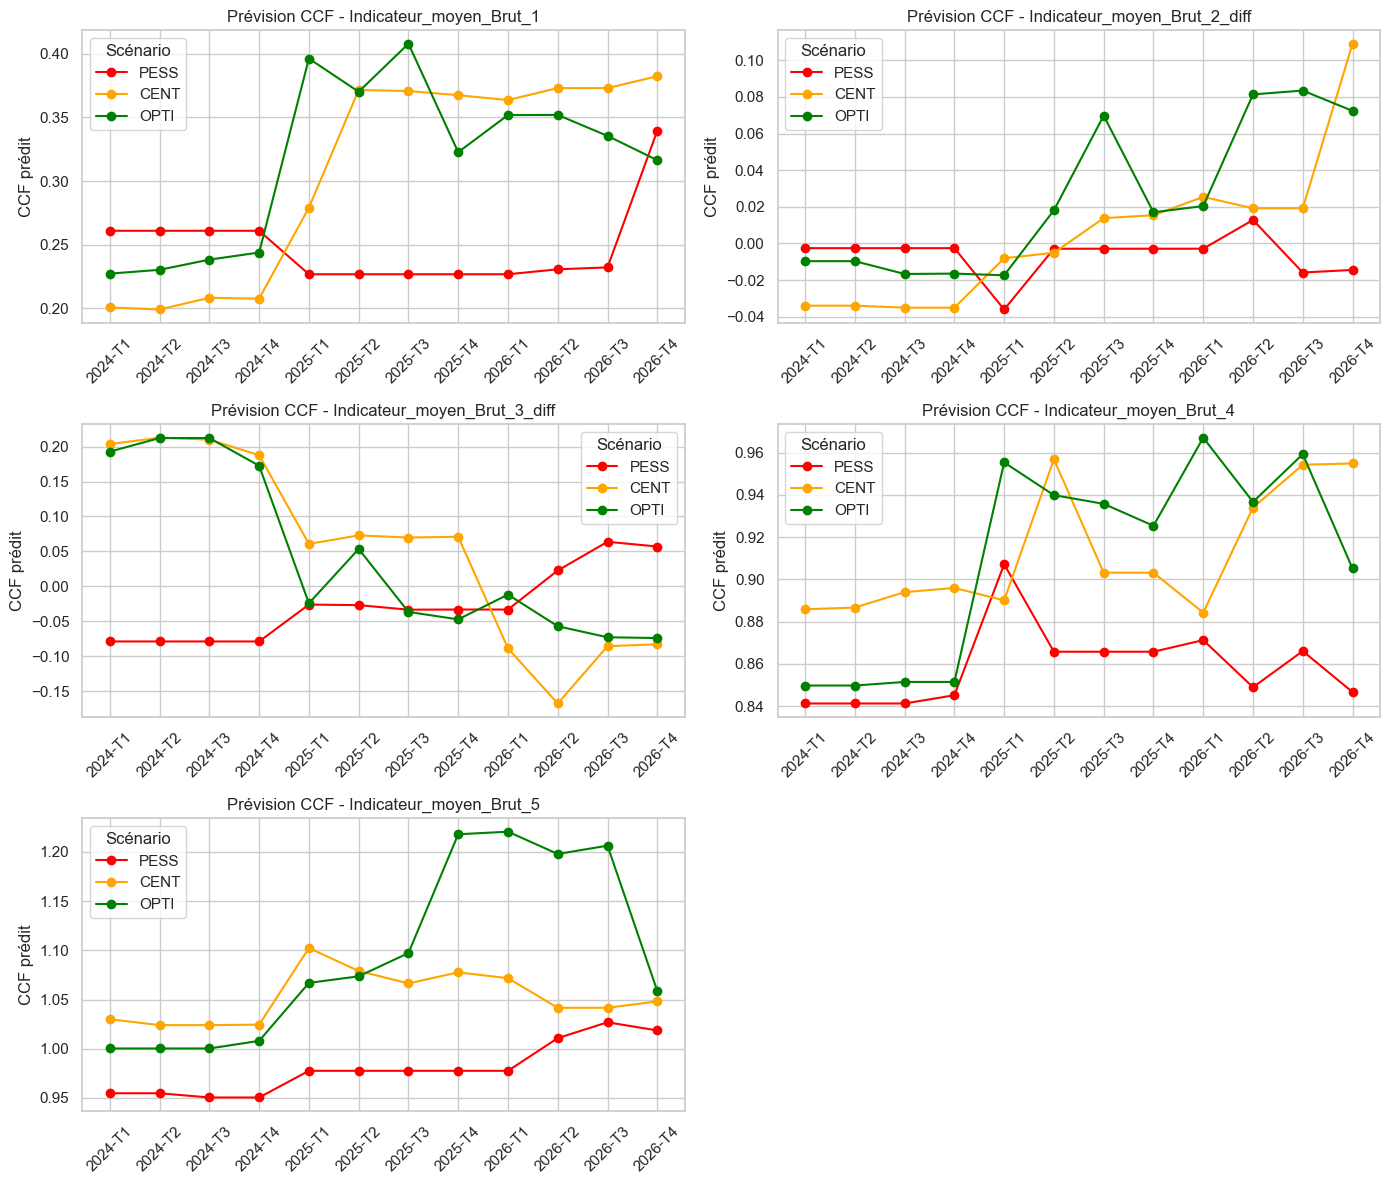

In [194]:
# Adapter les noms pour les trimestres : fusion Année + Trimestre
projection_df["Période"] = projection_df["Année"].astype(str) + "-" + projection_df["Trimestre"]

# Réordonner les périodes pour l'affichage
projection_df = projection_df.sort_values(by=["Segment", "Année", "Trimestre"])

# Génération des subplots 2 colonnes
segments = projection_df["Segment"].unique()
ncols = 2
nrows = (len(segments) + ncols - 1) // ncols
couleurs = {"PESS": "red", "CENT": "orange", "OPTI": "green"}

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows), sharex=False)
axes = axes.flatten()

for i, segment in enumerate(segments):
    ax = axes[i]
    df_seg = projection_df[projection_df["Segment"] == segment]
    
    for scenario in ["PESS", "CENT", "OPTI"]:
        df_scen = df_seg[df_seg["Scénario"] == scenario]
        ax.plot(df_scen["Période"], df_scen["Prévision_CCF"],
                marker='o', label=scenario, color=couleurs[scenario])
    
    ax.set_title(f"Prévision CCF - {segment}")
    ax.set_ylabel("CCF prédit")
    ax.set_xticks(df_seg["Période"].unique())
    ax.set_xticklabels(df_seg["Période"].unique(), rotation=45)
    ax.grid(True)
    ax.legend(title="Scénario")

# Supprimer les axes vides s’il y en a
for j in range(len(segments), len(axes)):
    fig.delaxes(axes[j])

axes[-1].set_xlabel("Période (Année-Trimestre)")
plt.tight_layout()
plt.show()


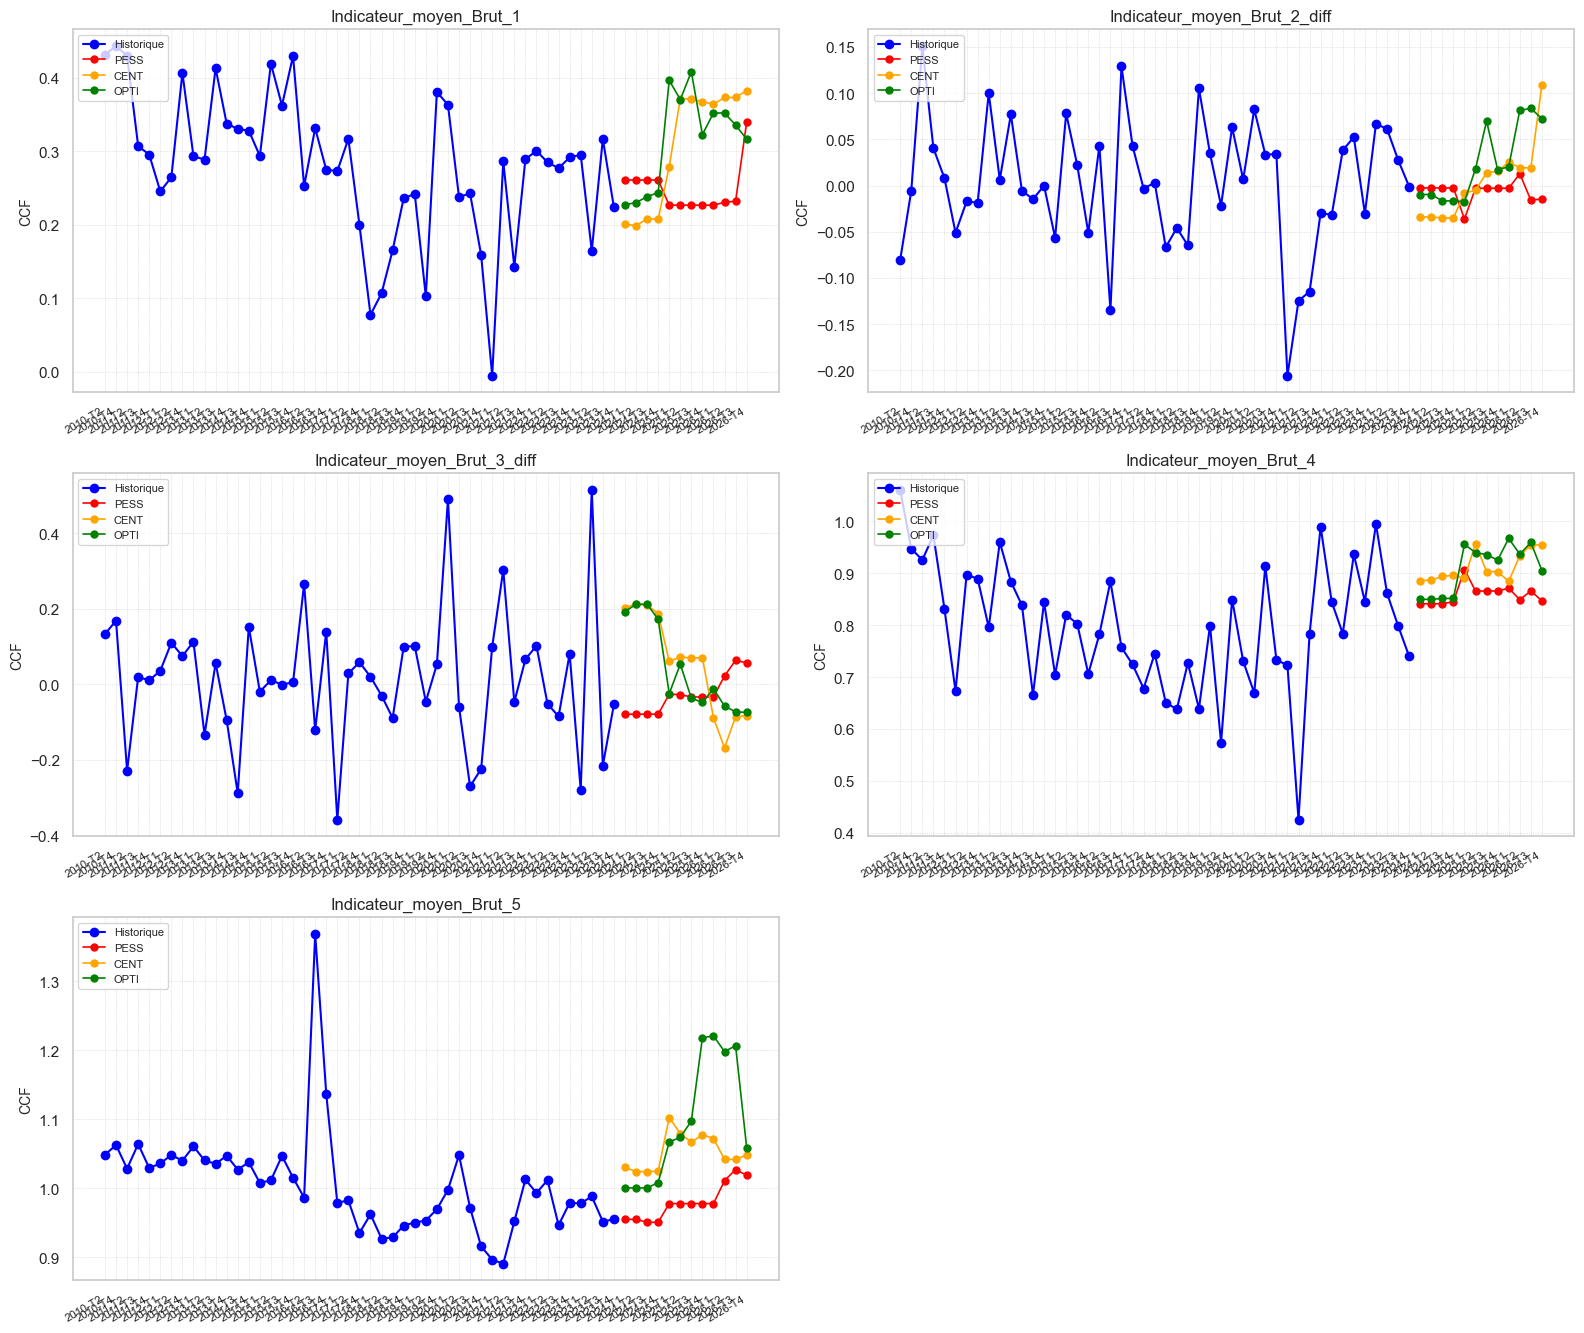

In [195]:
import matplotlib.pyplot as plt

# Générer Période fusionnée
projection_df["Période"] = projection_df["Année"].astype(str) + "-" + projection_df["Trimestre"]
df_real_melted["Période"] = df_real_melted["Année"].astype(str) + "-" + df_real_melted["Trimestre"]

# Ordre des périodes
ordre_periodes = sorted(set(projection_df["Période"]) | set(df_real_melted["Période"]))

# Plot propre
segments = projection_df["Segment"].unique()
ncols = 2
nrows = (len(segments) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4.5 * nrows), sharex=False)
axes = axes.flatten()

couleurs = {"PESS": "red", "CENT": "orange", "OPTI": "green"}

for i, segment in enumerate(segments):
    ax = axes[i]

    # Données réelles
    df_real = df_real_melted[df_real_melted["Segment"] == segment]
    ax.plot(df_real["Période"], df_real["Valeur_réelle"],
        linestyle='-', marker='o', color='blue', label="Historique")

    # Données prédites
    df_pred = projection_df[projection_df["Segment"] == segment]
    for scenario in couleurs:
        df_scen = df_pred[df_pred["Scénario"] == scenario]
        ax.plot(df_scen["Période"], df_scen["Prévision_CCF"],
                marker='o', markersize=5, linewidth=1.2,
                label=scenario, color=couleurs[scenario])
    
    
    ax.set_title(segment, fontsize=12)
    ax.set_ylabel("CCF", fontsize=10)
    ax.set_xticks(ordre_periodes)
    ax.set_xticklabels(ordre_periodes, rotation=30, ha='right', fontsize=8)
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.legend(fontsize=8, loc="upper left")

# Supprimer axes vides si nb de segments impair
for j in range(len(segments), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


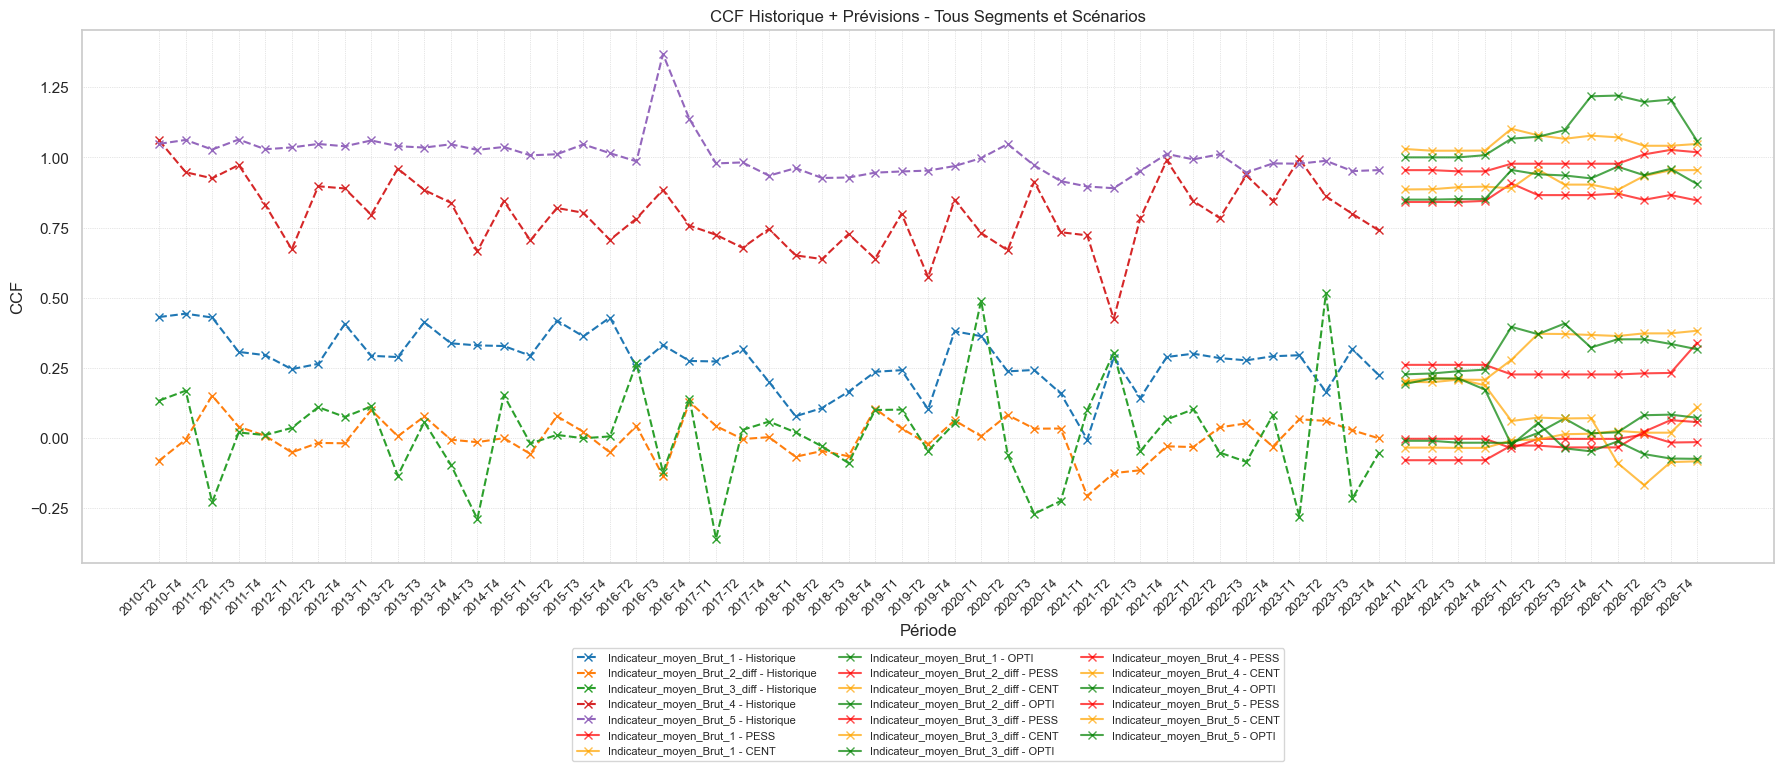

In [ ]:
# Fusion année-trimestre pour l'axe X
projection_df["Période"] = projection_df["Année"].astype(str) + "-" + projection_df["Trimestre"]
df_real_melted["Période"] = df_real_melted["Année"].astype(str) + "-" + df_real_melted["Trimestre"]

# Ordonner les périodes
ordre_periodes = sorted(set(projection_df["Période"]) | set(df_real_melted["Période"]))

# Couleurs
couleurs_scenarios = {"PESS": "red", "CENT": "orange", "OPTI": "green"}
couleurs_segments = plt.cm.tab10.colors  # Couleurs distinctes pour les historiques des segments

segments = projection_df["Segment"].unique()

plt.figure(figsize=(18, 8))

# Tracer l'historique pour chaque segment (en bleu ou différent si souhaité)
for i, segment in enumerate(segments):
    df_hist = df_real_melted[df_real_melted["Segment"] == segment]
    plt.plot(df_hist["Période"], df_hist["Valeur_réelle"],
             linestyle='--', marker='x', label=f"{segment} - Historique",
             color=couleurs_segments[i % len(couleurs_segments)])

# Tracer les prévisions pour chaque segment et chaque scénario
for i, segment in enumerate(segments):
    df_pred = projection_df[projection_df["Segment"] == segment]
    for scenario, color in couleurs_scenarios.items():
        df_scen = df_pred[df_pred["Scénario"] == scenario]
        plt.plot(df_scen["Période"], df_scen["Prévision_CCF"],
                 marker='x', linewidth=1.5, alpha=0.7,
                 label=f"{segment} - {scenario}", color=color)

# Mise en forme
plt.xticks(ordre_periodes, rotation=45, ha='right', fontsize=9)
plt.xlabel("Période")
plt.ylabel("CCF")
plt.title("CCF Historique + Prévisions - Tous Segments et Scénarios")
plt.grid(True, linestyle=':', linewidth=0.5)
plt.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()
plt.show()


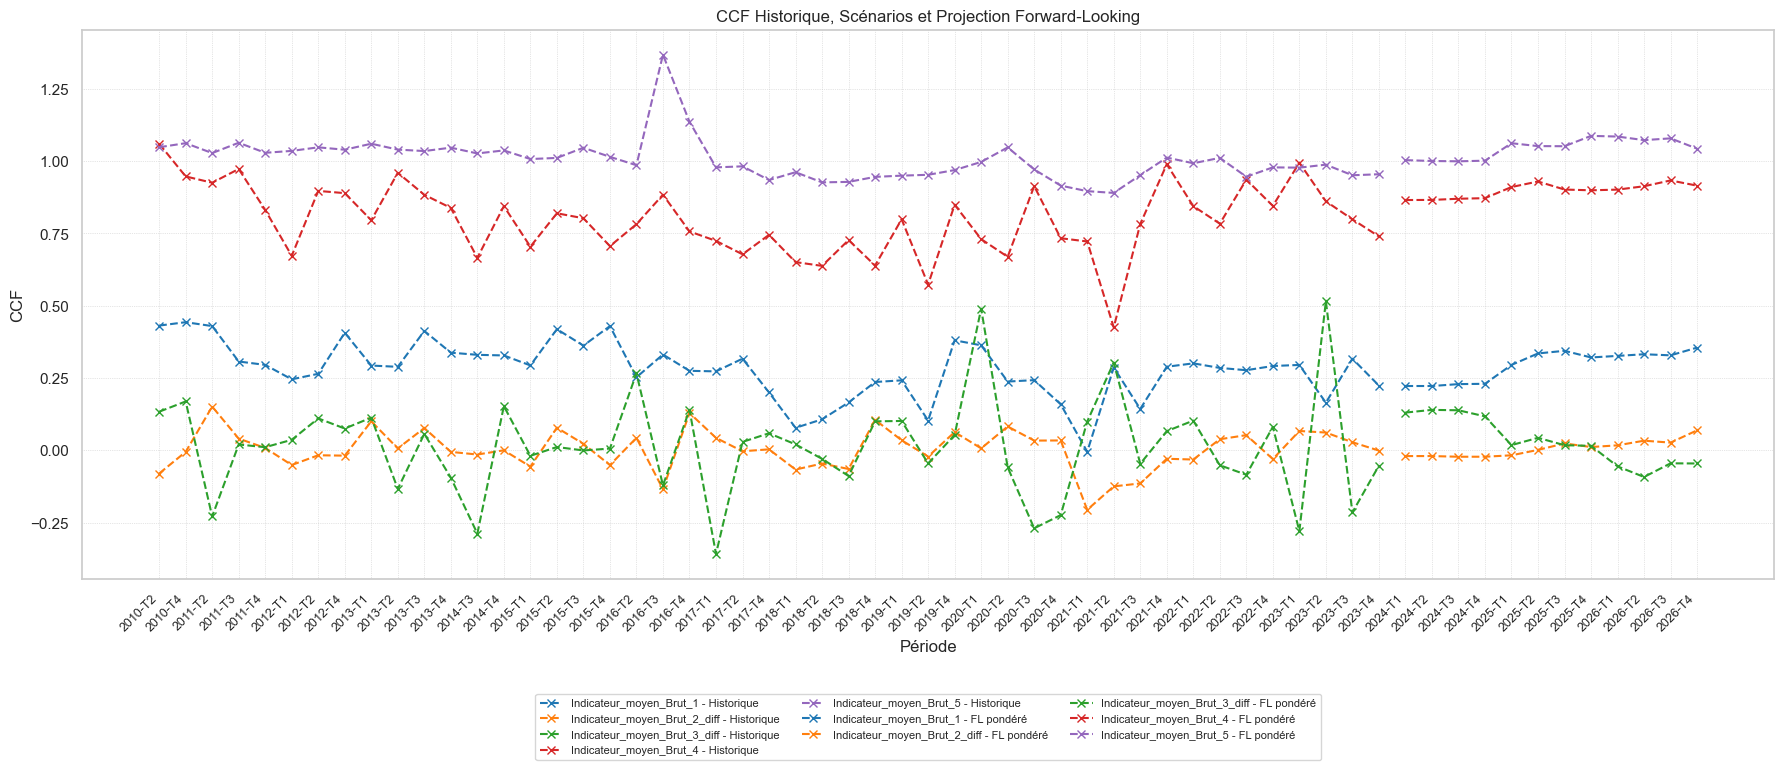

In [202]:
# Définir les poids de scénario
poids_scenarios = {"PESS": 0.25, "CENT": 0.50, "OPTI": 0.25}
projection_df["Poids"] = projection_df["Scénario"].map(poids_scenarios)

# Ajouter Période si elle a disparu
projection_df["Période"] = projection_df["Année"].astype(str) + "-" + projection_df["Trimestre"]

# Calcul du CCF Forward Looking pondéré
df_fl = (
    projection_df
    .assign(pondéré=projection_df["Prévision_CCF"] * projection_df["Poids"])
    .groupby(["Segment", "Année", "Trimestre", "Période"], as_index=False)
    .agg({"pondéré": "sum"})
    .rename(columns={"pondéré": "CCF_Forward_Looking"})
)

# Préparer les données historiques
df_real_melted["Période"] = df_real_melted["Année"].astype(str) + "-" + df_real_melted["Trimestre"]
ordre_periodes = sorted(set(projection_df["Période"]) | set(df_real_melted["Période"]))

# Plot
plt.figure(figsize=(18, 8))

# Tracer l'historique
for i, segment in enumerate(segments):
    df_hist = df_real_melted[df_real_melted["Segment"] == segment]
    plt.plot(df_hist["Période"], df_hist["Valeur_réelle"],
             linestyle='--', marker='x', label=f"{segment} - Historique",
             color=couleurs_segments[i % len(couleurs_segments)])


# Tracer les prévisions Forward Looking (moyennées)
for i, segment in enumerate(segments):
    df_seg_fl = df_fl[df_fl["Segment"] == segment]
    plt.plot(df_seg_fl["Période"], df_seg_fl["CCF_Forward_Looking"],
             linestyle='--', marker='x', label=f"{segment} - FL pondéré",
             color=couleurs_segments[i % len(couleurs_segments)])

# Finalisation
plt.xticks(ordre_periodes, rotation=45, ha='right', fontsize=9)
plt.xlabel("Période")
plt.ylabel("CCF")
plt.title("CCF Historique, Scénarios et Projection Forward-Looking")
plt.grid(True, linestyle=':', linewidth=0.5)
plt.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.tight_layout()
plt.show()
